<h1 style="color:#333333; font-family:Arial, sans-serif; font-size:30px; font-weight:bold; text-align:center;">Tree-based variational inference for Poisson log-normal
models</h1>

This notebook contains all the experiments performed in the paper "ref arXiv"

## Utils

Here we group all of the utils function for plotting etc.

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib
import torch
from torch import optim
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import seaborn as sns
import plntree.metrics.viz as metrics_viz
from plntree.models import pln_lib, PLNTree
from plntree.utils import tree_utils
from plntree.utils import seed_all
from plntree.utils.jupyter_functions import *

pd.set_option('display.float_format', lambda x: '%.5f' % x)

viridis = matplotlib.colormaps.get_cmap('viridis')
magma = matplotlib.colormaps.get_cmap('magma')
blues = matplotlib.colormaps.get_cmap('Blues')

2024-05-12 20:39:24.055132: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-12 20:39:24.056941: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 20:39:24.079517: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 20:39:24.079540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 20:39:24.080365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Synthetic data study

### PLN-Tree generated data

#### Model choice and data generation

In [2]:
seed = 42
prefix = f'synthetic_plntree_s{seed}'

seed_all(seed)

In [3]:
# Model parameters
selected_layers = [1, -1]

# Tree parameters
K = [1, 5, 14, 35]
mu_1 = torch.tensor([0., 1, -0.2, 2, 0]) + 0.1 * torch.randn(K[selected_layers[0]])
Omega_1 = torch.tensor(artificial_loader.generate_precision_matrix(
    artificial_loader.generate_adjacency_matrix(K[selected_layers[0]], seed=seed), 
    conditioning=0.3, 
    correlation=0.4
))

identifiable = True
diag_correction = 1e-3
positive_fun = 'softplus'

n_latent_layers = 3
    
offset_method = 'constant'
offset_constant = 8.

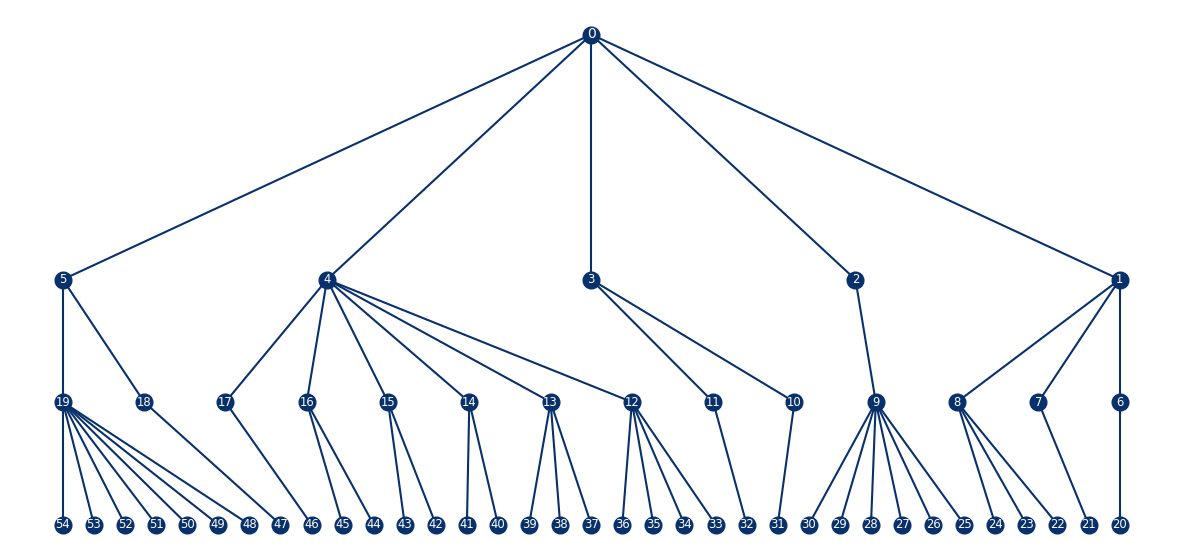

In [4]:
tree = generate_hierachical_tree(K, seed=seed)
tree.plot(legend=False, title='')
savefig('synthetic_plntree_tree_graph')

In [5]:
base = PLNTree(
        tree=tree,
        identifiable=identifiable,
        diag_smoothing_factor=diag_correction,
        positive_fun=positive_fun,
        selected_layers=selected_layers,
        offset_method=offset_method,
        n_latent_layers=n_latent_layers,
        seed=seed
    )

base.mu_fun[0].data = mu_1
base.omega_fun[1][0].weight.data *= 20
base.mu_fun[1][0].weight.data += 10
base.mu_fun[2][2].weight.data *= 20
base.mu_fun[2][2].weight.data += 5
base.offset_constant.data = torch.tensor([offset_constant])

In [6]:
n_data = 2_000
dataloader = artificial_loader.load_artificial_data(base, n_data=n_data, batch_size=512, seed=seed)

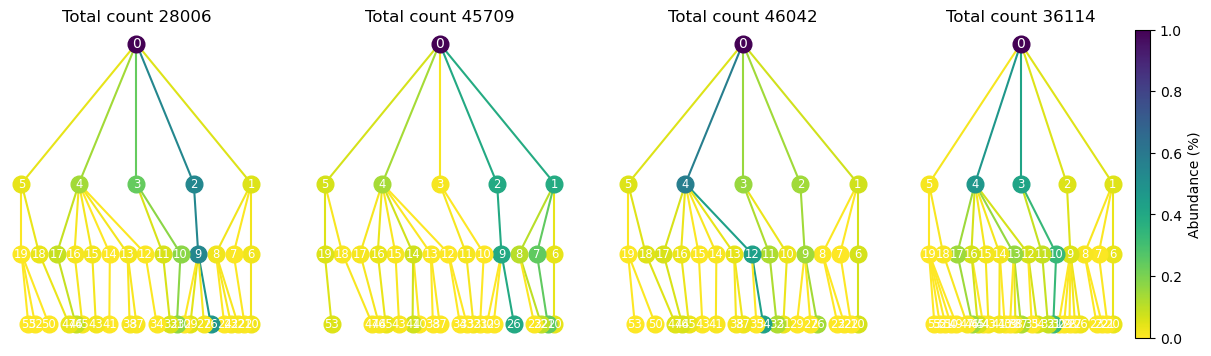

In [7]:
vizualize_samples(dataloader, tree, base.selected_layers, autofill=True, seed=seed)
savefig('synthetic_plntree_samples')

In [8]:
X_base, Z_base, O_base = dataloader_to_tensors(dataloader)

In [9]:
Z_base[:, 1, :base.K[1]].mean(axis=0)

tensor([ 0.7590, -0.2268, -0.5325,  0.0000, -0.4507,  0.4524,  1.0155, -0.5115,
        -0.6064, -0.7729,  0.0384,  0.8380,  0.2367, -0.2359],
       grad_fn=<MeanBackward1>)

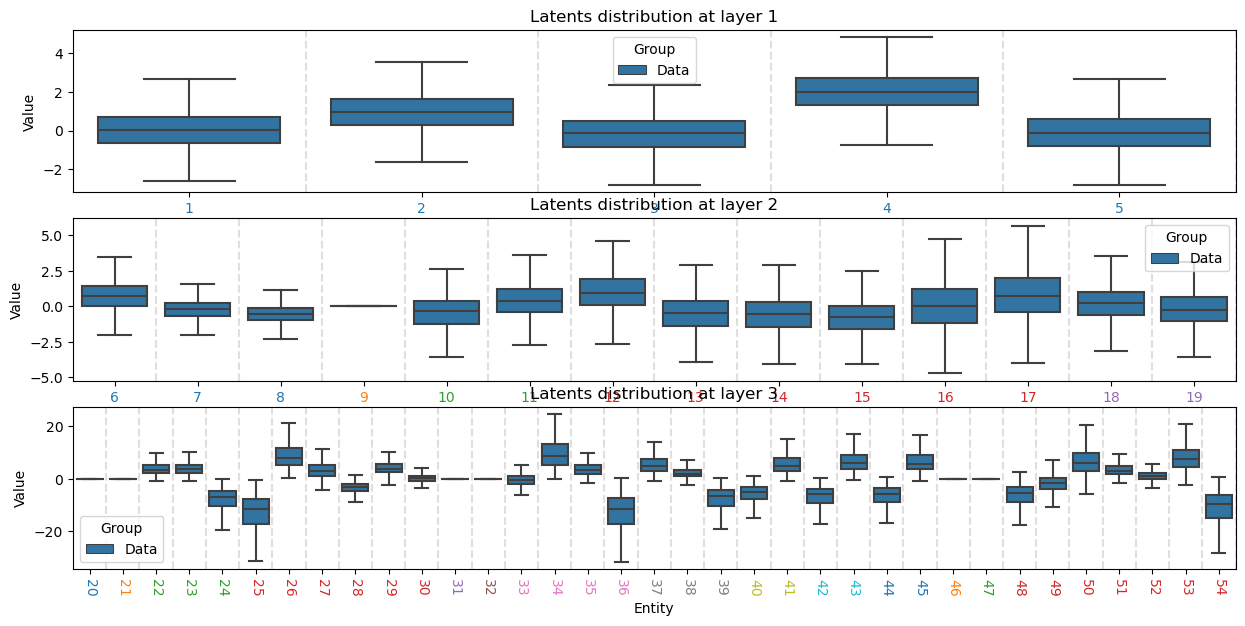

In [10]:
vizualize_entities_distributions(base, (Z_base.detach(),), ['Data'], title='Latents', figsize=(15, 7))

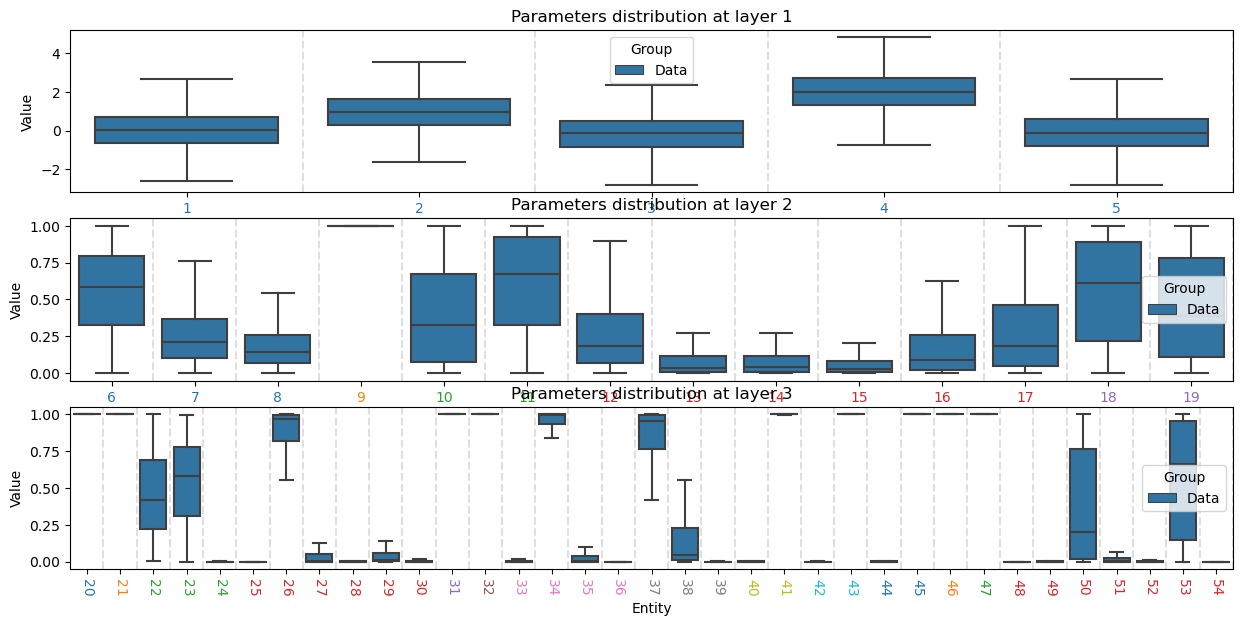

In [11]:
Z_multinomial_base = multinomial_probas(Z_base, base)
vizualize_entities_distributions(base, (Z_multinomial_base.detach(),), ['Data'], title='Parameters', figsize=(15, 7))

#### Benchmark models

##### PLN

Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 899 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 886 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 836 iterations
Likelihood: -98424.39513897896


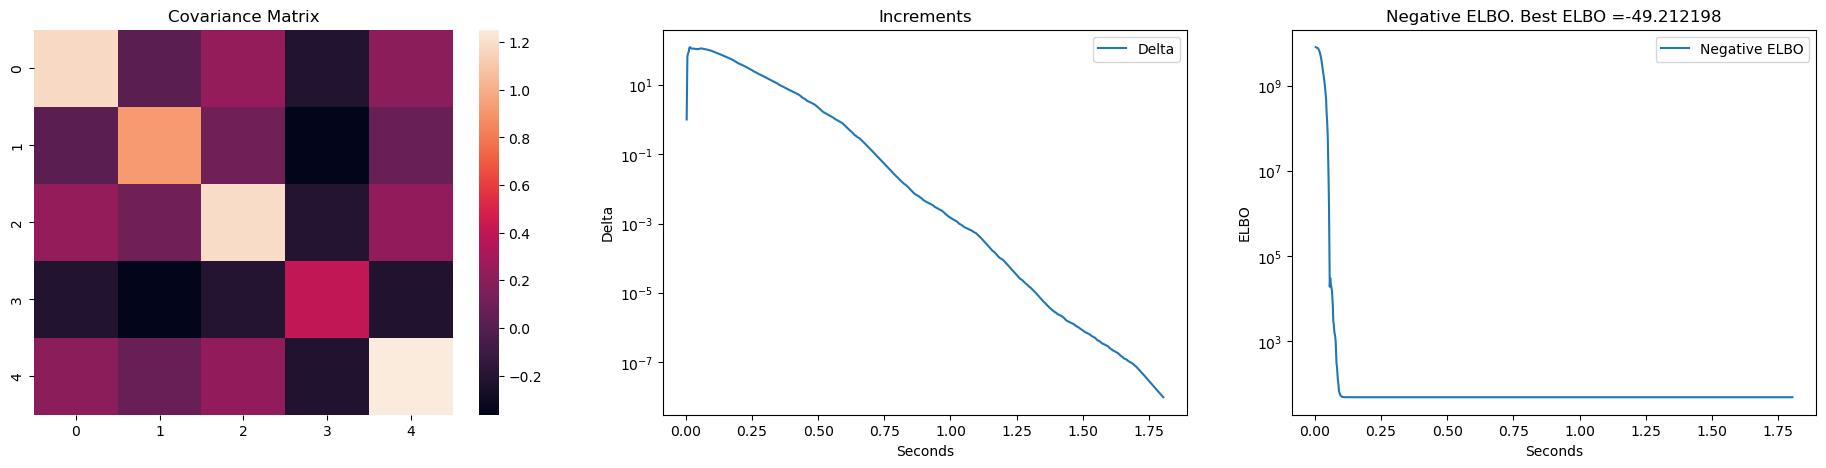

Likelihood: -242809.9739727974


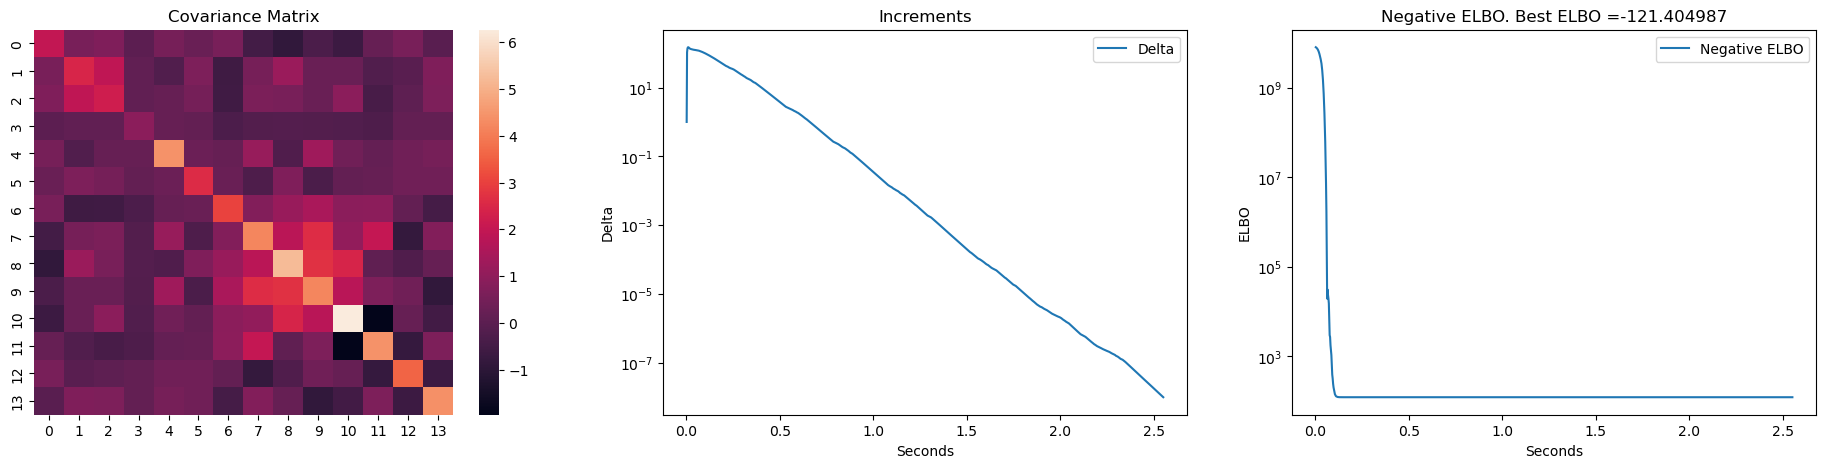

Likelihood: -345662.00669693947


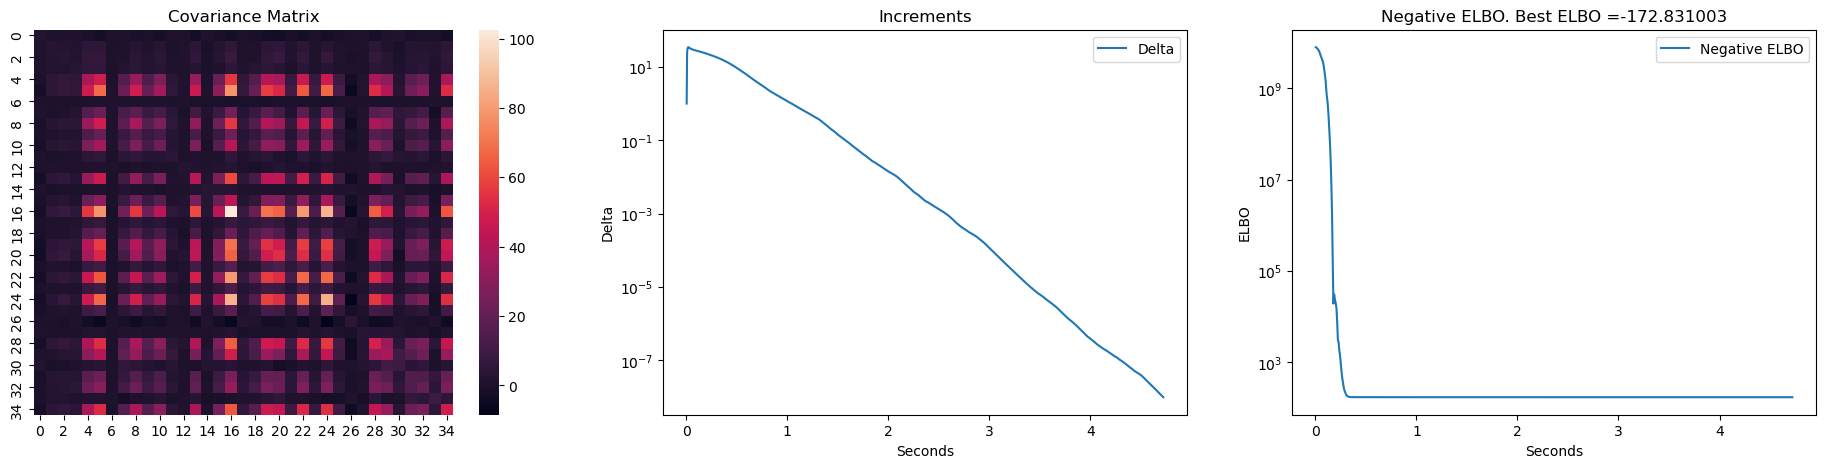

In [12]:
pln_layers = learn_pln(X_base, base.K, seed=seed)

In [13]:
n_samples = 50_000
X_pln, Z_pln, X_pln_fill, X_pln_enc, Z_pln_enc, X_pln_enc_fill = generate_pln_data(pln_layers, n_samples, base.K, base.selected_layers, X_base, tree, seed=seed)

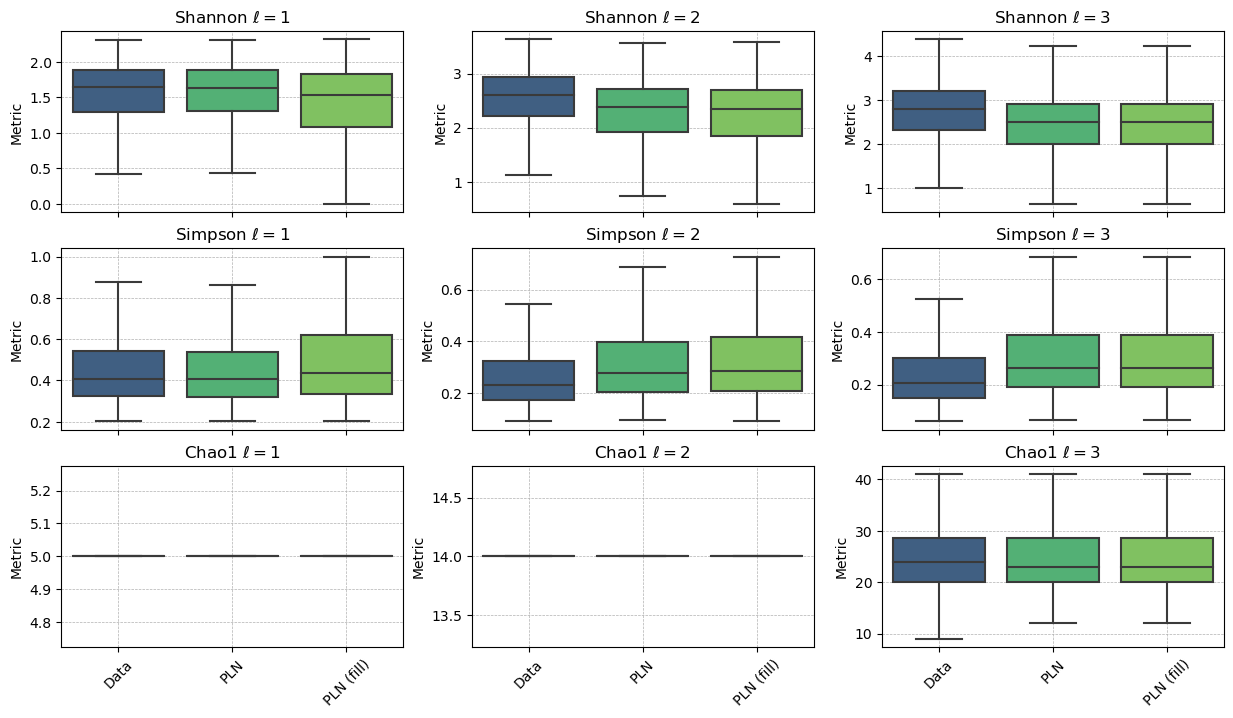

In [14]:
X_list = (X_base, X_pln, X_pln_fill)
groups = ['Data', 'PLN', 'PLN (fill)']
colors = [viridis(0.3), viridis(0.7), viridis(0.8)]

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=base.selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot'
)

#### PLN-Tree Mean Field

##### Model Selection

In [32]:
def learn_plntree_mean_field(variational_approx_params):
    estimator = PLNTree(
        tree=tree,
        selected_layers=base.selected_layers,
        diagonal_model=base.diagonal_model,
        diag_smoothing_factor=diag_correction,
        positive_fun=positive_fun,
        offset_method=offset_method,
        identifiable=identifiable,
        variational_approx='mean_field',
        variational_approx_params=variational_approx_params,
        n_latent_layers=n_latent_layers,
        seed=seed
    )

    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    n_epoch = 15_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

In [43]:
preprocessing = 'log'
variational_approx_params_list = [
    {'n_variational_layers': 1, 'preprocessing': [preprocessing]},
    {'n_variational_layers': 2, 'preprocessing': [preprocessing]},
    {'n_variational_layers': 3, 'preprocessing': [preprocessing]},
]

In [44]:
meanfields = []
for variational_approx_params in variational_approx_params_list:
    try:
        meanfield, meanfield_losses = load_pkl(prefix, f'mean_field_{preprocessing}-nvar-{variational_approx_params["n_variational_layers"]}')
    except:
        print('Learning PLN-Tree (MF)')
        print(variational_approx_params)
        meanfield, meanfield_losses = learn_plntree_mean_field(variational_approx_params)
        save_pkl((meanfield, meanfield_losses), prefix, f'mean_field_{preprocessing}-nvar-{variational_approx_params["n_variational_layers"]}')
    meanfields.append([meanfield, meanfield_losses])

Loading file ./experiments/saves/synthetic_plntree_s42_mean_field_log-nvar-1.pkl
Learning PLN-Tree (MF)
{'n_variational_layers': 1, 'preprocessing': ['log']}
[*] Epoch: 100 Average loss: 56036.0513
[*] Epoch: 200 Average loss: 8790.2141
[*] Epoch: 300 Average loss: 6973.7601
[*] Epoch: 400 Average loss: 5732.4468
[*] Epoch: 500 Average loss: 4833.3835
[*] Epoch: 600 Average loss: 4256.2618
[*] Epoch: 700 Average loss: 3880.3541
[*] Epoch: 800 Average loss: 3550.1650
[*] Epoch: 900 Average loss: 3238.1800
[*] Epoch: 1000 Average loss: 2967.0355
[*] Epoch: 1100 Average loss: 2721.3236
[*] Epoch: 1200 Average loss: 2496.5321
[*] Epoch: 1300 Average loss: 2319.8864
[*] Epoch: 1400 Average loss: 2182.9224
[*] Epoch: 1500 Average loss: 2088.9709
[*] Epoch: 1600 Average loss: 2024.0533
[*] Epoch: 1700 Average loss: 1975.3939
[*] Epoch: 1800 Average loss: 1933.0133
[*] Epoch: 1900 Average loss: 1901.2985
[*] Epoch: 2000 Average loss: 1873.7001
[*] Epoch: 2100 Average loss: 1854.2764
[*] Epoch:

[*] Epoch: 4500 Average loss: 1613.5408
[*] Epoch: 4600 Average loss: 1615.1134
[*] Epoch: 4700 Average loss: 1613.1809
[*] Epoch: 4800 Average loss: 1609.2137
[*] Epoch: 4900 Average loss: 1601.2796
[*] Epoch: 5000 Average loss: 1597.8299
[*] Epoch: 5100 Average loss: 1598.4818
[*] Epoch: 5200 Average loss: 1595.2612
[*] Epoch: 5300 Average loss: 1597.9227
[*] Epoch: 5400 Average loss: 1590.0529
[*] Epoch: 5500 Average loss: 1587.0947
[*] Epoch: 5600 Average loss: 1588.7972
[*] Epoch: 5700 Average loss: 1583.6115
[*] Epoch: 5800 Average loss: 1586.3625
[*] Epoch: 5900 Average loss: 1579.4411
[*] Epoch: 6000 Average loss: 1575.9507
[*] Epoch: 6100 Average loss: 1572.7134
[*] Epoch: 6200 Average loss: 1574.8143
[*] Epoch: 6300 Average loss: 1575.4157
[*] Epoch: 6400 Average loss: 1578.0001
[*] Epoch: 6500 Average loss: 1574.7796
[*] Epoch: 6600 Average loss: 1564.4035
[*] Epoch: 6700 Average loss: 1570.2182
[*] Epoch: 6800 Average loss: 1567.8397
[*] Epoch: 6900 Average loss: 1562.8826


[*] Epoch: 9300 Average loss: 4675.2670
[*] Epoch: 9400 Average loss: 4679.6769
[*] Epoch: 9500 Average loss: 4680.3717
[*] Epoch: 9600 Average loss: 4674.3375
[*] Epoch: 9700 Average loss: 4680.9161
[*] Epoch: 9800 Average loss: 4678.2891
[*] Epoch: 9900 Average loss: 4670.7040
[*] Epoch: 10000 Average loss: 4679.6334
[*] Epoch: 10100 Average loss: 4668.8720
[*] Epoch: 10200 Average loss: 4682.7835
[*] Epoch: 10300 Average loss: 4682.1403
[*] Epoch: 10400 Average loss: 4681.5538
[*] Epoch: 10500 Average loss: 4672.6214
[*] Epoch: 10600 Average loss: 4678.3222
[*] Epoch: 10700 Average loss: 4678.9830
[*] Epoch: 10800 Average loss: 4673.7981
[*] Epoch: 10900 Average loss: 4670.8476
[*] Epoch: 11000 Average loss: 4675.8678
[*] Epoch: 11100 Average loss: 4672.2327
[*] Epoch: 11200 Average loss: 4671.8164
[*] Epoch: 11300 Average loss: 4664.6540
[*] Epoch: 11400 Average loss: 4673.8651
[*] Epoch: 11500 Average loss: 4671.2330
[*] Epoch: 11600 Average loss: 4666.9532
[*] Epoch: 11700 Averag

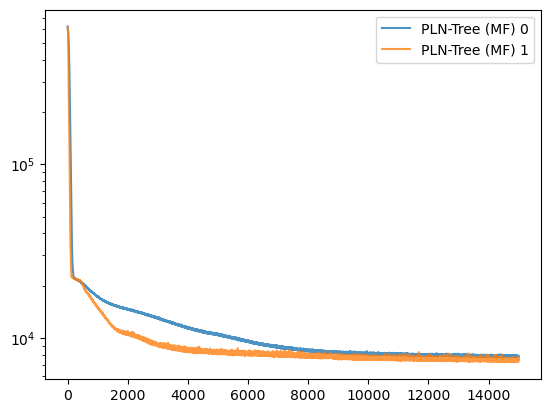

In [35]:
fig, axs = plt.subplots()
for k, (meanfield, losses) in enumerate(meanfields):
    axs.plot(losses, label=f'PLN-Tree (MF) {k}', alpha=0.8)
axs.set_yscale('log')
plt.legend()
savefig(f'{prefix}_ELBO_meanfields_selection')

In [36]:
n_samples = 15_000
meanfields_samples = {}
for key, (meanfield, losses) in enumerate(meanfields):
    X_meanfield, Z_meanfield, O_meanfield = meanfield.sample(n_samples)
    meanfields_samples[key] = X_meanfield

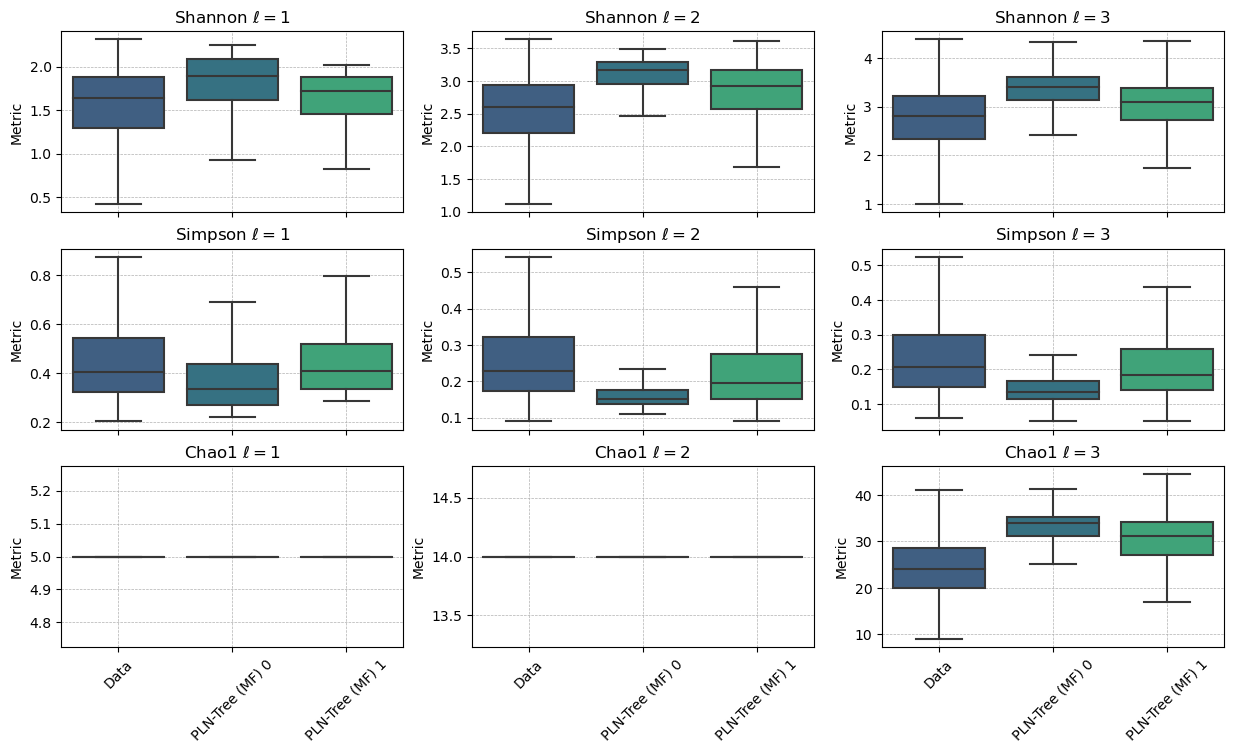

In [37]:
X_list = [X_base] + [X_meanfield for key, X_meanfield in meanfields_samples.items()]
groups = ['Data'] + ['PLN-Tree (MF) ' + str(key) for key, _ in meanfields_samples.items()]
groups_colors = [viridis(0.4 + int(key)/4) for key in meanfields_samples.keys()]
colors = [viridis(0.3)] + groups_colors

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

In [38]:
print('Wasserstein Distance')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=wasserstein_distance, offset_layer=base.selected_layers[0], order=True
)

Wasserstein Distance


In [28]:
print('Kullback-Leilbler')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kl_divergence, offset_layer=base.selected_layers[0], order=True
)

Kullback-Leilbler


In [29]:
print('Kolmogorov-Smirnov')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kolmogorov_smirnov, offset_layer=base.selected_layers[0], order=True
)

Kolmogorov-Smirnov


In [30]:
print('Total variation')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=total_variation, offset_layer=base.selected_layers[0], order=True
)

Total variation


##### Selected model training

In [25]:
meanfield, meanfield_losses = meanfields[1]

In [28]:
if pretrained:
    meanfields_repeat = load_pkl(prefix, 'mean_fields_repeats')
else:
    n_repeat = 5
    meanfields_repeat = []
    for i in range(n_repeat):
        meanfield, meanfield_losses = learn_plntree_mean_field(variational_approx_params[0])
        meanfields_repeat.append(meanfield, meanfield_losses)
    save_pkl(meanfields_repeat, prefix, 'mean_fields_repeats')

Loading file ./experiments/saves/synthetic_plntree_mean_field.pkl


In [ ]:
fig, axs = plt.subplots()
for (meanfield, meanfield_losses) in meanfields_repeat:
    axs.plot(meanfield_losses, alpha=0.3)
axs.set_yscale('log')
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
savefig(f"synthetic_plntree_MF_ELBOs")

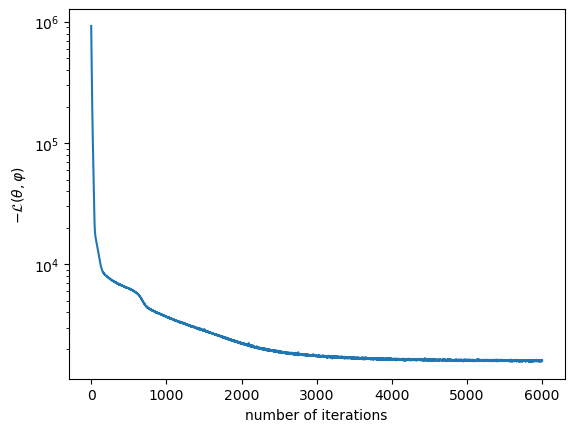

In [26]:
fig, axs = plt.subplots()
axs.plot(meanfield_losses[:])
axs.set_yscale('log')
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
savefig(f"synthetic_plntree_MF_ELBO")

In [42]:
n_samples = 50_000

X_meanfield, Z_meanfield, O_meanfield = meanfield.sample(n_samples)
Z_meanfield_enc, O_meanfield_enc = meanfield.encode(X_base)
X_meanfield_enc = meanfield.decode(Z_meanfield_enc, O_meanfield_enc)

### PLN-Tree Backward

##### Model Selection

In [45]:
def learn_plntree(variational_approx_params):
    estimator = PLNTree(
        tree=tree,
        selected_layers=base.selected_layers,
        diagonal_model=base.diagonal_model,
        diag_smoothing_factor=diag_correction,
        positive_fun=positive_fun,
        offset_method=offset_method,
        identifiable=identifiable,
        variational_approx='amortized_backward',
        variational_approx_params=variational_approx_params,
        n_latent_layers=n_latent_layers,
        seed=seed
    )

    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    n_epoch = 20_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

In [46]:
preprocessing = 'log'
variational_approx_params_list = [
    {
        'embedder_type': 'GRU',
        'embedding_size': 32,
        'n_embedding_layers': 2,
        'n_embedding_neurons': 64,
        'n_after_layers': 1,
        'preprocessing': [preprocessing]
    },
    {
        'embedder_type': 'GRU',
        'embedding_size': 32,
        'n_embedding_layers': 2,
        'n_embedding_neurons': 64,
        'n_after_layers': 2,
        'preprocessing': [preprocessing]
    },
    {
        'embedder_type': 'GRU',
        'embedding_size': 32,
        'n_embedding_layers': 3,
        'n_embedding_neurons': 64,
        'n_after_layers': 1,
        'preprocessing': [preprocessing]
    },
    {
        'embedder_type': 'GRU',
        'embedding_size': 32,
        'n_embedding_layers': 3,
        'n_embedding_neurons': 64,
        'n_after_layers': 2,
        'preprocessing': [preprocessing]
    },
    {
        'embedder_type': 'GRU',
        'embedding_size': 32,
        'n_embedding_layers': 3,
        'n_embedding_neurons': 120,
        'n_after_layers': 2,
        'preprocessing': [preprocessing]
    },
]

In [ ]:
plntrees = []
for k, variational_approx_params in enumerate(variational_approx_params_list):
    print('Learning PLN-Tree (backward)', k, variational_approx_params)
    try:
        plntree, plntree_losses = load_pkl(prefix, f'plntree_{preprocessing}-{k}')
        plntrees.append([plntree, plntree_losses])
    except:
        plntree, plntree_losses = learn_plntree(variational_approx_params)
        save_pkl((plntree, plntree_losses), prefix, f'plntree_{preprocessing}-{k}')
        plntrees.append([plntree, plntree_losses])

Learning PLN-Tree (backward) 0 {'embedder_type': 'GRU', 'embedding_size': 32, 'n_embedding_layers': 2, 'n_embedding_neurons': 64, 'n_after_layers': 1, 'preprocessing': ['log']}
Loading file ./experiments/saves/synthetic_plntree_s42_plntree_log-0.pkl
[*] Epoch: 100 Average loss: 61667.4952
[*] Epoch: 200 Average loss: 5279.4764
[*] Epoch: 300 Average loss: 4324.4507
[*] Epoch: 400 Average loss: 3881.1598
[*] Epoch: 500 Average loss: 4166.6701
[*] Epoch: 600 Average loss: 4250.2427
[*] Epoch: 700 Average loss: 3391.7947
[*] Epoch: 800 Average loss: 2965.2628
[*] Epoch: 900 Average loss: 2845.2925
[*] Epoch: 1000 Average loss: 2545.3580
[*] Epoch: 1100 Average loss: 2468.5370
[*] Epoch: 1200 Average loss: 2301.6748
[*] Epoch: 1300 Average loss: 2182.9569
[*] Epoch: 1400 Average loss: 1987.9363
[*] Epoch: 1500 Average loss: 1904.2618
[*] Epoch: 1600 Average loss: 1742.6004
[*] Epoch: 1700 Average loss: 1693.6262
[*] Epoch: 1800 Average loss: 1611.3315
[*] Epoch: 1900 Average loss: 1485.137

[*] Epoch: 100 Average loss: 65575.6588
[*] Epoch: 200 Average loss: 5719.7960
[*] Epoch: 300 Average loss: 4382.5713
[*] Epoch: 400 Average loss: 3805.6193
[*] Epoch: 500 Average loss: 3268.1615
[*] Epoch: 600 Average loss: 3068.0602
[*] Epoch: 700 Average loss: 2734.3653
[*] Epoch: 800 Average loss: 2508.5913
[*] Epoch: 900 Average loss: 2267.9334
[*] Epoch: 1000 Average loss: 2111.3802
[*] Epoch: 1100 Average loss: 1984.8174
[*] Epoch: 1200 Average loss: 1815.0077
[*] Epoch: 1300 Average loss: 1742.8676
[*] Epoch: 1400 Average loss: 1620.4603
[*] Epoch: 1500 Average loss: 1494.0230
[*] Epoch: 1600 Average loss: 1441.8505
[*] Epoch: 1700 Average loss: 1374.5002
[*] Epoch: 1800 Average loss: 1331.4448
[*] Epoch: 1900 Average loss: 1286.3211
[*] Epoch: 2000 Average loss: 1231.2519
[*] Epoch: 2100 Average loss: 1176.3449
[*] Epoch: 2200 Average loss: 1129.5834
[*] Epoch: 2300 Average loss: 1113.1423
[*] Epoch: 2400 Average loss: 1073.7560
[*] Epoch: 2500 Average loss: 1038.8010
[*] Epoc

[*] Epoch: 100 Average loss: 71616.8266
[*] Epoch: 200 Average loss: 11687.3258
[*] Epoch: 300 Average loss: 8498.2324
[*] Epoch: 400 Average loss: 5690.0146
[*] Epoch: 500 Average loss: 4512.2436
[*] Epoch: 600 Average loss: 3862.3360
[*] Epoch: 700 Average loss: 3439.0738
[*] Epoch: 800 Average loss: 2988.8198
[*] Epoch: 900 Average loss: 2632.1054
[*] Epoch: 1000 Average loss: 2423.4270
[*] Epoch: 1100 Average loss: 2163.4924
[*] Epoch: 1200 Average loss: 2025.2378
[*] Epoch: 1300 Average loss: 1922.0711
[*] Epoch: 1400 Average loss: 1789.0187
[*] Epoch: 1500 Average loss: 1714.1080
[*] Epoch: 1600 Average loss: 1622.2965
[*] Epoch: 1700 Average loss: 1548.9070
[*] Epoch: 1800 Average loss: 1467.9314
[*] Epoch: 1900 Average loss: 1427.9823
[*] Epoch: 2000 Average loss: 1375.8337
[*] Epoch: 2100 Average loss: 1340.8868
[*] Epoch: 2200 Average loss: 1304.8068
[*] Epoch: 2300 Average loss: 1249.6904
[*] Epoch: 2400 Average loss: 1240.1291
[*] Epoch: 2500 Average loss: 1285.2044
[*] Epo

[*] Epoch: 100 Average loss: 71398.8822
[*] Epoch: 200 Average loss: 13772.7558
[*] Epoch: 300 Average loss: 8819.5255
[*] Epoch: 400 Average loss: 6384.0777
[*] Epoch: 500 Average loss: 5064.8447
[*] Epoch: 600 Average loss: 4580.1847
[*] Epoch: 700 Average loss: 3999.4086
[*] Epoch: 800 Average loss: 3582.3175
[*] Epoch: 900 Average loss: 3082.6028
[*] Epoch: 1000 Average loss: 2696.2433
[*] Epoch: 1100 Average loss: 2402.9019
[*] Epoch: 1200 Average loss: 2226.9575
[*] Epoch: 1300 Average loss: 2055.4234
[*] Epoch: 1400 Average loss: 1950.6634
[*] Epoch: 1500 Average loss: 1831.2564
[*] Epoch: 1600 Average loss: 1739.5965
[*] Epoch: 1700 Average loss: 1655.8874
[*] Epoch: 1800 Average loss: 1601.6290
[*] Epoch: 1900 Average loss: 1508.0784
[*] Epoch: 2000 Average loss: 1450.4663
[*] Epoch: 2100 Average loss: 1402.2616
[*] Epoch: 2200 Average loss: 1356.7998
[*] Epoch: 2300 Average loss: 1317.3486
[*] Epoch: 2400 Average loss: 1283.4535
[*] Epoch: 2500 Average loss: 1231.9989
[*] Epo

[*] Epoch: 100 Average loss: 67944.2844
[*] Epoch: 200 Average loss: 7125.8794
[*] Epoch: 300 Average loss: 4340.8672
[*] Epoch: 400 Average loss: 3614.9774
[*] Epoch: 500 Average loss: 3298.7548
[*] Epoch: 600 Average loss: 2679.6847
[*] Epoch: 700 Average loss: 2409.5232
[*] Epoch: 800 Average loss: 1992.9367
[*] Epoch: 900 Average loss: 1745.3091
[*] Epoch: 1000 Average loss: 1503.4103
[*] Epoch: 1100 Average loss: 1364.1369
[*] Epoch: 1200 Average loss: 1250.5853
[*] Epoch: 1300 Average loss: 1172.1349
[*] Epoch: 1400 Average loss: 1113.2700
[*] Epoch: 1500 Average loss: 1070.5833
[*] Epoch: 1600 Average loss: 1019.0793
[*] Epoch: 1700 Average loss: 979.1192
[*] Epoch: 1800 Average loss: 931.4415
[*] Epoch: 1900 Average loss: 907.1990
[*] Epoch: 2000 Average loss: 863.3544
[*] Epoch: 2100 Average loss: 828.8061
[*] Epoch: 2200 Average loss: 820.0708
[*] Epoch: 2300 Average loss: 809.3462
[*] Epoch: 2400 Average loss: 786.0280
[*] Epoch: 2500 Average loss: 764.7371
[*] Epoch: 2600 A

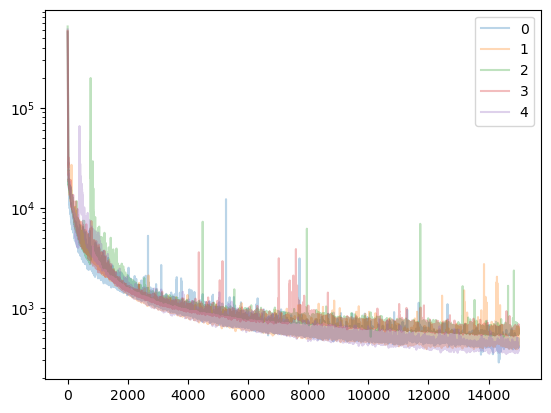

In [30]:
fig, axs = plt.subplots()
for k, (plntree, losses) in enumerate(plntrees):
    axs.plot(losses, label=f'{k}', alpha=0.3)
axs.set_yscale('log')
plt.legend()

In [31]:
n_samples = 15_000
backwards_samples = {}
for key, (estimator, losses) in enumerate(plntrees):
    X_estimator, Z_estimator, O_estimator = estimator.sample(n_samples)
    backwards_samples[key] = X_estimator

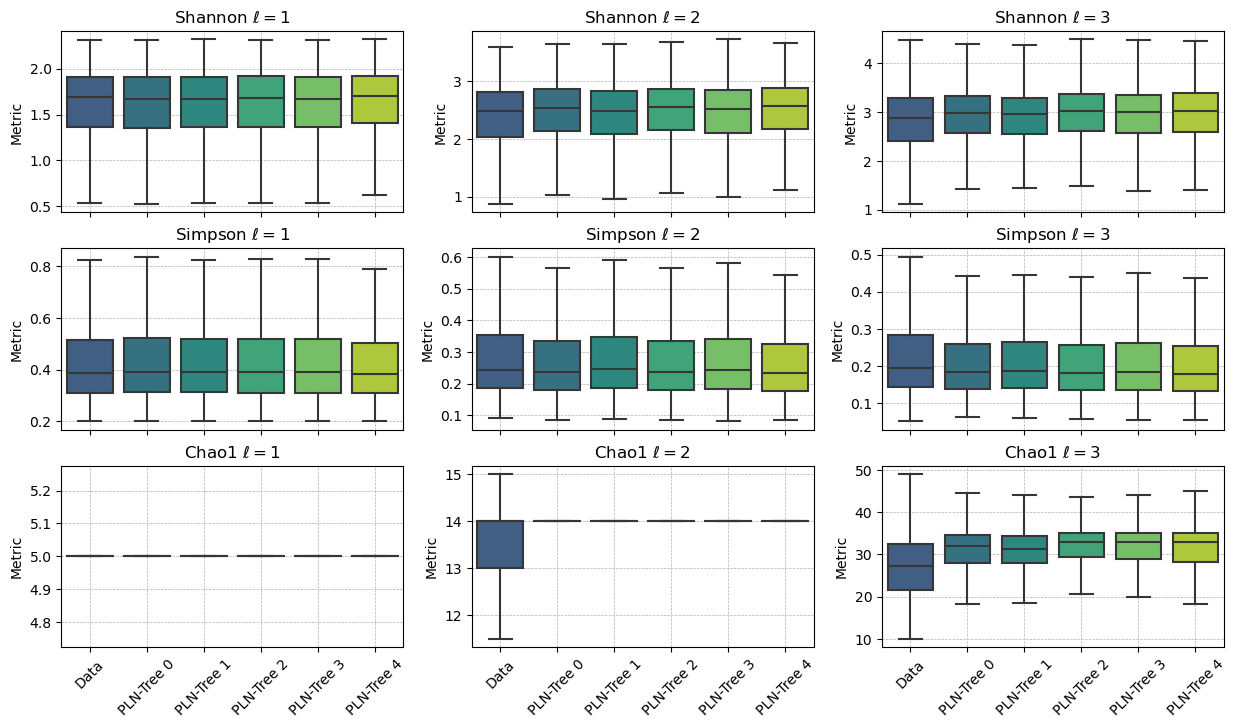

In [32]:
X_list = [X_base] + [X_estimator for key, X_estimator in backwards_samples.items()]
groups = ['Data'] + ['PLN-Tree ' + str(key) for key, X_estimator in backwards_samples.items()]
groups_colors = [viridis(0.4 + int(key)/8) for key in backwards_samples.keys()]
colors = [viridis(0.3)] + groups_colors

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

In [33]:
print('Wasserstein Distance')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=wasserstein_distance, offset_layer=base.selected_layers[0], order=True
)

Wasserstein Distance


In [34]:
print('Kullback-Leilbler')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kl_divergence, offset_layer=base.selected_layers[0], order=True
)

Kullback-Leilbler


In [35]:
print('Kolmogorov-Smirnov')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kolmogorov_smirnov, offset_layer=base.selected_layers[0], order=True
)

Kolmogorov-Smirnov


In [36]:
print('Total variation')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=total_variation, offset_layer=base.selected_layers[0], order=True
)

Total variation


##### Selected model training

In [37]:
estimators = [plntrees[3]]

In [32]:
if pretrained:
    backwards_repeat = load_pkl(prefix, 'backwards_repeats')
else:
    n_repeat = 5
    backwards_repeat = []
    for i in range(n_repeat):
        backward, backward_losses = learn_plntree(variational_approx_params[0])
        backwards_repeat.append(backward, backward_losses)
    save_pkl(backwards_repeat, prefix, 'backwards_repeats')

Loading file ./experiments/saves/synthetic_plntree_estimators.pkl


In [ ]:
fig, axs = plt.subplots()
for (backward, backward_losses) in backwards_repeat:
    axs.plot(backward_losses, alpha=0.3)
axs.set_yscale('log')
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
savefig(f"synthetic_plntree_ELBOs")

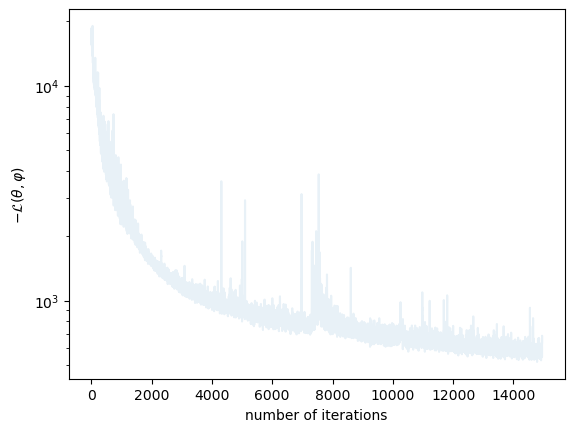

In [38]:
zoom = 50
df = pd.DataFrame()
for i, (estimator, losses) in enumerate(estimators):
    df[f'Loss {i}'] = losses[zoom:]
df = df.transpose()

fig, axs = plt.subplots()
x = np.arange(0, len(df.columns))
for run in range(len(df)):
    axs.plot(x, df.iloc[run], alpha=0.1, color='C0')
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
axs.set_yscale('log')
savefig(f"synthetic_plntree_ELBO_{len(estimators)}")

In [39]:
n_samples = 50_000

generations, encodings = generate_multiple_models(estimators, n_samples, X_base)
X_plntree, Z_plntree, O_plntree = concat_multiple_generations(generations)
X_plntree_enc, Z_plntree_enc, O_plntree_enc = concat_multiple_generations(encodings)

### Benchmark

#### Generative benchmark

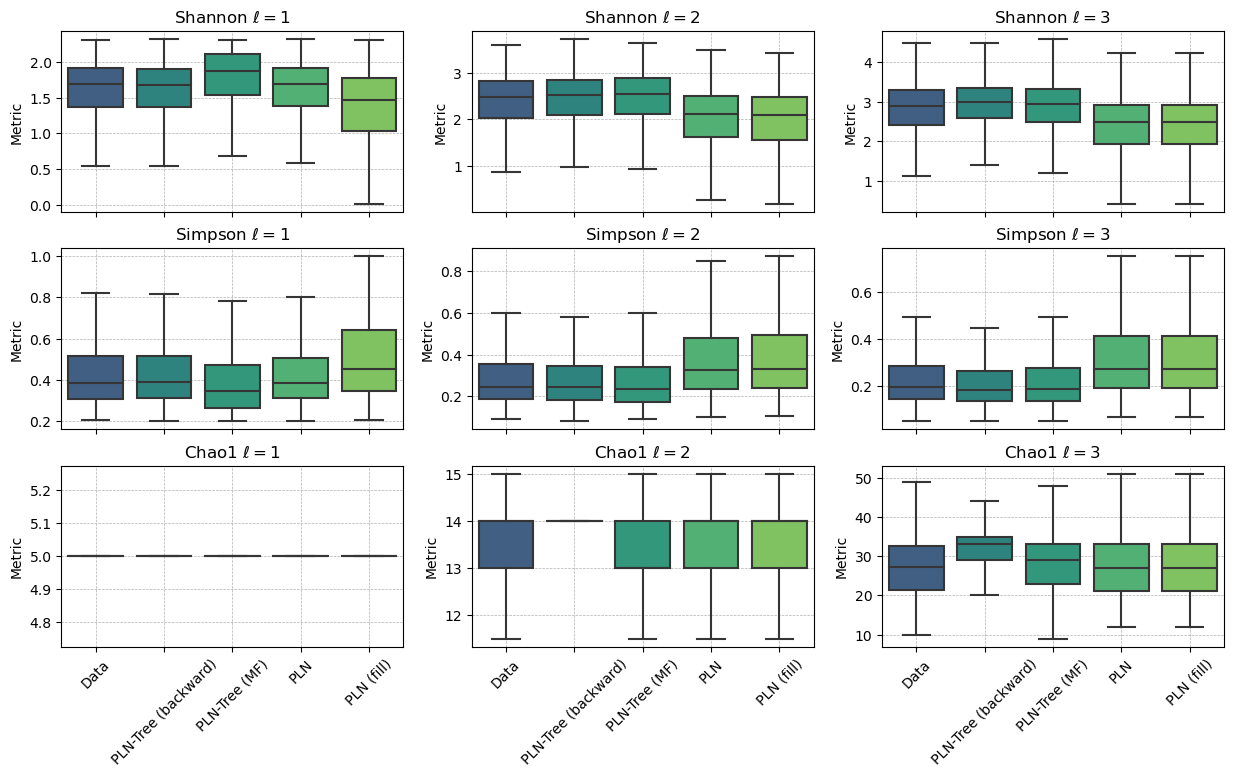

In [40]:
X_list = (X_base, X_plntree, X_meanfield, X_pln, X_pln_fill)
groups = ['Data', 'PLN-Tree (backward)', 'PLN-Tree (MF)', 'PLN', 'PLN (fill)']
colors = [viridis(0.3), viridis(0.5), viridis(0.6), viridis(0.7), viridis(0.8)]

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=base.selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
    saveName=f'synthetic_plntree_generations_{len(estimators)}'
)

In [41]:
print('Wasserstein Distance')
repeated_metric_compute(
    tree, X_base, [X_plntree, X_meanfield, X_pln_fill, X_pln], ['PLN-Tree', 'MF', 'PLN (fill)', 'PLN'], 
    n_split=25, distance=wasserstein_distance, offset_layer=base.selected_layers[0]
)

Wasserstein Distance


In [42]:
print('KL divergence')
repeated_metric_compute(
    tree, X_base, [X_plntree, X_meanfield, X_pln_fill, X_pln], ['PLN-Tree', 'MF', 'PLN (fill)', 'PLN'], 
    n_split=25, distance=kl_divergence, offset_layer=base.selected_layers[0]
)

KL divergence


In [43]:
print('Total variation')
repeated_metric_compute(
    tree, X_base, [X_plntree, X_meanfield, X_pln_fill, X_pln], ['PLN-Tree', 'MF', 'PLN (fill)', 'PLN'], 
    n_split=25, distance=total_variation, offset_layer=base.selected_layers[0]
)

Total variation


In [44]:
print('Kolmogorov-Smirnov')
repeated_metric_compute(
    tree, X_base, [X_plntree, X_meanfield, X_pln_fill, X_pln], ['PLN-Tree', 'MF', 'PLN (fill)', 'PLN'], 
    n_split=25, distance=kolmogorov_smirnov, offset_layer=base.selected_layers[0]
)

Kolmogorov-Smirnov


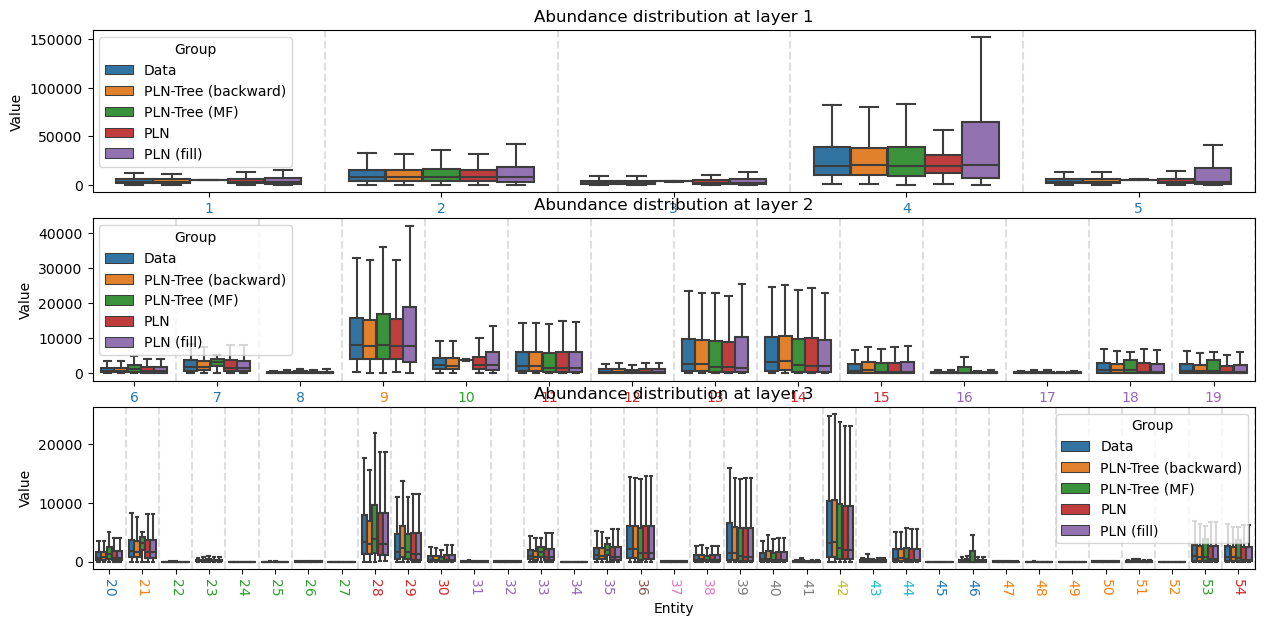

In [45]:
vizualize_entities_distributions(base, X_list, groups, title='Abundance', figsize=(15, 7))

In [67]:
X_comp = (X_plntree, X_meanfield, X_pln_fill, X_pln)
comp_names = ['PLN-Tree (backward)', 'PLN-Tree (MF)', 'PLN (fill)', 'PLN']

print('Distribution of samples distance: Wasserstein')
compute_distribution_distance(X_base, X_comp, 25, comp_names, base.K, distance=emd)

Distribution of samples distance: Wasserstein


In [68]:
X_comp = (X_plntree, X_meanfield, X_pln_fill, X_pln)
comp_names = ['PLN-Tree (backward)', 'PLN-Tree (MF)', 'PLN (fill)', 'PLN']
print('Distribution of normalized counts: KL Divergence')
def kl(p_samples, q_samples):
    p_dist = (p_samples / p_samples.sum(axis=-1, keepdims=True)).mean(axis=0)
    q_dist = (q_samples / q_samples.sum(axis=-1, keepdims=True)).mean(axis=0)
    return entropy(p_dist, q_dist)
compute_distribution_distance(X_base, X_comp, 25, comp_names, base.K, distance=kl)

Distribution of normalized counts: KL Divergence


In [69]:
print('Distribution of normalized counts: MAE')
def mae_dist(p_samples, q_samples):
    p_dist = (p_samples / p_samples.sum(axis=-1, keepdims=True)).mean(axis=0)
    q_dist = (q_samples / q_samples.sum(axis=-1, keepdims=True)).mean(axis=0)
    return np.mean(np.abs(p_dist - q_dist))
compute_distribution_distance(X_base, X_comp, 25, comp_names, base.K, distance=mae_dist)

Distribution of normalized counts: MAE


#### Identifiability

In [70]:
Z_plntree_offset = add_offset(Z_plntree, O_plntree)
Z_plntree_enc_offset = add_offset(Z_plntree_enc, O_plntree_enc.unsqueeze(-1))
Z_base_offset = add_offset(Z_base, O_base)

Z_base_multinomial = multinomial_probas(Z_base, base)
Z_plntree_multinomial = multinomial_probas(Z_plntree, base)
Z_plntree_enc_multinomial = multinomial_probas(Z_plntree_enc, base)

zooms = [
    [(-3, 3), (-22, 32), (-50, 50)], # X zooms
    [(-3, 3), (-1, 0.7), (-2, 2)], # sigma(Z) zooms
    [(-3, 3), (-10, 10), (-25, 30)] # Z zooms
]

import numpy as np
import matplotlib.pyplot as plt

# Compute the kernel density estimate for each distribution
from scipy.stats import gaussian_kde
def countour(data, ax, scale_min, scale_max, label, n_levels=5, n_points=100, color='C0'):

    # Create a meshgrid for the contour plot
    x = np.linspace(scale_min, scale_max, n_points)
    y = np.linspace(scale_min, scale_max, n_points)
    X, Y = np.meshgrid(x, y)
    
    kde_list = []
    kde = gaussian_kde(data.T)
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
    ax.contour(X, Y, Z, alpha=0.8, levels=n_levels, cmap=color, label=label)
    ax.grid(False)

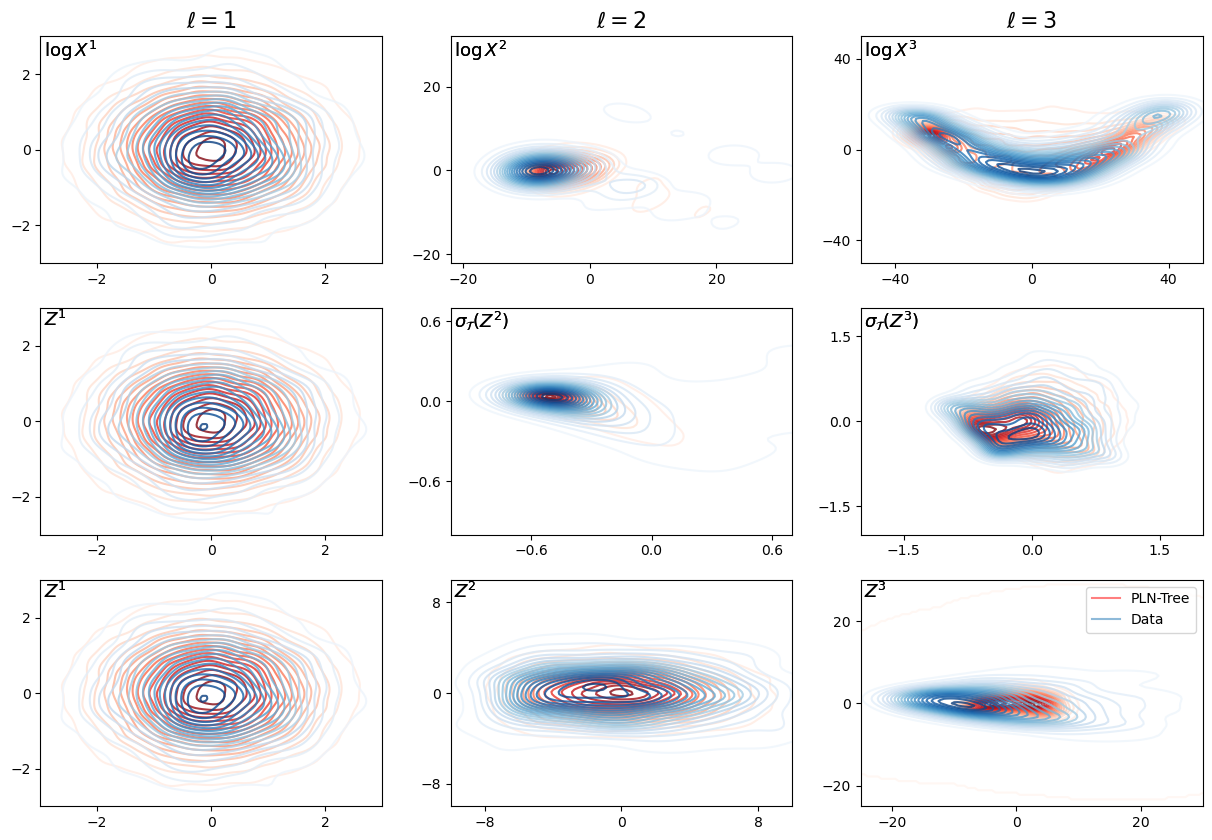

In [71]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines

def identifiability_plot(X_list, Z_soft_list, Z_list, groups, colors, chart_color, zooms):
    fig, axs = plt.subplots(3, len(base.K), figsize=(15, 10))

    for group, color, X, Z_soft, Z in zip(groups, colors, X_list, Z_soft_list, Z_list):
        for layer, mask in enumerate(base.layer_masks):
            pca = PCA(n_components=2)
            n_levels = 20
            X_pca = pca.fit_transform(torch.log(X[:, layer, mask] + 1e-6).numpy())
            Z_soft_pca = pca.fit_transform(Z_soft[:, layer, mask].numpy())
            Z_pca = pca.fit_transform(Z[:, layer, mask].numpy())
            countour(X_pca, axs[0][layer], scale_min=zooms[0][layer][0], scale_max=zooms[0][layer][1], n_levels=n_levels, n_points=100, color=color, label=group)
            countour(Z_soft_pca, axs[1][layer], scale_min=zooms[1][layer][0], scale_max=zooms[1][layer][1], n_levels=n_levels, n_points=100, color=color, label=group)
            countour(Z_pca, axs[2][layer], scale_min=zooms[2][layer][0], scale_max=zooms[2][layer][1], n_levels=n_levels, n_points=100, color=color, label=group)
            p_layer = layer + base.selected_layers[0]
            plt.text(.01, .99, f'$\log X^{p_layer}$', ha='left', va='top', transform=axs[0][layer].transAxes, fontsize=13)
            if layer == 0:
                plt.text(.01, .99, f'$Z^{p_layer}$', ha='left', va='top', transform=axs[1][layer].transAxes, fontsize=13)
            else:
                plt.text(.01, .99, '$\sigma_{\mathcal{T}}($' + f'$Z^{p_layer})$', ha='left', va='top', transform=axs[1][layer].transAxes, fontsize=13)
            plt.text(.01, .99, f'$Z^{p_layer}$', ha='left', va='top', transform=axs[2][layer].transAxes, fontsize=13)
            axs[0][layer].set_title('$\ell =$' + str(p_layer), fontsize=16)
            for ax in axs:
                ax[layer].xaxis.set_major_locator(plt.MaxNLocator(3))
                ax[layer].yaxis.set_major_locator(plt.MaxNLocator(3))
                ax[layer].tick_params(labelsize=10)
    legend_handles = [
        mlines.Line2D([], [], color=color, alpha=0.5, label=group)
        for color, group in zip(chart_color, groups)
    ]
    legend = plt.legend(handles=legend_handles)

identifiability_plot(
    (X_plntree, X_base), 
    (Z_plntree_multinomial.detach(), Z_base_multinomial.detach()), 
    (Z_plntree_offset.detach(), Z_base_offset.detach()), 
    ['PLN-Tree', 'Data'], ['Reds', 'Blues'], ['red', 'C0'], zooms)
savefig(f"synthetic_plntree_identifiability_empirical")

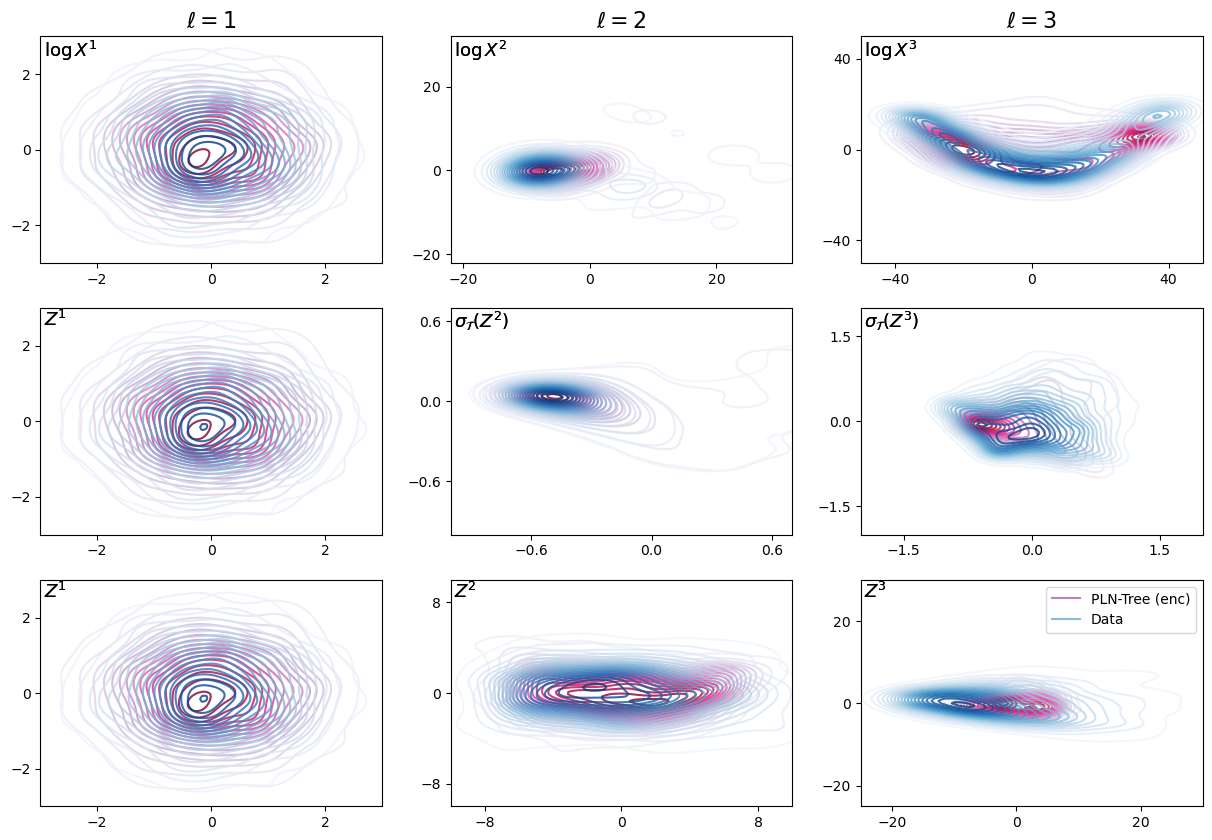

In [72]:
identifiability_plot(
    (X_plntree_enc, X_base), 
    (Z_plntree_enc_multinomial.detach(), Z_base_multinomial.detach()), 
    (Z_plntree_enc_offset.detach(), Z_base_offset.detach()), 
    ['PLN-Tree (enc)', 'Data'], ['PuRd', 'Blues'], ['purple', 'C0'], zooms)
savefig(f"synthetic_plntree_identifiability_encoding")

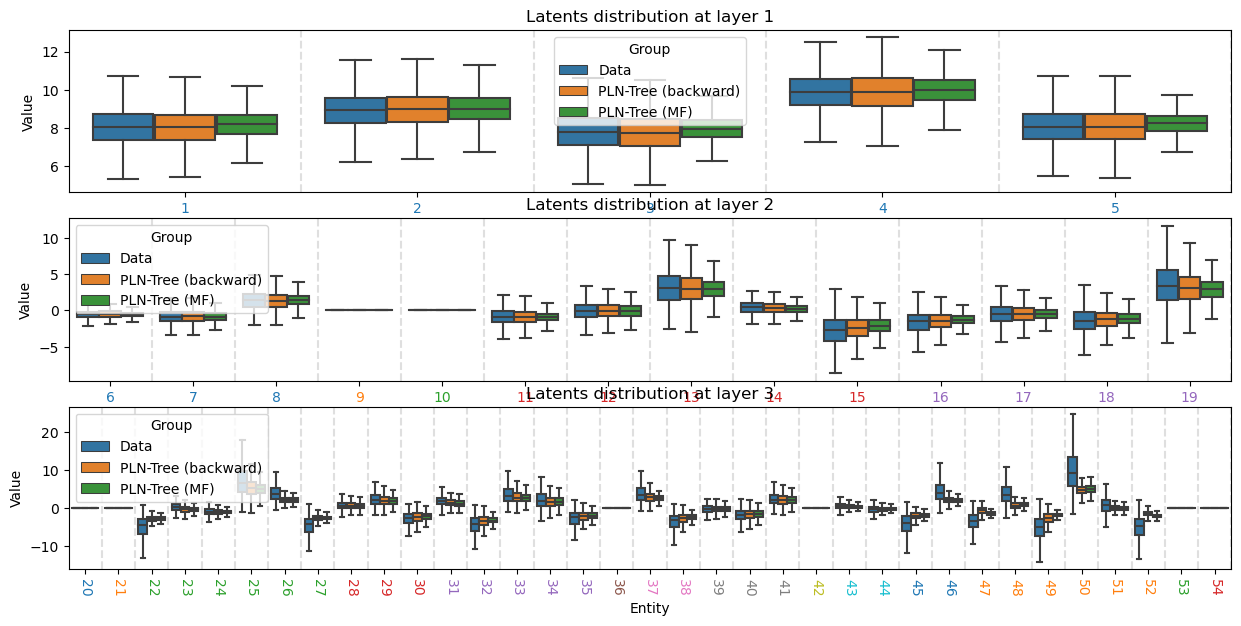

In [73]:
Z_plntree_offset = add_offset(Z_plntree, O_plntree)
Z_meanfield_offset = add_offset(Z_meanfield, O_meanfield)
Z_base_offset = add_offset(Z_base, O_base)

Z_list = (Z_base_offset.detach(), Z_plntree_offset.detach(), Z_meanfield_offset.detach())
groups = ['Data', 'PLN-Tree (backward)', 'PLN-Tree (MF)']
vizualize_entities_distributions(base, Z_list, groups, title='Latents', figsize=(15, 7))

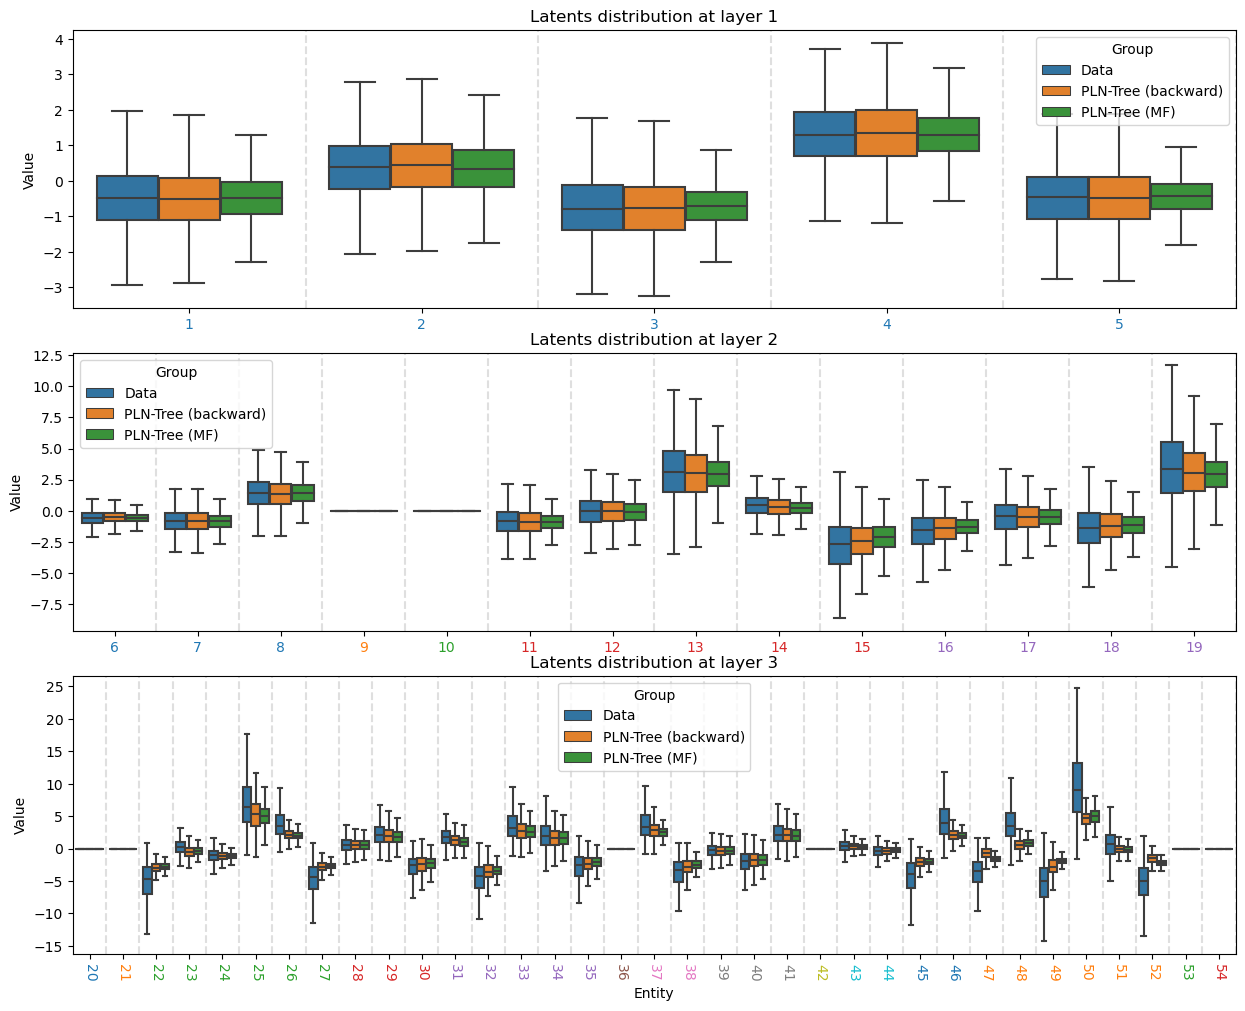

In [74]:
from plntree.utils.model_utils import Vect1OrthogonalProjectorHierarchical

Z_plntree_offset = add_offset(Z_plntree, O_plntree)
Z_meanfield_offset = add_offset(Z_meanfield, O_meanfield)
Z_base_offset = add_offset(Z_base, O_base)

Z_plntree_offset_identifiable = identifiable_projector(base, Z_plntree_offset)
Z_meanfield_offset_identifiable = identifiable_projector(base, Z_meanfield_offset)
Z_base_offset_identifiable = identifiable_projector(base, Z_base_offset)
    
Z_list = (Z_base_offset_identifiable.detach(), Z_plntree_offset_identifiable.detach(), Z_meanfield_offset_identifiable.detach())
groups = ['Data', 'PLN-Tree (backward)', 'PLN-Tree (MF)']
vizualize_entities_distributions(base, Z_list, groups, title='Latents', figsize=(15, 12))

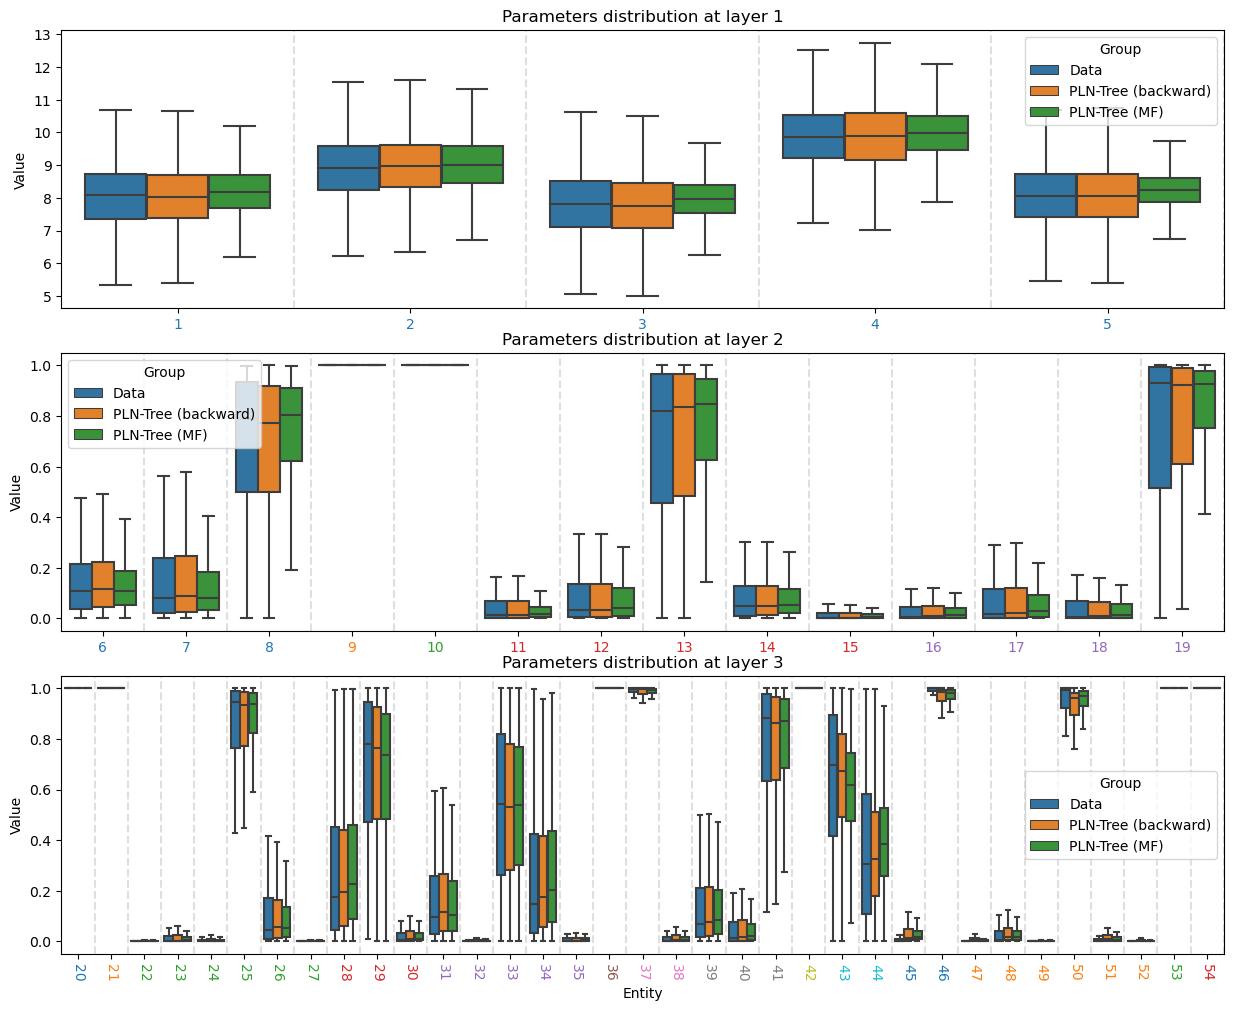

In [75]:
Z_plntree_offset = add_offset(Z_plntree, O_plntree)
Z_meanfield_offset = add_offset(Z_meanfield, O_meanfield)
Z_base_offset = add_offset(Z_base, O_base)

Z_plntree_multinomial = multinomial_probas(Z_plntree_offset, base)
Z_meanfield_multinomial = multinomial_probas(Z_meanfield_offset, base)
Z_base_multinomial = multinomial_probas(Z_base_offset, base)

Z_list = (Z_base_multinomial.detach(), Z_plntree_multinomial.detach(), Z_meanfield_multinomial.detach())
groups = ['Data', 'PLN-Tree (backward)', 'PLN-Tree (MF)']
vizualize_entities_distributions(base, Z_list, groups, title='Parameters', figsize=(15, 12))

#### Encoding benchmark

In [76]:
X_test, Z_test, O_test = base.sample(1000)

Z_meanfield_enc, O_meanfield_enc = meanfield.encode(X_test)
X_meanfield_enc = meanfield.decode(Z_meanfield_enc, O_meanfield_enc)

plntree = estimators[0][0]
Z_plntree_enc, O_plntree_enc = plntree.encode(X_test)
X_plntree_enc = plntree.decode(Z_plntree_enc, O_plntree_enc)

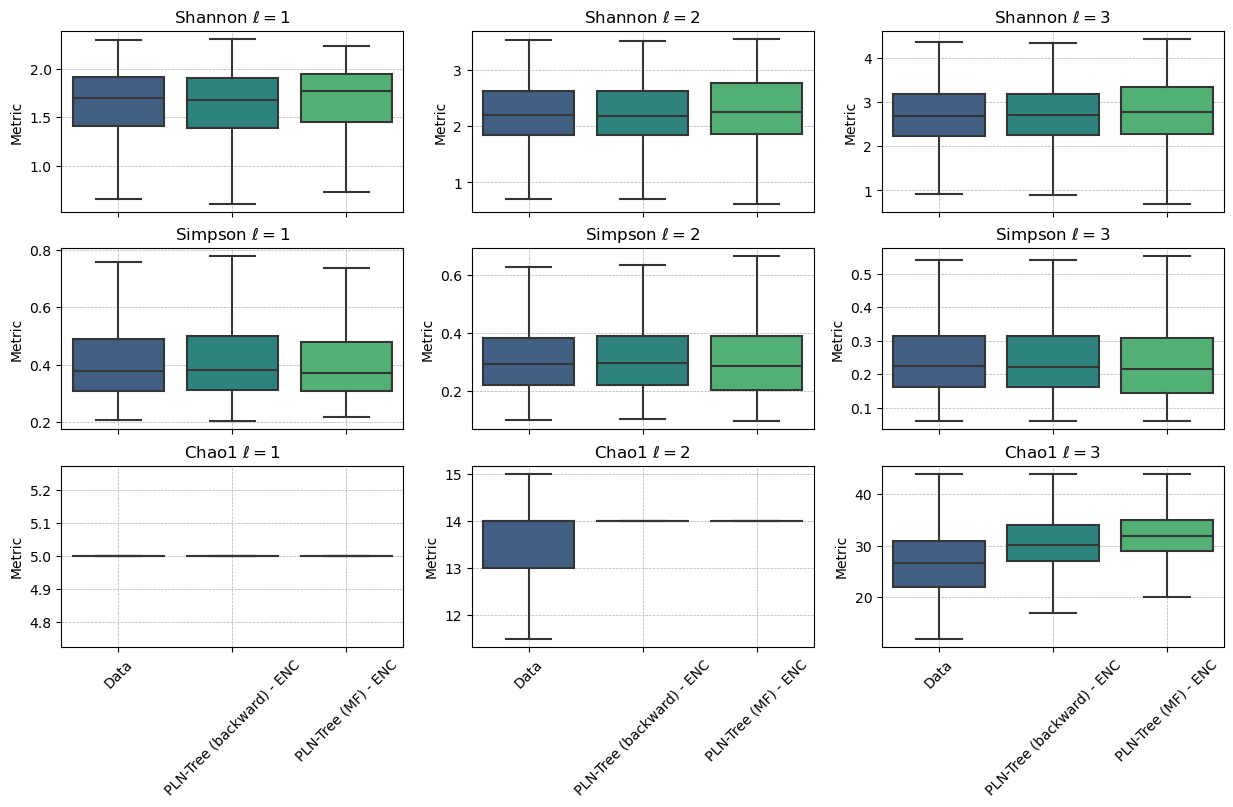

In [77]:
X_list = (X_test, X_plntree_enc, X_meanfield_enc)
groups = ['Data', 'PLN-Tree (backward) - ENC', 'PLN-Tree (MF) - ENC']
colors = [viridis(0.3), viridis(0.5), viridis(0.7)]

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=base.selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
    saveName=f'synthetic_plntree_encodings_{len(estimators)}'
)

In [78]:
print('Wasserstein Distance')
compute_alpha_distance(X_list, tree, groups, offset_layer=base.selected_layers[0], distance=wasserstein_distance)

Wasserstein Distance


In [83]:
X_comp = (X_plntree_enc, X_meanfield_enc)
groups = ['PLN-Tree (backward)', 'PLN-Tree (MF)']
for group, X_c in zip(groups, X_comp):
    print(f'Correlation against {group}:')
    correlations = correlation(X_test, X_c, base)
    for layer, corr in enumerate(correlations):
        print(f'  * layer = {layer+base.selected_layers[0]}:', corr.mean().item(), '±', corr.std().item())

Correlation against PLN-Tree (backward):
  * layer = 1: 0.9965294099159221 ± 0.010740786442815784
  * layer = 2: 0.9905486479789075 ± 0.02922617667245053
  * layer = 3: 0.9892464593710741 ± 0.028317787798716566
Correlation against PLN-Tree (MF):
  * layer = 1: 0.951405812367462 ± 0.10595594260308434
  * layer = 2: 0.9433513339280699 ± 0.12069476662037724
  * layer = 3: 0.9651050637984024 ± 0.0636688010444139


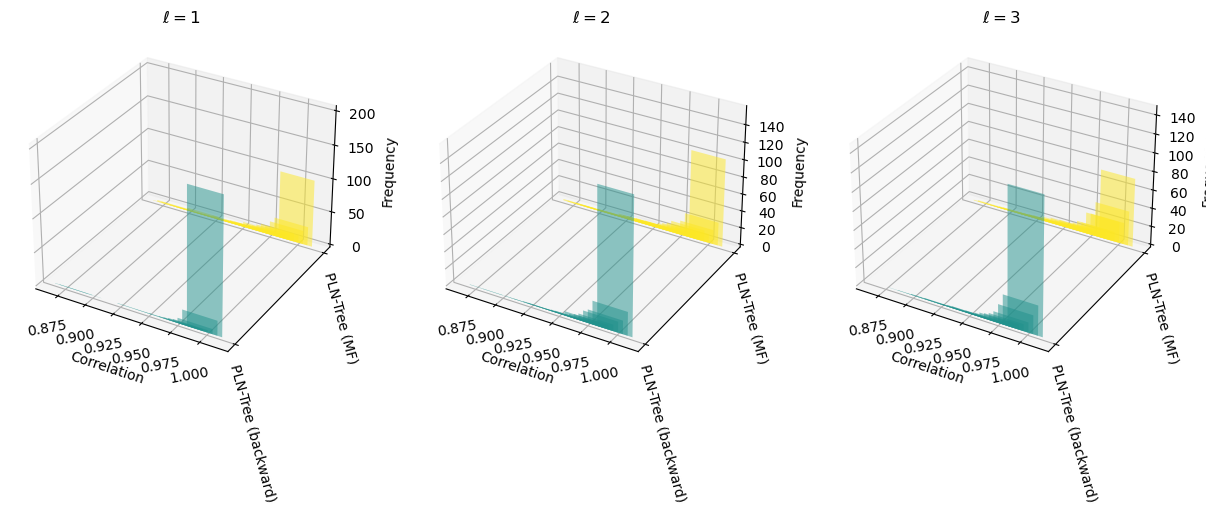

In [80]:
correlation_3d_plot(X_test, X_comp, groups, base, saveName='')

In [81]:
for group, X_c in zip(groups, X_comp):
    m = mae_tree(X_test, X_c, base.K)
    print(f'MAE against {group}:', m.mean(), f'(± {m.std()})')

MAE against PLN-Tree (backward): tensor(651.6498) (± nan)
MAE against PLN-Tree (MF): tensor(1702.8310) (± nan)


<h2 style="color:#333333; font-family:Arial, sans-serif; font-size:24px; font-weight:bold; margin-top:24px; margin-bottom:12px;">Markovian Dirichlet propagation data</h2>

### Model choice and data generation

In [15]:
seed = 1
prefix = f'synthetic_markovdirichlet_s{seed}'

seed_all(seed)

In [16]:
if not pretrained:
    K = [1, 6, 17, 40]

Saving in file ./experiments/saves/synthetic_markovdirichlet_tree.pkl


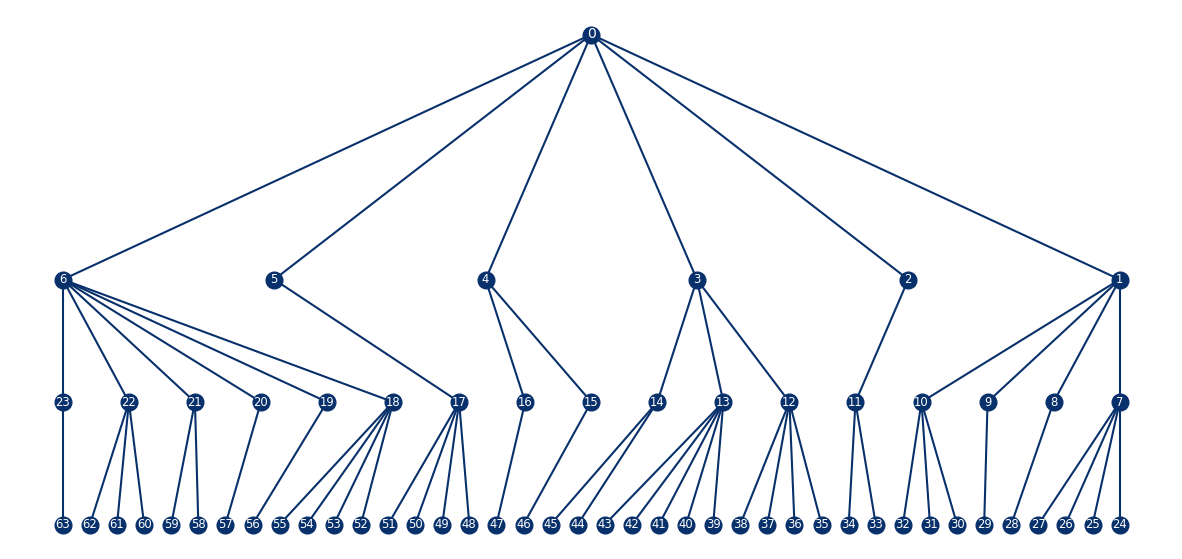

In [17]:
tree = generate_hierachical_tree(K, seed=seed)
tree.plot(legend=False, title='')

selected_layers = [1, -1]
K =  list(tree.getLayersWidth().values())[selected_layers[0]:]

savefig('synthetic_dirichlet_tree_graph')

In [18]:
G = artificial_loader.generate_adjacency_matrix(K[0], method='erdos_renyi')
Omega = artificial_loader.generate_precision_matrix(G, conditioning=0.1, correlation=0.7) * 5
mu = [-0.2, 0., -0.1, 0.2, 0.3, 0.1]
offset_total_count = 20_000
offset_probs = 0.6
    
alpha_structures = None
    
n_samples = 2_000
n_samples_test = 1_000
X = artificial_loader.generate_markov_dirichlet_hierarchical_data(
    n_samples+n_samples_test, tree, selected_layers, Omega, mu, offset_total_count, offset_probs, alpha_structures,
    seed=seed
)
X_base = X[:n_samples]
X_test = X[n_samples:n_samples+n_samples_test]

Saving in file ./experiments/saves/synthetic_markovdirichlet_dataset.pkl
Saving in file ./experiments/saves/synthetic_markovdirichlet_dataset_test.pkl


In [19]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 512
seed_all(seed)
dataset = TensorDataset(X_base, X_base)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

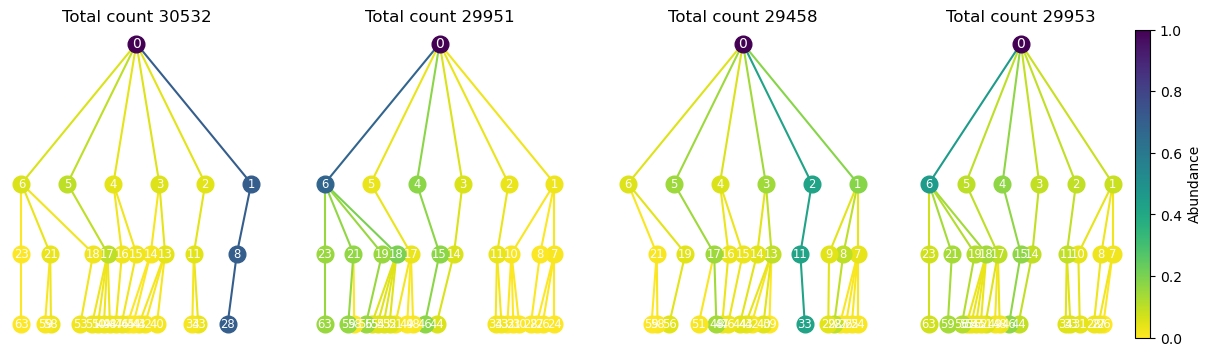

In [20]:
vizualize_samples(dataloader, tree, selected_layers, autofill=True, seed=seed)
savefig('synthetic_dirichlet_samples')

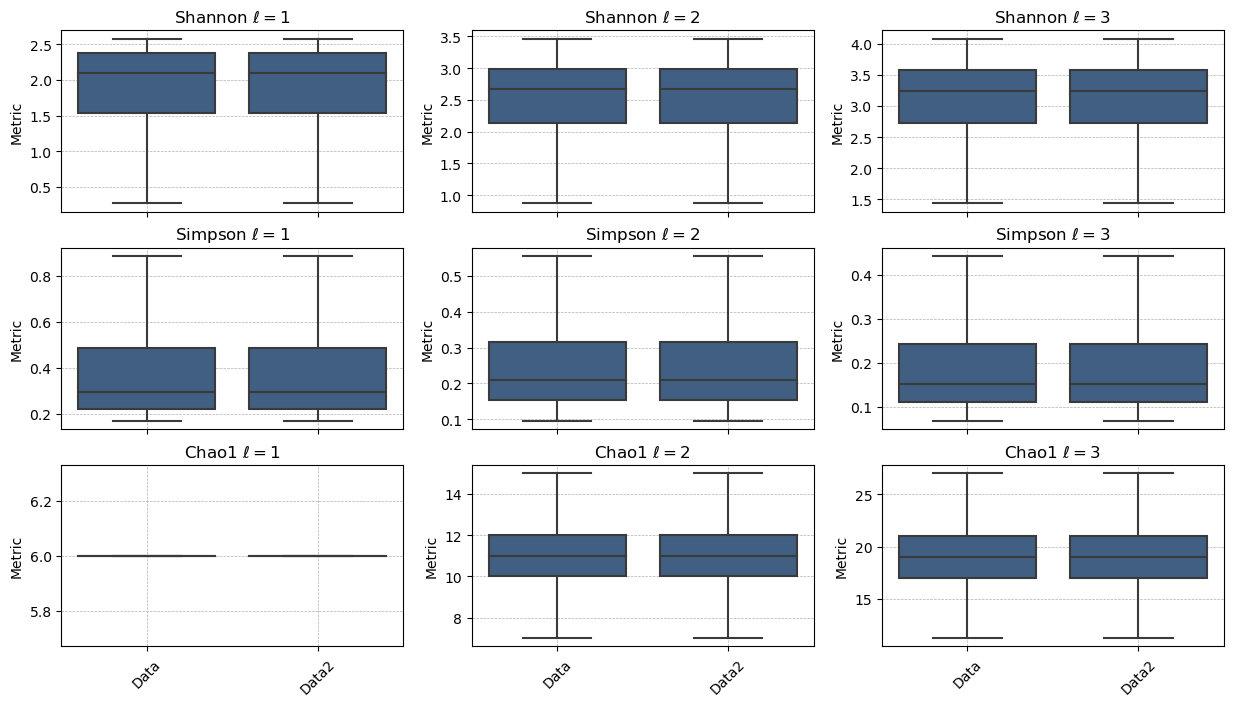

In [21]:
X_list = (X_base, X_base)
groups = ['Data', 'Data2']
colors = [viridis(0.3), viridis(0.3)]

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot'
)

### Benchmark models

#### PLN

Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 888 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 850 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 805 iterations
Likelihood: -112168.03622496128


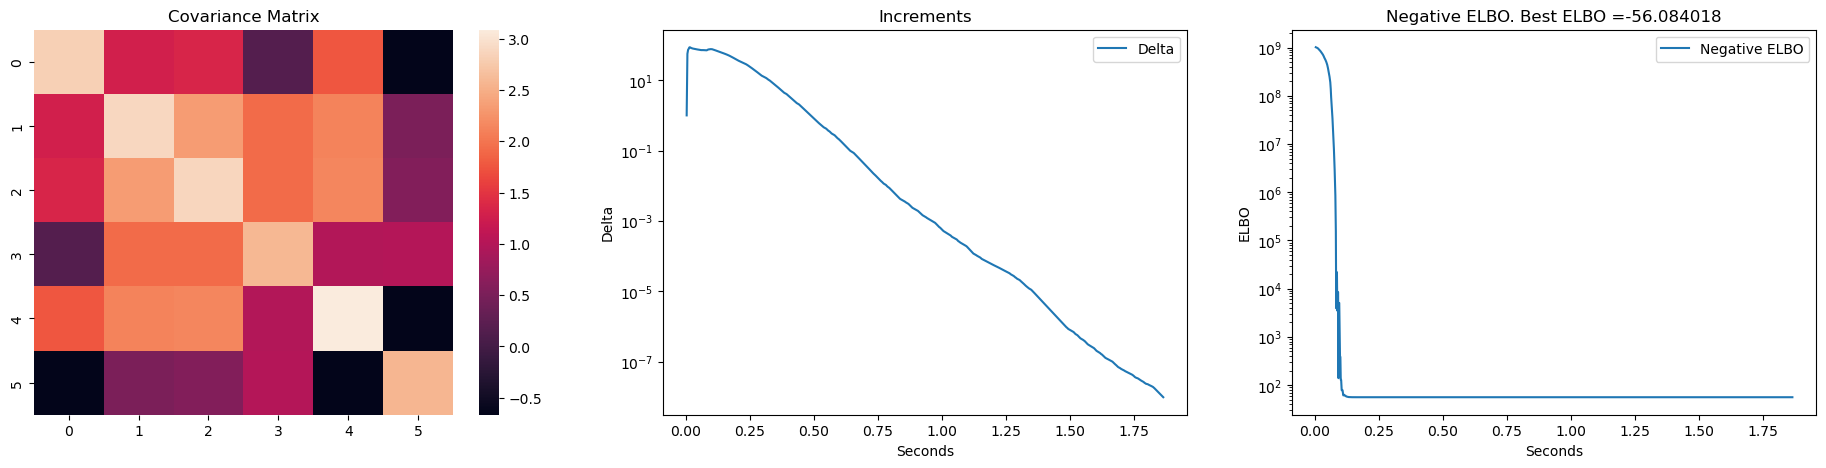

Likelihood: -207489.29797691107


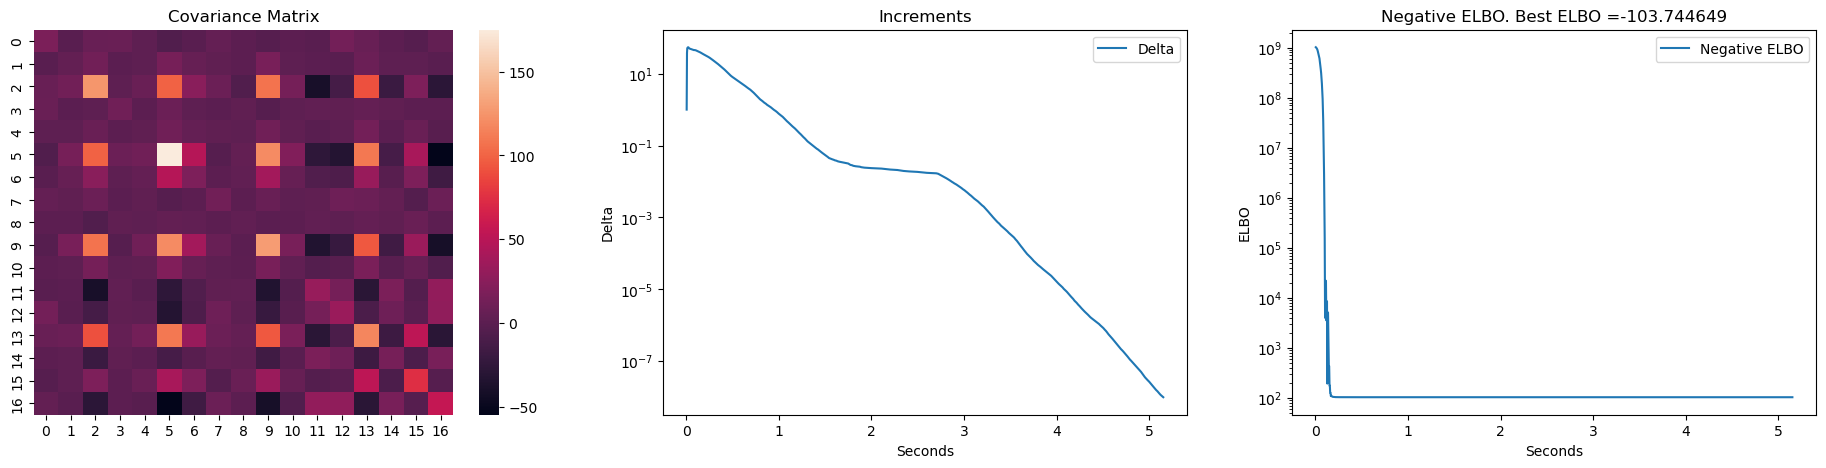

Likelihood: -332883.1703850627


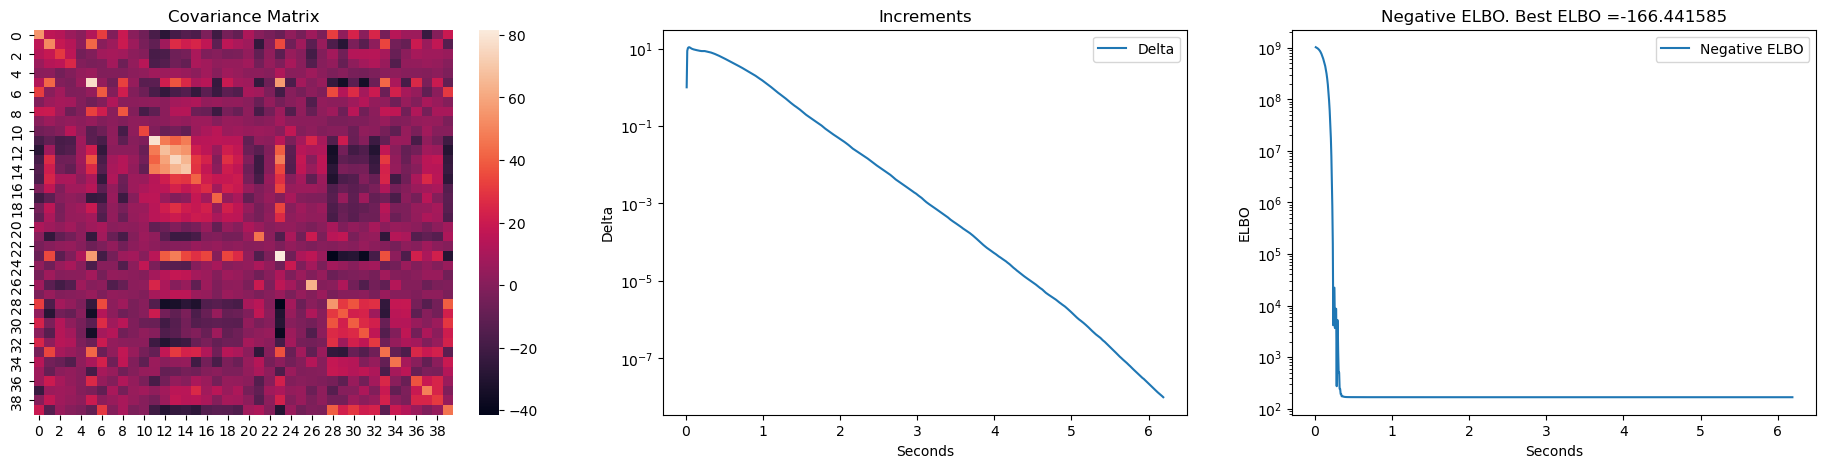

In [22]:
pln_layers = learn_pln(X_base, K, seed=seed)

In [23]:
n_samples = 50_000
X_pln, Z_pln, X_pln_fill, X_pln_enc, Z_pln_enc, X_pln_enc_fill = generate_pln_data(pln_layers, n_samples, K, selected_layers, X_base, tree, seed=seed)

Can not compute Poisson with parameters [44.32016613]
Values will be shifted to 43 to avoid overflow (only the offset is affected).
Can not compute Poisson with parameters [48.83254896 44.25136615]
Values will be shifted to 43 to avoid overflow (only the offset is affected).


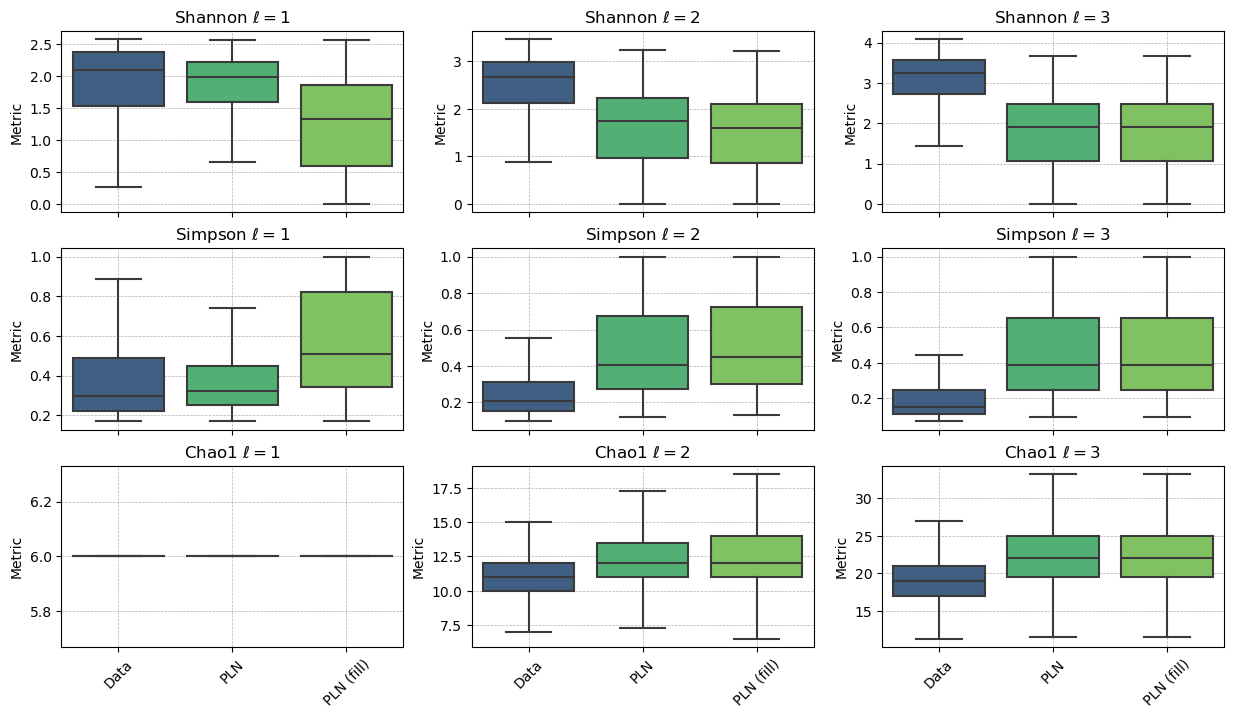

In [24]:
X_list = (X_base, X_pln, X_pln_fill)
groups = ['Data', 'PLN', 'PLN (fill)']
colors = [viridis(0.3), viridis(0.7), viridis(0.8)]

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot'
)

#### PLN-Tree Mean Field

##### Model selection

In [25]:
preprocessing = 'log'
def learn_plntree_mean_field(n_latent_layers, variational_approx_params):
    estimator = PLNTree(
        tree=tree,
        selected_layers=selected_layers,
        diag_smoothing_factor=1e-4,
        positive_fun='softplus',
        offset_method='constant',
        identifiable=True,
        variational_approx='mean_field',
        variational_approx_params=variational_approx_params,
        n_latent_layers=n_latent_layers,
        seed=seed
    )

    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    n_epoch = 15_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

In [26]:
variational_approx_params_list = [
    (1, {'n_variational_layers': 1, 'preprocessing': [preprocessing]}),
    (1, {'n_variational_layers': 2, 'preprocessing': [preprocessing]}),
    (2, {'n_variational_layers': 1, 'preprocessing': [preprocessing]}),
    (2, {'n_variational_layers': 2, 'preprocessing': [preprocessing]}),
    (3, {'n_variational_layers': 1, 'preprocessing': [preprocessing]}),
    (3, {'n_variational_layers': 2, 'preprocessing': [preprocessing]}),
]

In [27]:
meanfields = []
for n_latent_layers, variational_approx_params in variational_approx_params_list:
    try:
        meanfield, meanfield_losses = load_pkl(prefix, f'mean_field-{preprocessing}_nlatent-{n_latent_layers}-nvar-{variational_approx_params["n_variational_layers"]}')
        meanfields.append([meanfield, meanfield_losses])
    except:
        print('Learning PLN-Tree (MF)')
        print(variational_approx_params)
        meanfield, meanfield_losses = learn_plntree_mean_field(n_latent_layers, variational_approx_params)
        save_pkl((meanfield, meanfield_losses), prefix, f'mean_field-{preprocessing}_nlatent-{n_latent_layers}-nvar-{variational_approx_params["n_variational_layers"]}')
        meanfields.append([meanfield, meanfield_losses])

Learning PLN-Tree (MF)
{'n_variational_layers': 1}
[*] Epoch: 100 Average loss: 1858199.6605
[*] Epoch: 200 Average loss: 31936.4419
[*] Epoch: 300 Average loss: 12606.2990
[*] Epoch: 400 Average loss: 8085.8405
[*] Epoch: 500 Average loss: 5874.1388
[*] Epoch: 600 Average loss: 4645.1721
[*] Epoch: 700 Average loss: 3863.1642
[*] Epoch: 800 Average loss: 3346.3641
[*] Epoch: 900 Average loss: 2962.8173
[*] Epoch: 1000 Average loss: 2650.1926
[*] Epoch: 1100 Average loss: 2364.5231
[*] Epoch: 1200 Average loss: 2157.9674
[*] Epoch: 1300 Average loss: 1998.7278
[*] Epoch: 1400 Average loss: 1863.2016
[*] Epoch: 1500 Average loss: 1747.0622
[*] Epoch: 1600 Average loss: 1640.6038
[*] Epoch: 1700 Average loss: 1553.7242
[*] Epoch: 1800 Average loss: 1481.7277
[*] Epoch: 1900 Average loss: 1417.4921
[*] Epoch: 2000 Average loss: 1357.8526
[*] Epoch: 2100 Average loss: 1301.0037
[*] Epoch: 2200 Average loss: 1245.1442
[*] Epoch: 2300 Average loss: 1192.1955
[*] Epoch: 2400 Average loss: 114

[*] Epoch: 5400 Average loss: 524.7005
[*] Epoch: 5500 Average loss: 523.8671
[*] Epoch: 5600 Average loss: 521.7678
[*] Epoch: 5700 Average loss: 524.4332
[*] Epoch: 5800 Average loss: 512.1432
[*] Epoch: 5900 Average loss: 510.9504
[*] Epoch: 6000 Average loss: 512.9665
[*] Epoch: 6100 Average loss: 505.3866
[*] Epoch: 6200 Average loss: 511.2972
[*] Epoch: 6300 Average loss: 505.2158
[*] Epoch: 6400 Average loss: 504.9478
[*] Epoch: 6500 Average loss: 504.0581
[*] Epoch: 6600 Average loss: 497.6791
[*] Epoch: 6700 Average loss: 498.7717
[*] Epoch: 6800 Average loss: 498.0278
[*] Epoch: 6900 Average loss: 492.0449
[*] Epoch: 7000 Average loss: 493.0203
[*] Epoch: 7100 Average loss: 491.9283
[*] Epoch: 7200 Average loss: 492.1808
[*] Epoch: 7300 Average loss: 490.2211
[*] Epoch: 7400 Average loss: 485.3308
[*] Epoch: 7500 Average loss: 484.2276
[*] Epoch: 7600 Average loss: 487.2570
[*] Epoch: 7700 Average loss: 485.8733
[*] Epoch: 7800 Average loss: 478.8446
[*] Epoch: 7900 Average l

[*] Epoch: 10900 Average loss: 510.9663
[*] Epoch: 11000 Average loss: 509.5325
[*] Epoch: 11100 Average loss: 508.2150
[*] Epoch: 11200 Average loss: 506.5231
[*] Epoch: 11300 Average loss: 505.3048
[*] Epoch: 11400 Average loss: 504.3774
[*] Epoch: 11500 Average loss: 502.6634
[*] Epoch: 11600 Average loss: 501.6709
[*] Epoch: 11700 Average loss: 499.4122
[*] Epoch: 11800 Average loss: 497.6916
[*] Epoch: 11900 Average loss: 496.4516
[*] Epoch: 12000 Average loss: 494.7228
[*] Epoch: 12100 Average loss: 493.3969
[*] Epoch: 12200 Average loss: 491.7397
[*] Epoch: 12300 Average loss: 490.7864
[*] Epoch: 12400 Average loss: 489.4606
[*] Epoch: 12500 Average loss: 488.3378
[*] Epoch: 12600 Average loss: 487.6591
[*] Epoch: 12700 Average loss: 486.5227
[*] Epoch: 12800 Average loss: 485.6751
[*] Epoch: 12900 Average loss: 484.4279
[*] Epoch: 13000 Average loss: 483.5570
[*] Epoch: 13100 Average loss: 482.4692
[*] Epoch: 13200 Average loss: 481.7967
[*] Epoch: 13300 Average loss: 481.0560


[*] Epoch: 900 Average loss: 2516.2494
[*] Epoch: 1000 Average loss: 2205.9344
[*] Epoch: 1100 Average loss: 1995.1199
[*] Epoch: 1200 Average loss: 1830.8258
[*] Epoch: 1300 Average loss: 1692.3997
[*] Epoch: 1400 Average loss: 1578.8928
[*] Epoch: 1500 Average loss: 1488.8818
[*] Epoch: 1600 Average loss: 1413.6909
[*] Epoch: 1700 Average loss: 1348.2004
[*] Epoch: 1800 Average loss: 1288.2075
[*] Epoch: 1900 Average loss: 1235.4149
[*] Epoch: 2000 Average loss: 1187.4437
[*] Epoch: 2100 Average loss: 1142.0804
[*] Epoch: 2200 Average loss: 1103.0798
[*] Epoch: 2300 Average loss: 1068.8773
[*] Epoch: 2400 Average loss: 1039.2330
[*] Epoch: 2500 Average loss: 1010.7932
[*] Epoch: 2600 Average loss: 987.9873
[*] Epoch: 2700 Average loss: 964.6018
[*] Epoch: 2800 Average loss: 941.3650
[*] Epoch: 2900 Average loss: 919.0525
[*] Epoch: 3000 Average loss: 898.3843
[*] Epoch: 3100 Average loss: 875.9237
[*] Epoch: 3200 Average loss: 854.0234
[*] Epoch: 3300 Average loss: 836.3430
[*] Epoch

[*] Epoch: 6400 Average loss: 521.1554
[*] Epoch: 6500 Average loss: 521.9753
[*] Epoch: 6600 Average loss: 517.9208
[*] Epoch: 6700 Average loss: 515.4881
[*] Epoch: 6800 Average loss: 513.6097
[*] Epoch: 6900 Average loss: 515.4239
[*] Epoch: 7000 Average loss: 511.2650
[*] Epoch: 7100 Average loss: 513.3702
[*] Epoch: 7200 Average loss: 505.5532
[*] Epoch: 7300 Average loss: 505.7898
[*] Epoch: 7400 Average loss: 503.3789
[*] Epoch: 7500 Average loss: 504.6126
[*] Epoch: 7600 Average loss: 501.6485
[*] Epoch: 7700 Average loss: 503.4021
[*] Epoch: 7800 Average loss: 507.9191
[*] Epoch: 7900 Average loss: 498.3877
[*] Epoch: 8000 Average loss: 496.8621
[*] Epoch: 8100 Average loss: 501.0497
[*] Epoch: 8200 Average loss: 493.1132
[*] Epoch: 8300 Average loss: 492.6455
[*] Epoch: 8400 Average loss: 492.0959
[*] Epoch: 8500 Average loss: 492.4398
[*] Epoch: 8600 Average loss: 487.2792
[*] Epoch: 8700 Average loss: 486.7585
[*] Epoch: 8800 Average loss: 487.6269
[*] Epoch: 8900 Average l

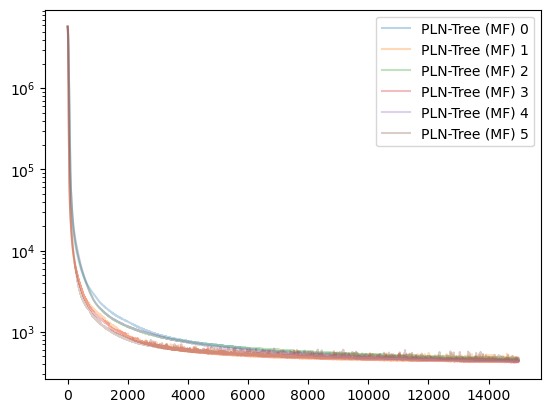

In [51]:
fig, axs = plt.subplots()
for k, (meanfield, losses) in enumerate(meanfields):
    axs.plot(losses, label=f'PLN-Tree (MF) {k}', alpha=0.3)
axs.set_yscale('log')
plt.legend()
savefig(f'{prefix}_ELBO_meanfields_selection')

In [53]:
n_samples = 15_000
meanfields_samples = {}
for key, (meanfield, losses) in enumerate(meanfields):
    X_meanfield, Z_meanfield, O_meanfield = meanfield.sample(n_samples, seed=seed)
    meanfields_samples[key] = X_meanfield

In [54]:
X_list = [X_base] + list(meanfields_samples.values())
groups = ['Data'] + [f'MF {k}' for k in range(len(meanfields))]
colors = [viridis(0.3)] + [viridis(0.3 + (k+1)/9) for k in range(len(meanfields))]

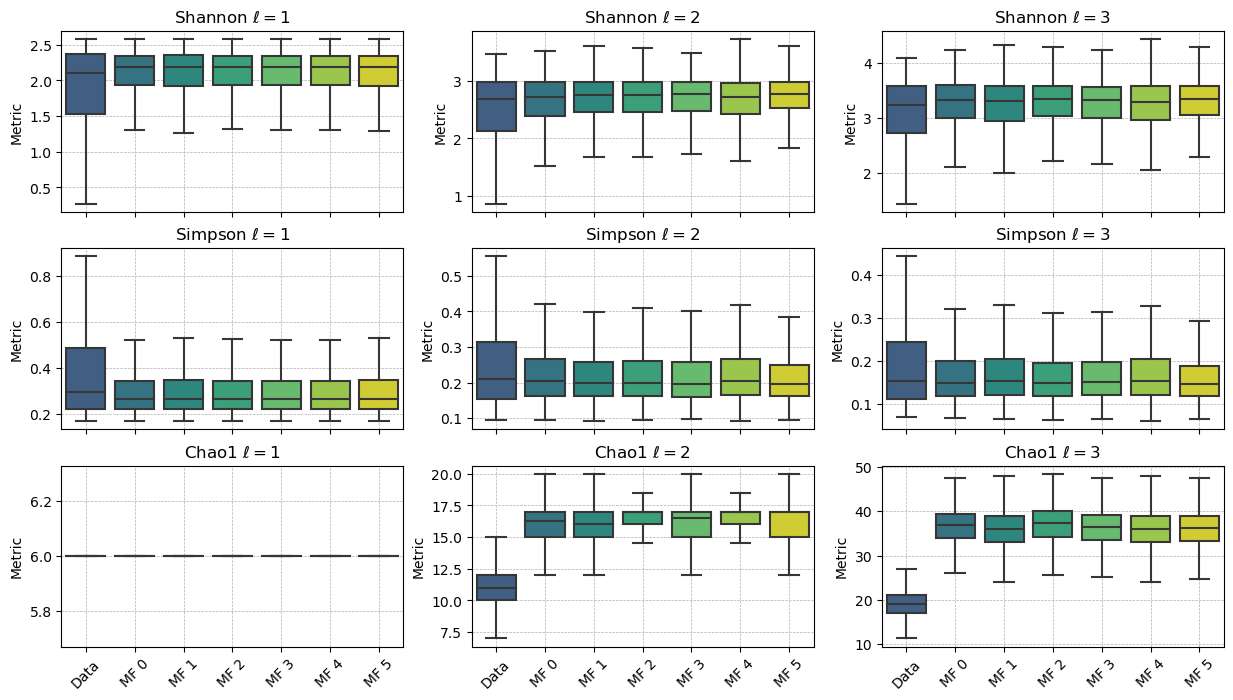

In [55]:
plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

In [56]:
print('Wasserstein Distance')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=wasserstein_distance, offset_layer=selected_layers[0], order=True
)

Wasserstein Distance


In [57]:
print('Kullback-Leilber')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kl_divergence, offset_layer=selected_layers[0], order=True
)

Kullback-Leilber


In [58]:
print('Kolmogorov-Smirnov')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kolmogorov_smirnov, offset_layer=selected_layers[0], order=True
)

Kolmogorov-Smirnov


In [59]:
print('Total variation')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=total_variation, offset_layer=selected_layers[0], order=True
)

Total variation


##### Selected model training

In [60]:
meanfield, meanfield_losses = meanfields[1]

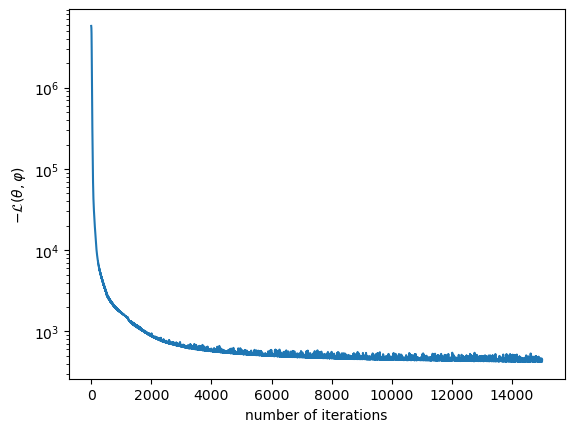

In [61]:
fig, axs = plt.subplots()
axs.plot(meanfield_losses[:])
axs.set_yscale('log')
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
savefig(f"synthetic_dirichlet_MF_ELBO")

In [62]:
n_samples = 50_000

X_meanfield, Z_meanfield, O_meanfield = meanfield.sample(n_samples, seed=seed)
Z_meanfield_enc, O_meanfield_enc = meanfield.encode(X_base, seed=seed)
X_meanfield_enc = meanfield.decode(Z_meanfield_enc, O_meanfield_enc, seed=seed)

### Trained models

##### Model selection

In [28]:
preprocessing = 'log'
def learn_plntree(n_latent_layers, variational_approx_params):
    estimator = PLNTree(
        tree=tree,
        selected_layers=selected_layers,
        diag_smoothing_factor=1e-4,
        positive_fun='softplus',
        offset_method='constant',
        identifiable=True,
        variational_approx='amortized_backward',
        variational_approx_params=variational_approx_params,
        n_latent_layers=n_latent_layers,
        seed=seed
    )

    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    n_epoch = 15_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

In [29]:
def embedder_params(embedder_type='GRU', embedding_size=16, n_embedding_layers=2, n_embedding_neurons=32, n_after_layers=2):
    params = {
        'embedder_type': embedder_type,
        'embedding_size': embedding_size,
        'n_embedding_layers': n_embedding_layers,
        'n_embedding_neurons': n_embedding_neurons,
        'n_after_layers': n_after_layers,
        'preprocessing': [preprocessing]
    }
    name = f'{preprocessing}-Emb{embedder_type}-{n_embedding_layers}x{n_embedding_neurons}to{embedding_size}-{n_after_layers}'
    return name, params

embedder_params_list = [
    embedder_params(
        embedder_type='GRU', 
        embedding_size=16, 
        n_embedding_layers=2, 
        n_embedding_neurons=32, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=2, 
        n_embedding_neurons=32, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=3, 
        n_embedding_neurons=32, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=2, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=3, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=3, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=2, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=3, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=3, 
        n_embedding_neurons=120, 
        n_after_layers=2
    ),
]

latent_prior_sizes = [1, 2]

variational_approx_params_dict = {}
for n_latent_layers in latent_prior_sizes:
    for name, embedder_params in embedder_params_list:
        variational_approx_params_dict[f'{n_latent_layers}-{name}'] = (n_latent_layers, embedder_params)

In [30]:
backwards = {}
for k, (n_latent_layers, variational_approx_params) in variational_approx_params_dict.items():
    try:
        backward, backward_losses = load_pkl(prefix, f'backward_{k}')
        backwards[k] = [backward, backward_losses]
    except:
        print('Learning PLN-Tree (MF), n latents', n_latent_layers)
        print(variational_approx_params)
        backward, backward_losses = learn_plntree(n_latent_layers, variational_approx_params)
        save_pkl((backward, backward_losses), prefix, f'backward_{k}')
        backwards[k] = [backward, backward_losses]

Learning PLN-Tree (MF), n latents 1
{'embedder_type': 'GRU', 'embedding_size': 16, 'n_embedding_layers': 2, 'n_embedding_neurons': 32, 'n_after_layers': 2}
[*] Epoch: 100 Average loss: 796789.0077
[*] Epoch: 200 Average loss: 25798.2518
[*] Epoch: 300 Average loss: 35643.0618
[*] Epoch: 400 Average loss: 18460.8809
[*] Epoch: 500 Average loss: 12150.0570
[*] Epoch: 600 Average loss: 8589.8725
[*] Epoch: 700 Average loss: 6660.5133
[*] Epoch: 800 Average loss: 5958.2132
[*] Epoch: 900 Average loss: 5573.0756
[*] Epoch: 1000 Average loss: 4860.9399
[*] Epoch: 1100 Average loss: 4573.6379
[*] Epoch: 1200 Average loss: 4376.4140
[*] Epoch: 1300 Average loss: 4109.0054
[*] Epoch: 1400 Average loss: 3973.0896
[*] Epoch: 1500 Average loss: 3967.5151
[*] Epoch: 1600 Average loss: 3513.1501
[*] Epoch: 1700 Average loss: 3427.2499
[*] Epoch: 1800 Average loss: 3307.7659
[*] Epoch: 1900 Average loss: 3279.5766
[*] Epoch: 2000 Average loss: 3247.2870
[*] Epoch: 2100 Average loss: 3131.6666
[*] Epo

[*] Epoch: 4500 Average loss: 1277.5002
[*] Epoch: 4600 Average loss: 1275.6788
[*] Epoch: 4700 Average loss: 1308.4535
[*] Epoch: 4800 Average loss: 1866.2368
[*] Epoch: 4900 Average loss: 1220.8165
[*] Epoch: 5000 Average loss: 1203.1937
[*] Epoch: 5100 Average loss: 1177.4198
[*] Epoch: 5200 Average loss: 1162.4204
[*] Epoch: 5300 Average loss: 1138.5332
[*] Epoch: 5400 Average loss: 1126.4593
[*] Epoch: 5500 Average loss: 1109.2932
[*] Epoch: 5600 Average loss: 1121.3381
[*] Epoch: 5700 Average loss: 1112.2831
[*] Epoch: 5800 Average loss: 1070.5485
[*] Epoch: 5900 Average loss: 1137.9540
[*] Epoch: 6000 Average loss: 1162.8842
[*] Epoch: 6100 Average loss: 1069.2095
[*] Epoch: 6200 Average loss: 1139.4009
[*] Epoch: 6300 Average loss: 1068.1811
[*] Epoch: 6400 Average loss: 1101.2315
[*] Epoch: 6500 Average loss: 1041.8010
[*] Epoch: 6600 Average loss: 1952.5333
[*] Epoch: 6700 Average loss: 1077.6974
[*] Epoch: 6800 Average loss: 1048.8523
[*] Epoch: 6900 Average loss: 1018.1744


[*] Epoch: 9500 Average loss: 1136.1099
[*] Epoch: 9600 Average loss: 1122.5298
[*] Epoch: 9700 Average loss: 1155.5572
[*] Epoch: 9800 Average loss: 1151.8269
[*] Epoch: 9900 Average loss: 1116.7367
[*] Epoch: 10000 Average loss: 1070.9636
[*] Epoch: 10100 Average loss: 1082.9581
[*] Epoch: 10200 Average loss: 1090.0543
[*] Epoch: 10300 Average loss: 1104.8194
[*] Epoch: 10400 Average loss: 1040.6505
[*] Epoch: 10500 Average loss: 1043.8739
[*] Epoch: 10600 Average loss: 1014.7570
[*] Epoch: 10700 Average loss: 1032.2665
[*] Epoch: 10800 Average loss: 1038.3481
[*] Epoch: 10900 Average loss: 1010.2605
[*] Epoch: 11000 Average loss: 1030.4711
[*] Epoch: 11100 Average loss: 1264.9029
[*] Epoch: 11200 Average loss: 1069.4994
[*] Epoch: 11300 Average loss: 1008.1407
[*] Epoch: 11400 Average loss: 967.8087
[*] Epoch: 11500 Average loss: 962.3245
[*] Epoch: 11600 Average loss: 931.3273
[*] Epoch: 11700 Average loss: 925.4657
[*] Epoch: 11800 Average loss: 915.2249
[*] Epoch: 11900 Average l

[*] Epoch: 14500 Average loss: 830.4331
[*] Epoch: 14600 Average loss: 628.5159
[*] Epoch: 14700 Average loss: 643.5217
[*] Epoch: 14800 Average loss: 598.7267
[*] Epoch: 14900 Average loss: 601.4349
[*] Epoch: 14999 Average loss: 567.1978
Saving in file ./experiments/saves/synthetic_markovdirichlet_backward_1-EmbGRU-2x64to32-2.pkl
Learning PLN-Tree (MF), n latents 1
{'embedder_type': 'GRU', 'embedding_size': 32, 'n_embedding_layers': 3, 'n_embedding_neurons': 64, 'n_after_layers': 2}
[*] Epoch: 100 Average loss: 528054.6120
[*] Epoch: 200 Average loss: 7693.9857
[*] Epoch: 300 Average loss: 5761.6512
[*] Epoch: 400 Average loss: 4620.6877
[*] Epoch: 500 Average loss: 3843.6039
[*] Epoch: 600 Average loss: 3775.2010
[*] Epoch: 700 Average loss: 3816.0730
[*] Epoch: 800 Average loss: 3165.4479
[*] Epoch: 900 Average loss: 3302.2728
[*] Epoch: 1000 Average loss: 2584.7152
[*] Epoch: 1100 Average loss: 2429.3079
[*] Epoch: 1200 Average loss: 2280.9386
[*] Epoch: 1300 Average loss: 2211.05

[*] Epoch: 3900 Average loss: 884.3414
[*] Epoch: 4000 Average loss: 961.1936
[*] Epoch: 4100 Average loss: 849.6899
[*] Epoch: 4200 Average loss: 827.6586
[*] Epoch: 4300 Average loss: 901.0991
[*] Epoch: 4400 Average loss: 867.1007
[*] Epoch: 4500 Average loss: 875.0498
[*] Epoch: 4600 Average loss: 852.6499
[*] Epoch: 4700 Average loss: 810.5423
[*] Epoch: 4800 Average loss: 852.7948
[*] Epoch: 4900 Average loss: 792.4324
[*] Epoch: 5000 Average loss: 746.8045
[*] Epoch: 5100 Average loss: 798.4310
[*] Epoch: 5200 Average loss: 770.3959
[*] Epoch: 5300 Average loss: 805.6505
[*] Epoch: 5400 Average loss: 773.1329
[*] Epoch: 5500 Average loss: 703.7738
[*] Epoch: 5600 Average loss: 796.0661
[*] Epoch: 5700 Average loss: 909.2823
[*] Epoch: 5800 Average loss: 807.0910
[*] Epoch: 5900 Average loss: 804.7704
[*] Epoch: 6000 Average loss: 702.0229
[*] Epoch: 6100 Average loss: 785.4941
[*] Epoch: 6200 Average loss: 740.8599
[*] Epoch: 6300 Average loss: 736.4791
[*] Epoch: 6400 Average l

[*] Epoch: 9000 Average loss: 743.3419
[*] Epoch: 9100 Average loss: 687.0434
[*] Epoch: 9200 Average loss: 712.0751
[*] Epoch: 9300 Average loss: 689.1576
[*] Epoch: 9400 Average loss: 756.5478
[*] Epoch: 9500 Average loss: 751.1216
[*] Epoch: 9600 Average loss: 701.9228
[*] Epoch: 9700 Average loss: 607.6863
[*] Epoch: 9800 Average loss: 657.4483
[*] Epoch: 9900 Average loss: 605.7744
[*] Epoch: 10000 Average loss: 1037.1105
[*] Epoch: 10100 Average loss: 671.2375
[*] Epoch: 10200 Average loss: 663.9091
[*] Epoch: 10300 Average loss: 677.8087
[*] Epoch: 10400 Average loss: 702.7368
[*] Epoch: 10500 Average loss: 634.4427
[*] Epoch: 10600 Average loss: 609.1682
[*] Epoch: 10700 Average loss: 619.7525
[*] Epoch: 10800 Average loss: 594.9167
[*] Epoch: 10900 Average loss: 665.6248
[*] Epoch: 11000 Average loss: 735.1263
[*] Epoch: 11100 Average loss: 667.8693
[*] Epoch: 11200 Average loss: 642.3463
[*] Epoch: 11300 Average loss: 633.8657
[*] Epoch: 11400 Average loss: 568.7537
[*] Epoch

[*] Epoch: 14000 Average loss: 555.1003
[*] Epoch: 14100 Average loss: 499.9384
[*] Epoch: 14200 Average loss: 513.0884
[*] Epoch: 14300 Average loss: 536.4234
[*] Epoch: 14400 Average loss: 514.6215
[*] Epoch: 14500 Average loss: 488.8798
[*] Epoch: 14600 Average loss: 586.1066
[*] Epoch: 14700 Average loss: 543.5756
[*] Epoch: 14800 Average loss: 510.3030
[*] Epoch: 14900 Average loss: 519.3963
[*] Epoch: 14999 Average loss: 482.9911
Saving in file ./experiments/saves/synthetic_markovdirichlet_backward_1-EmbGRU-3x120to60-2.pkl
Learning PLN-Tree (MF), n latents 2
{'embedder_type': 'GRU', 'embedding_size': 16, 'n_embedding_layers': 2, 'n_embedding_neurons': 32, 'n_after_layers': 2}
[*] Epoch: 100 Average loss: 827051.6057
[*] Epoch: 200 Average loss: 7870.4382
[*] Epoch: 300 Average loss: 5748.7779
[*] Epoch: 400 Average loss: 5019.8539
[*] Epoch: 500 Average loss: 4627.1168
[*] Epoch: 600 Average loss: 4421.3808
[*] Epoch: 700 Average loss: 4113.9183
[*] Epoch: 800 Average loss: 3810.

[*] Epoch: 3200 Average loss: 1687.0013
[*] Epoch: 3300 Average loss: 1604.1220
[*] Epoch: 3400 Average loss: 1560.4604
[*] Epoch: 3500 Average loss: 1536.5755
[*] Epoch: 3600 Average loss: 1552.4554
[*] Epoch: 3700 Average loss: 1528.2735
[*] Epoch: 3800 Average loss: 1488.6635
[*] Epoch: 3900 Average loss: 1423.6724
[*] Epoch: 4000 Average loss: 1416.0106
[*] Epoch: 4100 Average loss: 1411.4034
[*] Epoch: 4200 Average loss: 1366.8750
[*] Epoch: 4300 Average loss: 1320.0994
[*] Epoch: 4400 Average loss: 1298.3152
[*] Epoch: 4500 Average loss: 1338.4810
[*] Epoch: 4600 Average loss: 1344.3160
[*] Epoch: 4700 Average loss: 1217.6825
[*] Epoch: 4800 Average loss: 1240.9980
[*] Epoch: 4900 Average loss: 1260.3015
[*] Epoch: 5000 Average loss: 1184.1103
[*] Epoch: 5100 Average loss: 1162.1650
[*] Epoch: 5200 Average loss: 1105.9840
[*] Epoch: 5300 Average loss: 1157.5215
[*] Epoch: 5400 Average loss: 1086.8312
[*] Epoch: 5500 Average loss: 1100.7980
[*] Epoch: 5600 Average loss: 1232.4031


[*] Epoch: 8200 Average loss: 1137.9096
[*] Epoch: 8300 Average loss: 1122.7242
[*] Epoch: 8400 Average loss: 1188.8930
[*] Epoch: 8500 Average loss: 1117.0593
[*] Epoch: 8600 Average loss: 1140.5279
[*] Epoch: 8700 Average loss: 1111.2946
[*] Epoch: 8800 Average loss: 1037.5881
[*] Epoch: 8900 Average loss: 1061.9970
[*] Epoch: 9000 Average loss: 1053.7395
[*] Epoch: 9100 Average loss: 1037.4765
[*] Epoch: 9200 Average loss: 1029.2540
[*] Epoch: 9300 Average loss: 1049.6775
[*] Epoch: 9400 Average loss: 1097.7542
[*] Epoch: 9500 Average loss: 1039.8690
[*] Epoch: 9600 Average loss: 1022.7280
[*] Epoch: 9700 Average loss: 1041.5684
[*] Epoch: 9800 Average loss: 1028.9139
[*] Epoch: 9900 Average loss: 979.9182
[*] Epoch: 10000 Average loss: 951.9878
[*] Epoch: 10100 Average loss: 976.4753
[*] Epoch: 10200 Average loss: 957.1586
[*] Epoch: 10300 Average loss: 956.1881
[*] Epoch: 10400 Average loss: 954.4695
[*] Epoch: 10500 Average loss: 976.1031
[*] Epoch: 10600 Average loss: 953.6631
[

[*] Epoch: 13200 Average loss: 563.8261
[*] Epoch: 13300 Average loss: 580.2956
[*] Epoch: 13400 Average loss: 550.2908
[*] Epoch: 13500 Average loss: 544.2133
[*] Epoch: 13600 Average loss: 530.3279
[*] Epoch: 13700 Average loss: 562.7147
[*] Epoch: 13800 Average loss: 558.8127
[*] Epoch: 13900 Average loss: 559.6031
[*] Epoch: 14000 Average loss: 605.7788
[*] Epoch: 14100 Average loss: 524.7409
[*] Epoch: 14200 Average loss: 529.2641
[*] Epoch: 14300 Average loss: 529.3106
[*] Epoch: 14400 Average loss: 541.3818
[*] Epoch: 14500 Average loss: 565.7431
[*] Epoch: 14600 Average loss: 533.8358
[*] Epoch: 14700 Average loss: 518.2662
[*] Epoch: 14800 Average loss: 541.3649
[*] Epoch: 14900 Average loss: 525.9663
[*] Epoch: 14999 Average loss: 539.2879
Saving in file ./experiments/saves/synthetic_markovdirichlet_backward_2-EmbGRU-2x64to32-2.pkl
Learning PLN-Tree (MF), n latents 2
{'embedder_type': 'GRU', 'embedding_size': 32, 'n_embedding_layers': 3, 'n_embedding_neurons': 64, 'n_after_la

[*] Epoch: 2600 Average loss: 1429.7038
[*] Epoch: 2700 Average loss: 1438.7484
[*] Epoch: 2800 Average loss: 1307.2028
[*] Epoch: 2900 Average loss: 1424.5072
[*] Epoch: 3000 Average loss: 1399.1315
[*] Epoch: 3100 Average loss: 1255.9295
[*] Epoch: 3200 Average loss: 1265.0030
[*] Epoch: 3300 Average loss: 1218.2624
[*] Epoch: 3400 Average loss: 1477.1327
[*] Epoch: 3500 Average loss: 1422.0714
[*] Epoch: 3600 Average loss: 1343.7008
[*] Epoch: 3700 Average loss: 1095.1750
[*] Epoch: 3800 Average loss: 1209.3662
[*] Epoch: 3900 Average loss: 1159.1947
[*] Epoch: 4000 Average loss: 1049.4478
[*] Epoch: 4100 Average loss: 1169.7663
[*] Epoch: 4200 Average loss: 1090.1212
[*] Epoch: 4300 Average loss: 1012.5710
[*] Epoch: 4400 Average loss: 944.8032
[*] Epoch: 4500 Average loss: 1052.7574
[*] Epoch: 4600 Average loss: 1120.2811
[*] Epoch: 4700 Average loss: 1093.4958
[*] Epoch: 4800 Average loss: 1118.8884
[*] Epoch: 4900 Average loss: 1103.7603
[*] Epoch: 5000 Average loss: 1120.1690
[

[*] Epoch: 7700 Average loss: 702.8300
[*] Epoch: 7800 Average loss: 787.4335
[*] Epoch: 7900 Average loss: 680.1579
[*] Epoch: 8000 Average loss: 788.8634
[*] Epoch: 8100 Average loss: 822.1458
[*] Epoch: 8200 Average loss: 844.9514
[*] Epoch: 8300 Average loss: 731.4968
[*] Epoch: 8400 Average loss: 710.6554
[*] Epoch: 8500 Average loss: 669.9861
[*] Epoch: 8600 Average loss: 691.4775
[*] Epoch: 8700 Average loss: 663.7304
[*] Epoch: 8800 Average loss: 669.7220
[*] Epoch: 8900 Average loss: 653.7708
[*] Epoch: 9000 Average loss: 1685.0345
[*] Epoch: 9100 Average loss: 1141.5851
[*] Epoch: 9200 Average loss: 1043.1094
[*] Epoch: 9300 Average loss: 894.8681
[*] Epoch: 9400 Average loss: 936.0285
[*] Epoch: 9500 Average loss: 813.3425
[*] Epoch: 9600 Average loss: 837.1373
[*] Epoch: 9700 Average loss: 854.7676
[*] Epoch: 9800 Average loss: 726.5908
[*] Epoch: 9900 Average loss: 754.5907
[*] Epoch: 10000 Average loss: 735.9895
[*] Epoch: 10100 Average loss: 734.4670
[*] Epoch: 10200 Ave

[*] Epoch: 12800 Average loss: 449.2073
[*] Epoch: 12900 Average loss: 449.2317
[*] Epoch: 13000 Average loss: 489.3296
[*] Epoch: 13100 Average loss: 482.6932
[*] Epoch: 13200 Average loss: 430.8892
[*] Epoch: 13300 Average loss: 401.8544
[*] Epoch: 13400 Average loss: 425.9076
[*] Epoch: 13500 Average loss: 437.1169
[*] Epoch: 13600 Average loss: 423.3780
[*] Epoch: 13700 Average loss: 469.3439
[*] Epoch: 13800 Average loss: 429.6471
[*] Epoch: 13900 Average loss: 444.1063
[*] Epoch: 14000 Average loss: 433.1581
[*] Epoch: 14100 Average loss: 487.9973
[*] Epoch: 14200 Average loss: 393.1972
[*] Epoch: 14300 Average loss: 417.6420
[*] Epoch: 14400 Average loss: 447.1744
[*] Epoch: 14500 Average loss: 471.2926
[*] Epoch: 14600 Average loss: 436.2630
[*] Epoch: 14700 Average loss: 415.3527
[*] Epoch: 14800 Average loss: 377.3390
[*] Epoch: 14900 Average loss: 445.2745
[*] Epoch: 14999 Average loss: 460.2706
Saving in file ./experiments/saves/synthetic_markovdirichlet_backward_2-EmbGRU-3

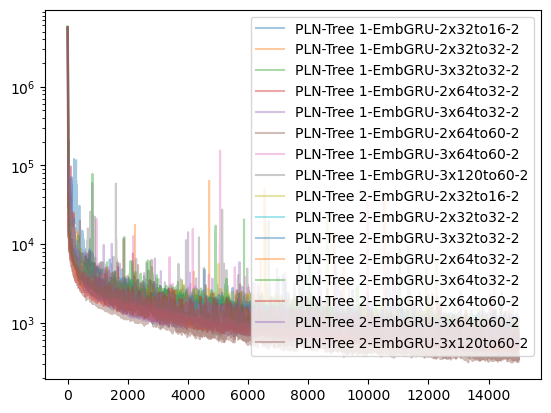

In [32]:
fig, axs = plt.subplots()
for k, (backward, losses) in backwards.items():
    axs.plot(losses, label=f'PLN-Tree {k}', alpha=0.4)
axs.set_yscale('log')
plt.legend()
savefig(f'{prefix}_ELBO_backwards_selection')

In [35]:
n_samples = 15_000
backwards_samples = {}
for key, (backward, losses) in backwards.items():
    X_plntree, Z_plntree, O_plntree = backward.sample(n_samples, seed=seed)
    backwards_samples[key] = X_plntree

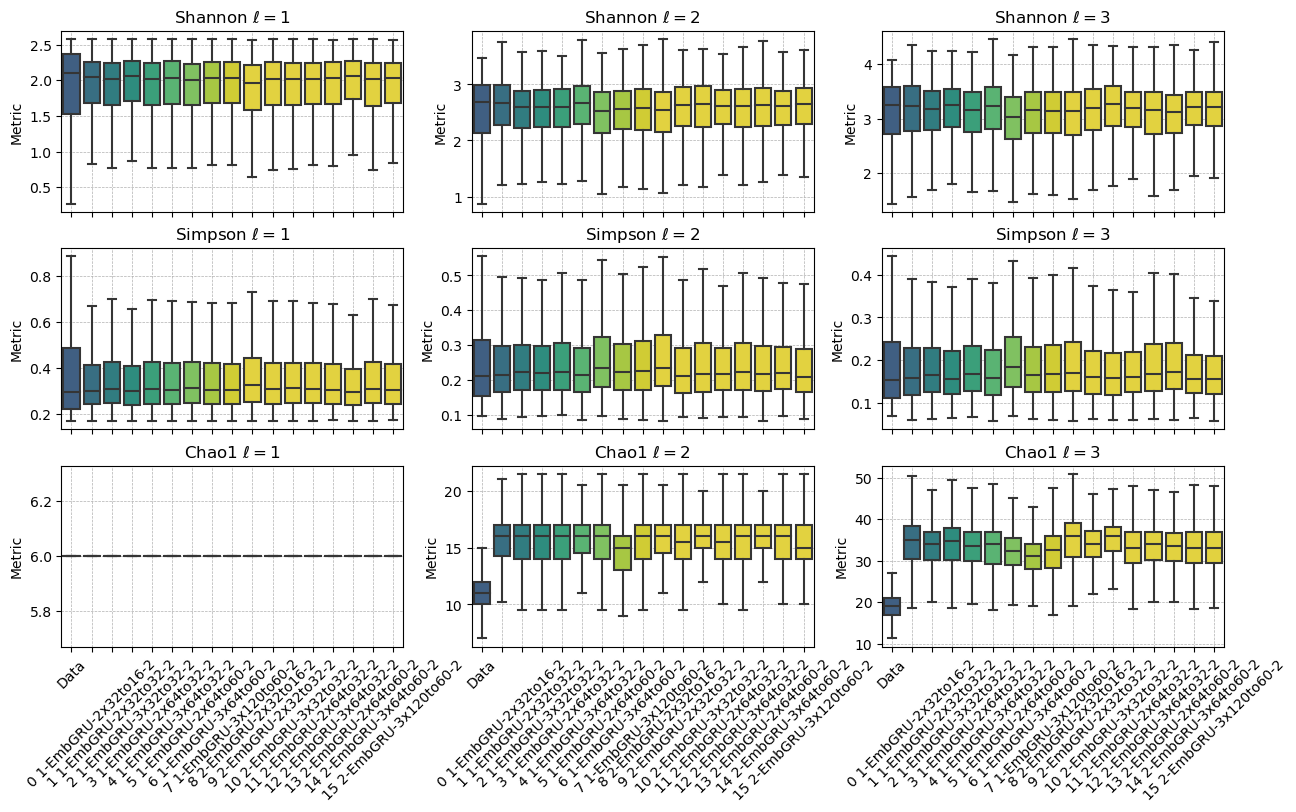

In [42]:
X_list = [X_base] + list(backwards_samples.values())
groups = ['Data'] + [f'{k} {key}' for k, key in enumerate(backwards.keys())]
colors = [viridis(0.3)] + [viridis(0.3 + (k+1)/12) for k in range(len(backwards))]
plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

In [43]:
print('Wasserstein Distance')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=wasserstein_distance, offset_layer=selected_layers[0], order=True
)

Wasserstein Distance


In [44]:
print('Kullback-Leilbler')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kl_divergence, offset_layer=selected_layers[0], order=True
)

Kullback-Leilbler


In [45]:
print('Kolmogorov-Smirnov')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kolmogorov_smirnov, offset_layer=selected_layers[0], order=True
)

Kolmogorov-Smirnov


In [46]:
print('Total Variation')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=total_variation, offset_layer=selected_layers[0], order=True
)

Total Variation


##### Selected model training

In [99]:
plntree, plntree_losses = backwards['1-EmbGRU-3x120to60-2']

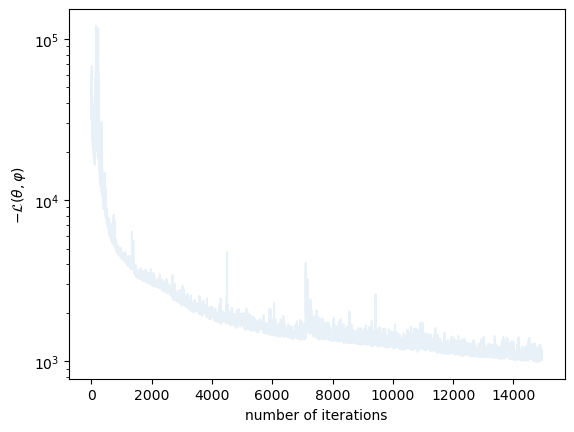

In [76]:
fig, axs = plt.subplots()
x = np.arange(0, len(df.columns))
axs.plot(plntree_losses, alpha=0.8, color='C0')
axs.set_yscale('log')
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
savefig(f"synthetic_dirichlet_ELBO_{len(estimators)}")

In [87]:
n_samples = 50_000

X_plntree, Z_plntree, O_plntree = plntree.sample(generations, seed=seed)

### Benchmark

#### Generative benchmark

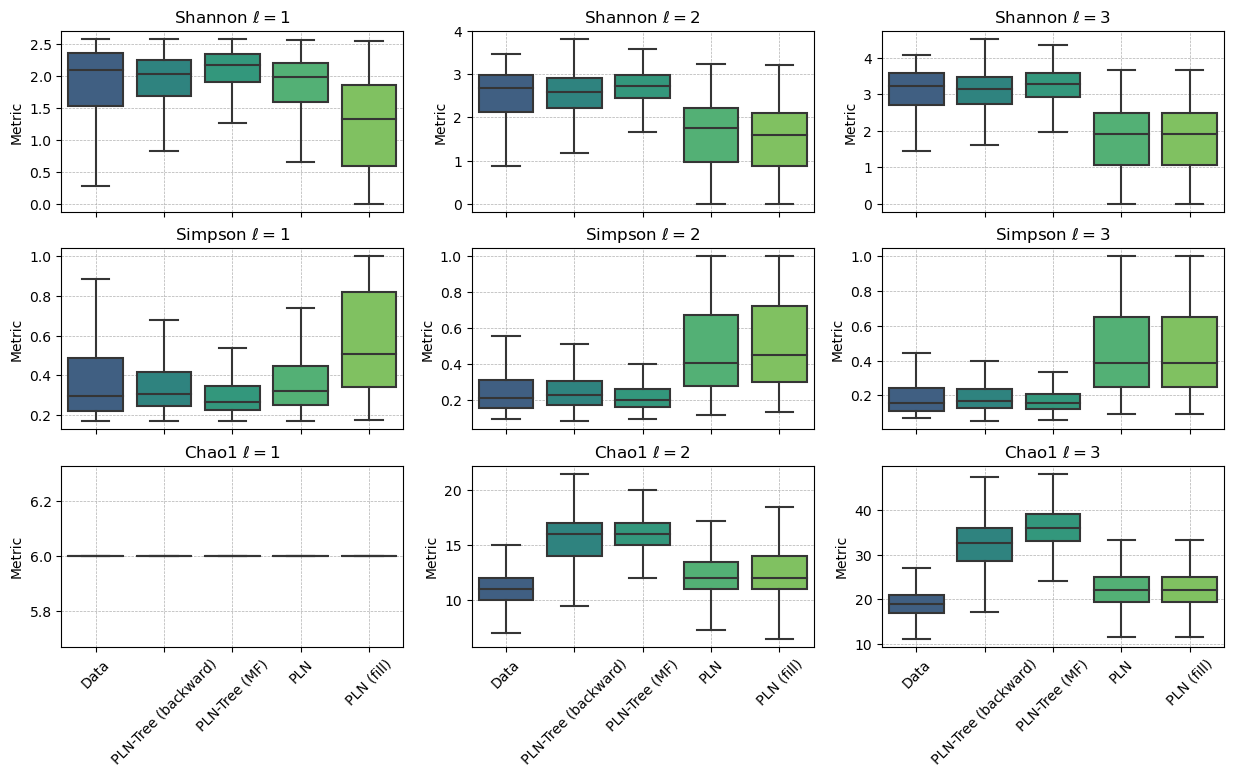

In [88]:
X_list = (X_base, X_plntree, X_meanfield, X_pln, X_pln_fill)
groups = ['Data', 'PLN-Tree (backward)', 'PLN-Tree (MF)', 'PLN', 'PLN (fill)']
colors = [viridis(0.3), viridis(0.5), viridis(0.6), viridis(0.7), viridis(0.8)]

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
    saveName=f'synthetic_dirichlet_generations_{len(estimators)}'
)

In [89]:
X_comp = (X_plntree, X_meanfield, X_pln_fill, X_pln)
comp_names = ['PLN-Tree (backward)', 'PLN-Tree (MF)', 'PLN (fill)', 'PLN']

print('Distribution of samples distance: Wasserstein')
compute_distribution_distance(X_base, X_comp, 25, comp_names, K, distance=emd)

Distribution of samples distance: Wasserstein


In [90]:
print('Distribution of normalized counts: KL Divergence')
def kl(p_samples, q_samples):
    p_dist = (p_samples / (p_samples.sum(axis=-1, keepdims=True) + 1e-8)).mean(axis=0)
    q_dist = (q_samples / (q_samples.sum(axis=-1, keepdims=True) + 1e-8)).mean(axis=0)
    return entropy(p_dist, q_dist)
compute_distribution_distance(X_base, X_comp, 25, comp_names, K, distance=kl)

Distribution of normalized counts: KL Divergence


In [91]:
print('Distribution of normalized counts: MAE')
def mae_dist(p_samples, q_samples):
    p_dist = (p_samples / (p_samples.sum(axis=-1, keepdims=True) + 1e-8)).mean(axis=0)
    q_dist = (q_samples / (q_samples.sum(axis=-1, keepdims=True) + 1e-8)).mean(axis=0)
    return np.mean(np.abs(p_dist - q_dist))
compute_distribution_distance(X_base, X_comp, 25, comp_names, K, distance=mae_dist)

Distribution of normalized counts: MAE


In [92]:
print('Wasserstein Distance')
repeated_metric_compute(
    tree, X_base, [X_plntree, X_meanfield, X_pln_fill, X_pln], ['PLN-Tree', 'MF', 'PLN (fill)', 'PLN'], 
    n_split=25, distance=wasserstein_distance, offset_layer=selected_layers[0]
)

Wasserstein Distance


In [93]:
print('Kolmogorov Smirnov')
repeated_metric_compute(
    tree, X_base, [X_plntree, X_meanfield, X_pln_fill, X_pln], ['PLN-Tree', 'MF', 'PLN (fill)', 'PLN'], 
    n_split=25, distance=kolmogorov_smirnov, offset_layer=selected_layers[0]
)

Kolmogorov Smirnov


In [94]:
print('KL divergence')
repeated_metric_compute(
    tree, X_base, [X_plntree, X_meanfield, X_pln_fill, X_pln], ['PLN-Tree', 'MF', 'PLN (fill)', 'PLN'], 
    n_split=25, distance=kl_divergence, offset_layer=selected_layers[0]
)

KL divergence


In [95]:
print('Total variation')
repeated_metric_compute(
    tree, X_base, [X_plntree, X_meanfield, X_pln_fill, X_pln], ['PLN-Tree', 'MF', 'PLN (fill)', 'PLN'], 
    n_split=25, distance=total_variation, offset_layer=selected_layers[0]
)

Total variation


#### Encoding benchmark

In [100]:
Z_meanfield_enc, O_meanfield_enc = meanfield.encode(X_test, seed=seed)
X_meanfield_enc = meanfield.decode(Z_meanfield_enc, O_meanfield_enc, seed=seed)

plntree = estimators[0][0]
Z_plntree_enc, O_plntree_enc = plntree.encode(X_test, seed=seed)
X_plntree_enc = plntree.decode(Z_plntree_enc, O_plntree_enc, seed=seed)

Correlation against PLN-Tree(backward):
  * layer = 1: 0.9513741311628917 ± 0.1046467166670802
  * layer = 2: 0.9482750099678717 ± 0.1118803848345846
  * layer = 3: 0.9529308482370304 ± 0.09636442808773361
Correlation against PLN-Tree (MF):
  * layer = 1: 0.9839717211049909 ± 0.026771348351188228
  * layer = 2: 0.974157729949847 ± 0.07229759314216869
  * layer = 3: 0.9788884849590048 ± 0.042252360068893616


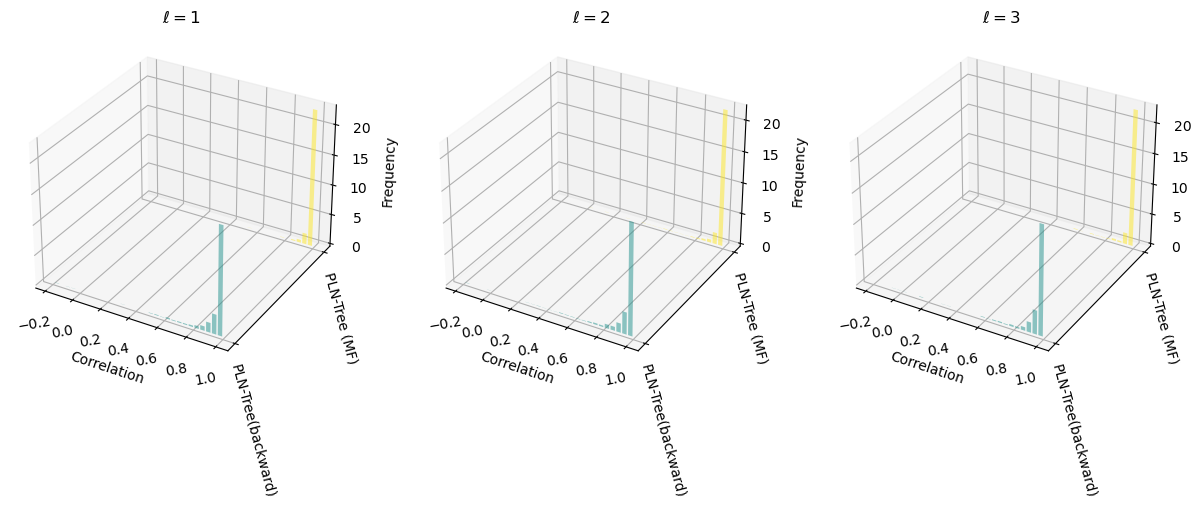

MAE against PLN-Tree(backward): tensor(138.2856) (± nan)
MAE against PLN-Tree (MF): tensor(110.8530) (± nan)


In [101]:
X_comp = (X_plntree_enc, X_meanfield_enc)
groups = ['PLN-Tree(backward)', 'PLN-Tree (MF)']
for group, X_c in zip(groups, X_comp):
    print(f'Correlation against {group}:')
    correlations = correlation(X_test, X_c, meanfield)
    for layer, corr in enumerate(correlations):
        print(f'  * layer = {layer+selected_layers[0]}:', corr[~torch.isnan(corr)].mean().item(), '±', corr[~torch.isnan(corr)].std().item())
correlation_3d_plot(X_test, X_comp, groups, meanfield, saveName='')
for group, X_c in zip(groups, X_comp):
    m = mae(X_test, X_c)
    print(f'MAE against {group}:', m.mean(), f'(± {m.std()})')

In [74]:
for group, X_c in zip(groups, X_comp):
    m = mae_tree(to_proportion(X_test, K), to_proportion(X_c, K), K)
    print(f'MAE against {group}:', m.mean(), f'(± {m.std()})')

MAE against PLN-Tree(backward): tensor(0.0214) (± nan)
MAE against PLN-Tree (MF): tensor(0.0151) (± nan)


<h1 style="color:#333333; font-family:Arial, sans-serif; font-size:28px; font-weight:bold; text-align:center;">Medical data: microbiota exploration</h1>

## Dataset import

In [ ]:
seed = 0
prefix = f'metagenomics_diseases_s{seed}'

seed_all(seed)

In [ ]:
from plntree.data import metagenomics_loader

raw_abundances, metadata = metagenomics_loader.load_raw_data(directory='./plntree/data/metagenomics')

In [ ]:
metadata

In [ ]:
metadata['disease'].value_counts()

In [ ]:
diseases = ['t2d', 'ibd_ulcerative_colitis', 'cirrhosis', 'ibd_crohn_disease', 'cancer', 'obesity', 'leaness']
raw_abundances, metadata = metagenomics_loader.filter_diseases(raw_abundances, metadata, diseases)

In [ ]:
# Shuffling the dataset to prevent selection biases
indexes = metadata.index.tolist()
indexes = pd.Series(indexes).sample(frac=1, random_state=seed).tolist()
metadata = metadata.loc[indexes]

In [ ]:
undersampling_rate = 0.8
max_sampling = 200
train_index = []
test_index = []
for disease in diseases:
    ind = metadata[metadata['disease'] == disease].index
    min_index = min(max_sampling, int(np.floor(len(ind) * undersampling_rate)))
    train_index += list(ind[:min_index])
    test_index +=list(ind[min_index:])
    print(f'{disease}', len(ind[:min_index]), len(ind[min_index:]), len(ind[:min_index])+len(ind[min_index:]))
print(len(train_index), len(test_index), len(train_index)+len(test_index))
train_raw_abundances = raw_abundances[['Feature']+train_index]
train_metadata = metadata.loc[train_index]
test_raw_abundances = raw_abundances[['Feature']+test_index]
test_metadata = metadata.loc[test_index]

In [ ]:
train_raw_abundances

In [ ]:
test_raw_abundances

In [ ]:
# Select the taxonomic precision
precision = 5
# Filter out some taxa
filtered_taxa = ['k__Archaea', 'k__Eukaryota']
# Select the rarefaction offset
rarefaction_offset = 12
# Select the prevalence threshold (-1 for none)
prevalence = 1 / np.exp(rarefaction_offset)

In [ ]:
abundances = metagenomics_loader.raw_abundance_filter(train_raw_abundances, precision)
for taxon in filtered_taxa:
    abundances = metagenomics_loader.exclude_taxon(abundances, taxon)
if prevalence > 0:
    abundances = metagenomics_loader.prevalence_filter(abundances, threshold=prevalence)
abundances = metagenomics_loader.rarefy(abundances, rarefaction_offset, seed=seed)

taxonomy = metagenomics_loader.get_taxonomy(abundances)
taxonomy.plot(legend=False, title='')
savefig('taxonomy_metagenomics_dataset_filtered')

In [ ]:
test_raw_abundances = test_raw_abundances[test_raw_abundances['Feature'].isin(abundances.index)]
test_abundances = metagenomics_loader.raw_abundance_filter(test_raw_abundances, precision)
test_abundances = metagenomics_loader.rarefy(test_abundances, rarefaction_offset, seed=seed)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
# Select the offset layer
selected_layers = [2, -1]
K = list(taxonomy.getLayersWidth().values())[selected_layers[0]:]
X_base, patient_ids = metagenomics_loader.hierarchical_dataset(abundances, taxonomy, offset_layer=selected_layers[0])

# Select the batch size
batch_size = len(X_base)
seed_all(seed)
dataset = TensorDataset(X_base.to(dtype=torch.float64), X_base.to(dtype=torch.float64))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
X_test, test_patient_ids = metagenomics_loader.hierarchical_dataset(test_abundances, taxonomy, offset_layer=selected_layers[0])
X_test = X_test.to(dtype=torch.float64)

In [ ]:
vizualize_samples(dataloader, taxonomy, selected_layers, autofill=True, seed=seed)
savefig('metagenomics_samples')

## Models training

### PLN

Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 927 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 920 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 909 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 871 iterations
Likelihood: -36328.78238272667


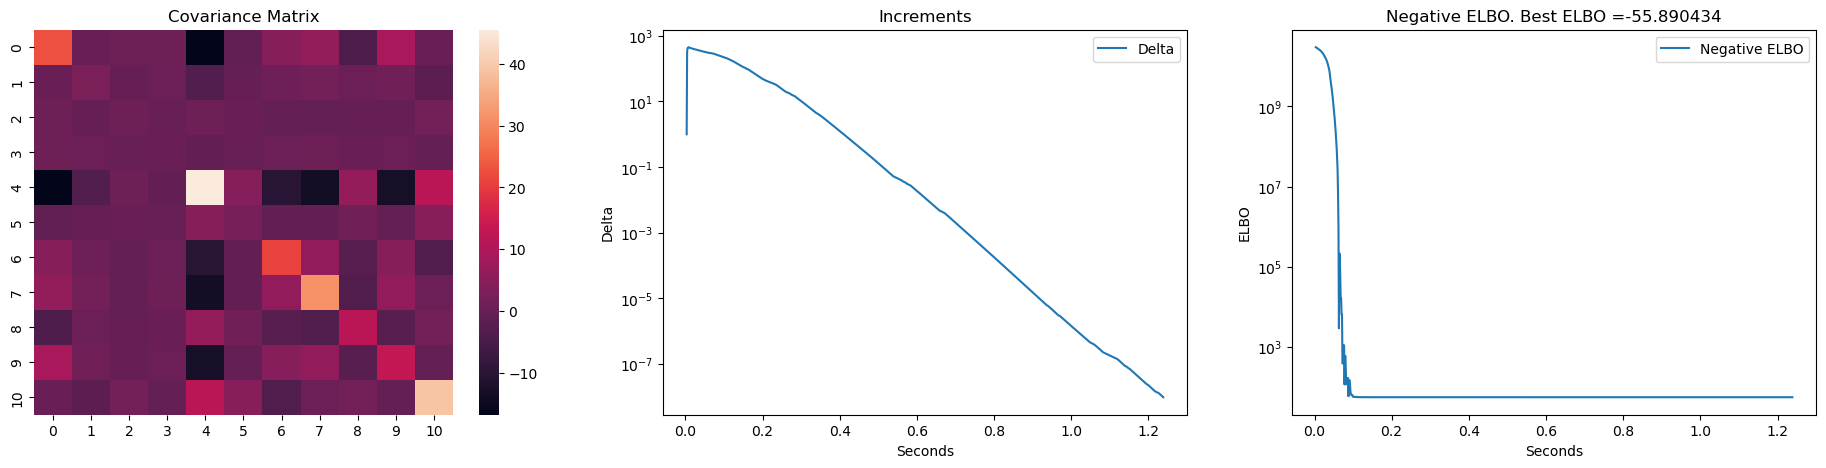

Likelihood: -64593.87010753155


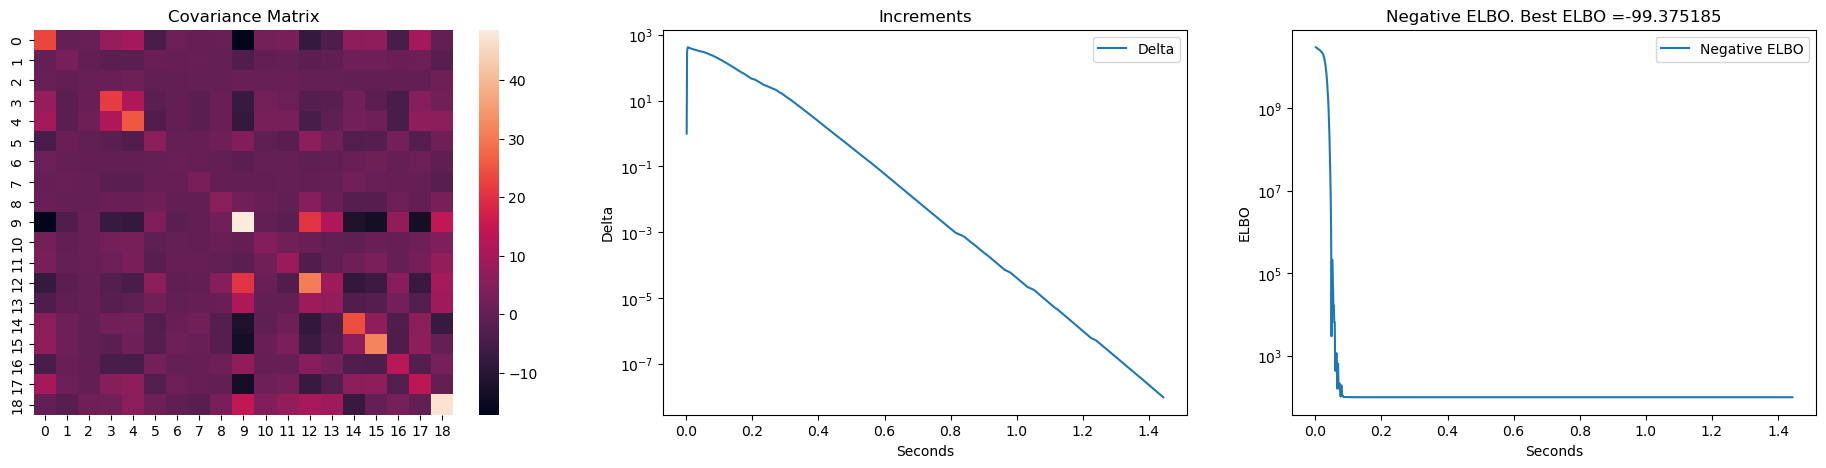

Likelihood: -76512.6939368248


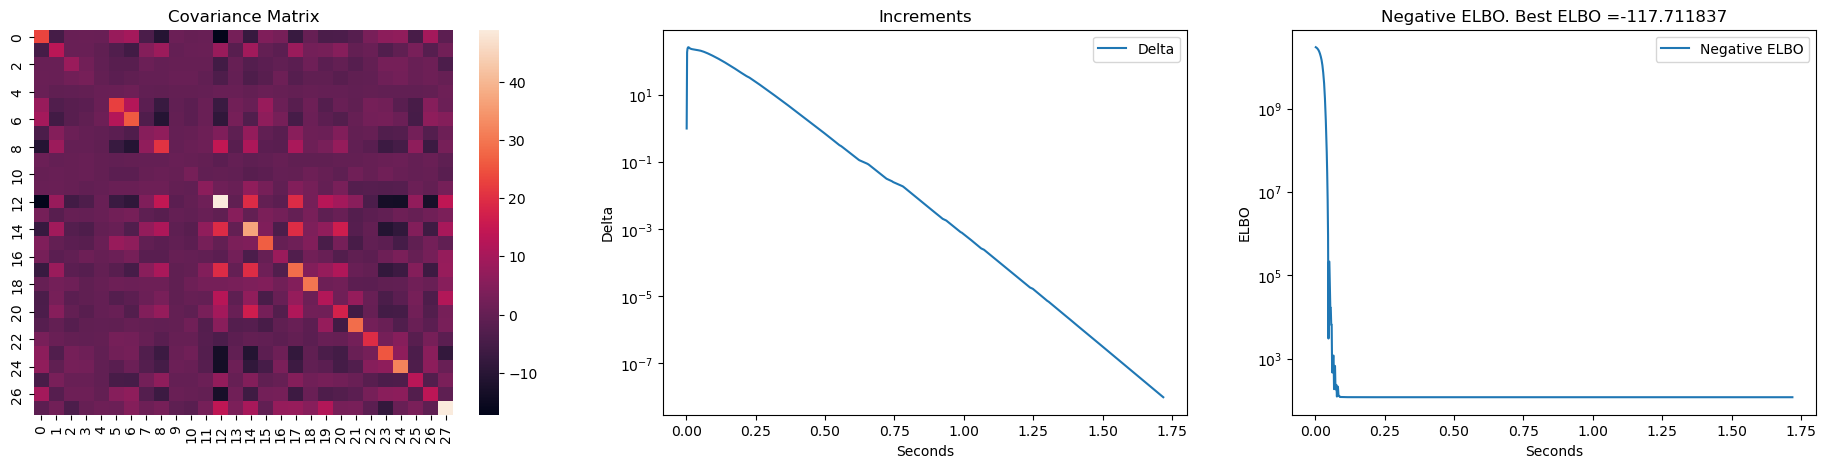

Likelihood: -145322.25033533573


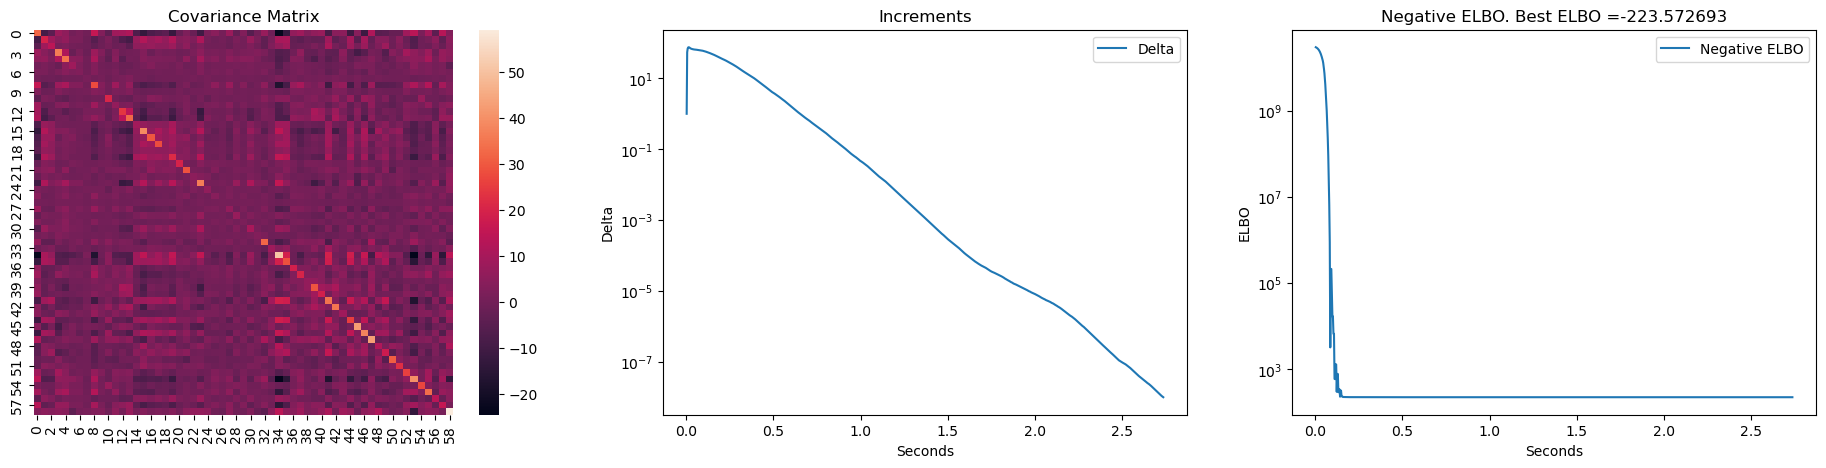

In [17]:
pln_layers = learn_pln(X_base, K, seed=seed)

In [18]:
n_samples = 20_000
X_pln, Z_pln, X_pln_fill, X_pln_enc, Z_pln_enc, X_pln_enc_fill = generate_pln_data(pln_layers, n_samples, K, selected_layers, X_base, taxonomy, seed=seed)

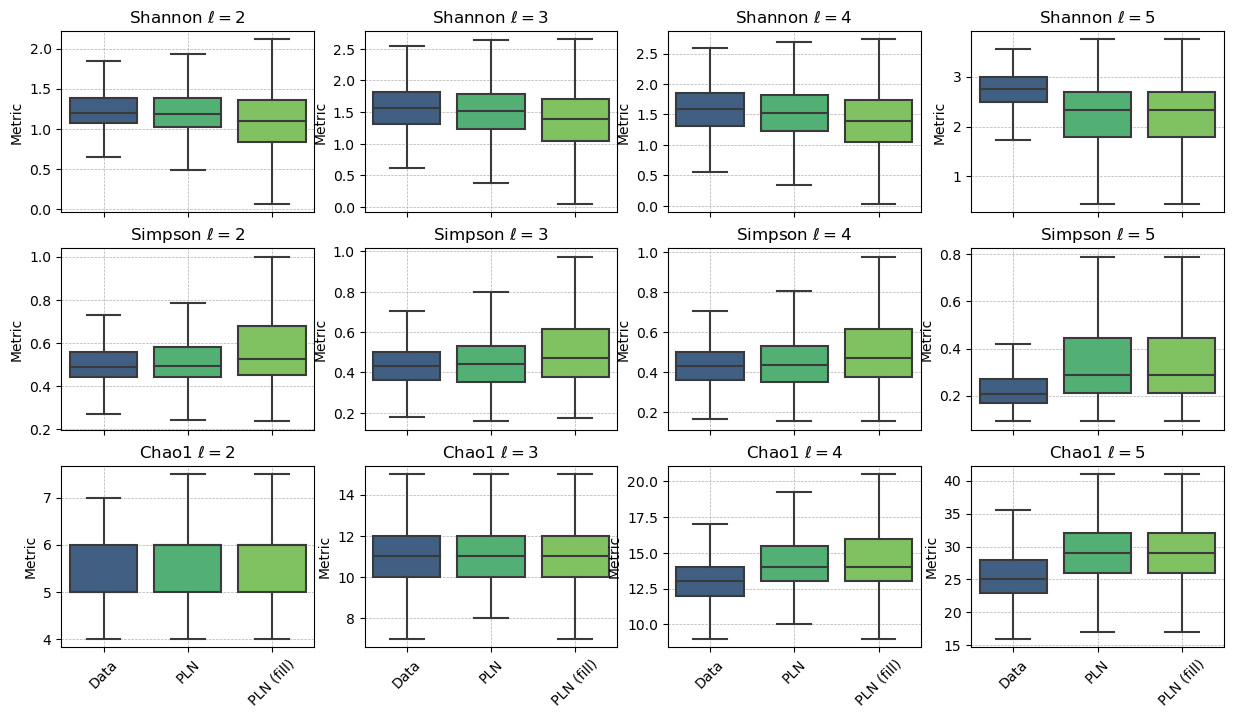

In [19]:
X_list = [X_base, X_pln, X_pln_fill]
groups = ['Data', 'PLN', 'PLN (fill)']
colors = [viridis(0.3)] +  [viridis(0.7)] + [viridis(0.8)]

plot_alpha_diversity(
    X_list,
    taxonomy,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

### PLN-Tree (Mean Field)

#### Model selection

In [ ]:
def get_plntree_params_and_suffix(n_latent_layers, variational_approx, variational_approx_params):
    params = {
        'tree':taxonomy,
        'selected_layers':selected_layers,
        'diagonal_model':False,
        'variational_approx':variational_approx,
        'positive_fun':'softplus',
        'offset_method':'constant',
        'variational_approx_params':variational_approx_params,
        'n_latent_layers':n_latent_layers,
        'diag_smoothing_factor':1e-4
    }
    placeholder = variational_approx_params
    if variational_approx == 'mean_field':
        placeholder = variational_approx_params['n_variational_layers']
    suffix = f'latentlayers-{n_latent_layers}_varlayers-{placeholder}'
    return params, suffix

In [ ]:
def learn_plntree_mean_field(params):
    estimator = PLNTree(**params, seed=seed)

    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    n_epoch = 25_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=10.)

In [ ]:
n_variational_layers_list = [1, 2, 3]
n_latent_layers_list = [1, 2, 3]
meanfields = {}
preprocessing = 'proportion'

for n_latent_layers in n_latent_layers_list:
    for n_variational_layers in n_variational_layers_list:
        print('Latents size', n_latent_layers)
        print('Variational size', n_variational_layers)
        variational_approx_params = {
            'n_variational_layers':n_variational_layers,
            'preprocessing': [preprocessing]
        }
        params, suffix = get_plntree_params_and_suffix(n_variational_layers, 'mean_field', variational_approx_params)
        try:
            meanfield, meanfield_losses = load_pkl(prefix, f'mean_field_{preprocessing}_{suffix}')
        except:
            meanfield, meanfield_losses = learn_plntree_mean_field(params)
            save_pkl((meanfield, meanfield_losses), prefix, f'mean_field_{preprocessing}_{suffix}')
        meanfields[f'{n_latent_layers}:{n_variational_layers}'] = (meanfield, meanfield_losses)

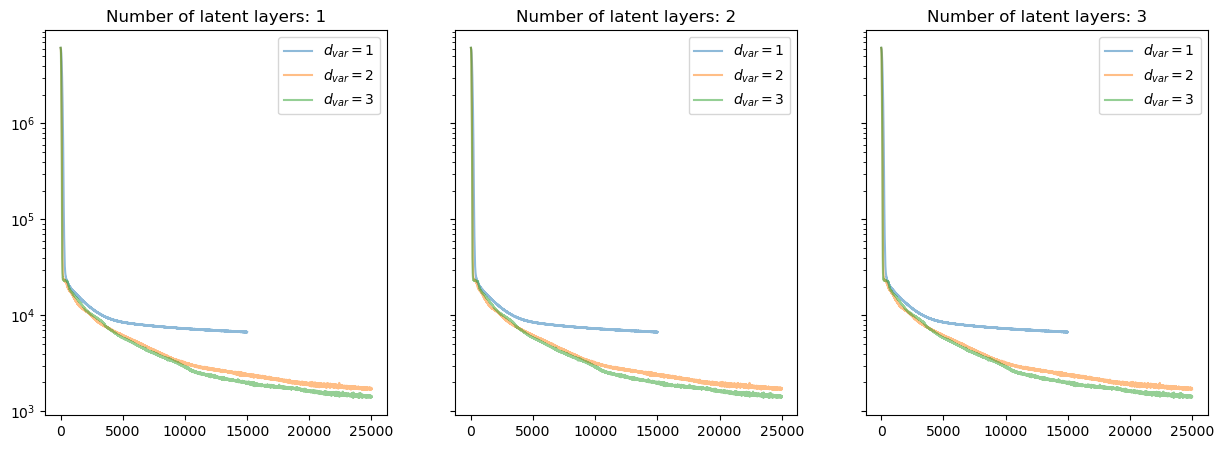

In [164]:
fig, axs = plt.subplots(1, len(n_latent_layers_list), figsize=(15, 5), sharey=True)
for key, (meanfield, meanfield_losses) in meanfields.items():
    n_latent_layers, n_variational_layers = key.split(':')
    i = int(n_latent_layers) - 1
    axs[i].set_title(f'Number of latent layers: {n_latent_layers}')
    axs[i].plot(meanfield_losses, label='$d_{var}=$' + f'{n_variational_layers}', alpha=0.5)
    axs[i].set_yscale('log')
    axs[i].legend()

In [165]:
n_samples = 20_000

meanfield_samples = {}
for key, (meanfield, meanfield_losses) in meanfields.items():
    X_meanfield, Z_meanfield, O_meanfield = meanfield.sample(n_samples, seed=seed)
    meanfield_samples[key] = X_meanfield

Generated batch size: 19999
Generated batch size: 19999


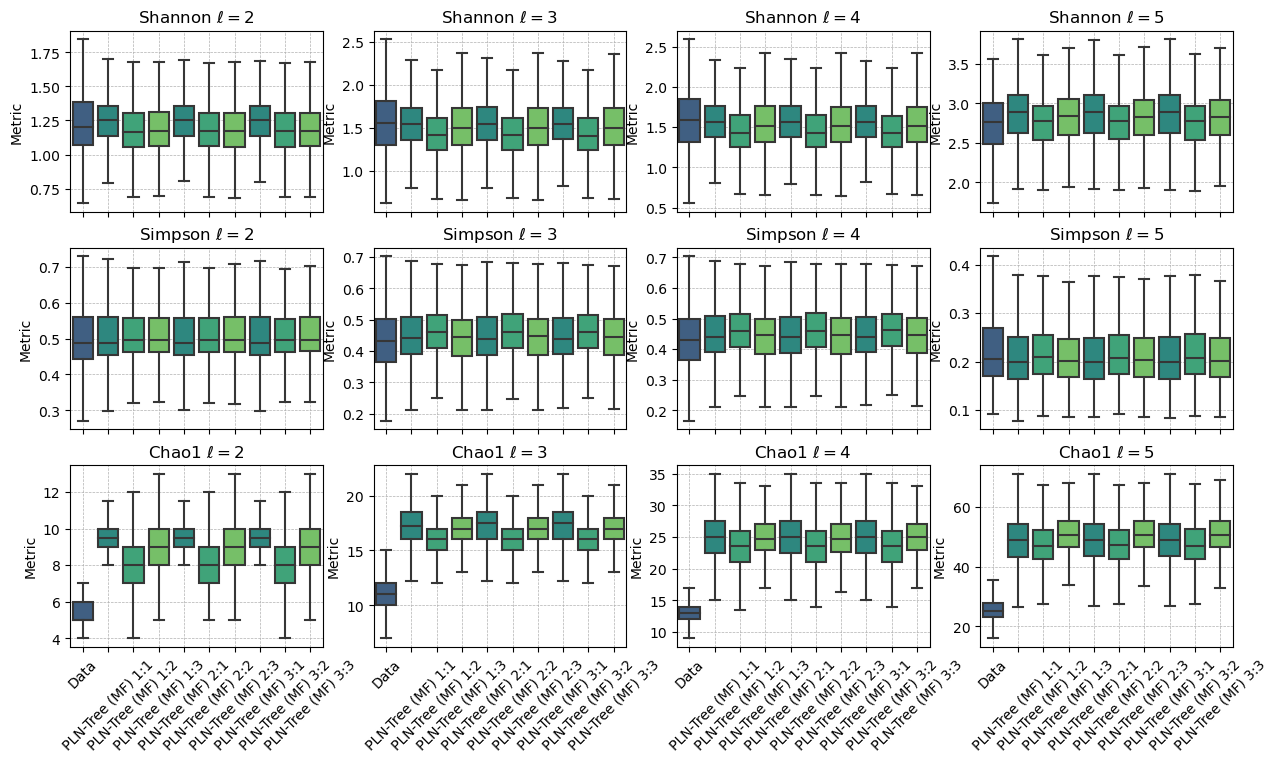

In [166]:
X_list = [X_base] + [X_meanfield for key, X_meanfield in meanfield_samples.items()]
groups = ['Data'] + ['PLN-Tree (MF) ' + key for key, X_meanfield in meanfield_samples.items()]
mf_colors = [viridis(0.4 + int(key.split(':')[1])/8) for key in meanfield_samples.keys()]
colors = [viridis(0.3)] + mf_colors

plot_alpha_diversity(
    X_list,
    taxonomy,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

In [167]:
print('Wasserstein Distance')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=wasserstein_distance, offset_layer=selected_layers[0], order=True
)

Wasserstein Distance


In [168]:
print('KL divergence')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=kl_divergence, offset_layer=selected_layers[0], order=True
)

KL divergence


In [169]:
print('Kolmogorov Smirnov')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=kolmogorov_smirnov, offset_layer=selected_layers[0], order=True
)

Kolmogorov Smirnov


In [170]:
print('Total variation')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=total_variation, offset_layer=selected_layers[0], order=True
)

Total variation


#### Selected model training

In [171]:
meanfield, meanfield_losses = meanfields['1:3']

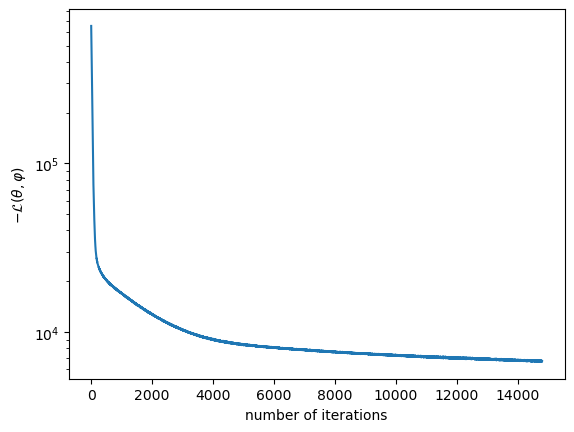

In [31]:
fig, axs = plt.subplots()
axs.plot(meanfield_losses[200:])
axs.set_yscale('log')
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
savefig(f"{prefix}_MF_ELBO")

In [32]:
n_samples = 20_000

X_meanfield, Z_meanfield, O_meanfield = meanfield.sample(n_samples, seed=seed)
Z_meanfield_enc, O_meanfield_enc = meanfield.encode(X_base, seed=seed)
X_meanfield_enc = meanfield.decode(Z_meanfield_enc, O_meanfield_enc, seed=seed)

### PLN-Tree (Backward)

#### Model selection

In [177]:
preprocessing = 'proportion'
def learn_plntree(n_latent_layers, variational_approx, variational_approx_params):
    estimator = PLNTree(
        tree=taxonomy,
        selected_layers=selected_layers,
        diag_smoothing_factor=1e-4,
        positive_fun='softplus',
        offset_method='constant',
        identifiable=True,
        variational_approx=variational_approx,
        variational_approx_params=variational_approx_params,
        n_latent_layers=n_latent_layers,
        seed=seed
    )
    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    estimator.to(dtype=torch.float64)
    n_epoch = 30_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

In [150]:
n_latents = 2
variational_approx_params = {'n_layers': 1, 'preprocessing': [preprocessing]}
try:
    plntree_weak, plntree_weak_losses = load_pkl(prefix, f'weak_plntree_{preprocessing}_{n_latents}-{variational_approx_params}')
except:
    plntree_weak, plntree_weak_losses = learn_plntree(n_latents, 'weak_backward', variational_approx_params)
    save_pkl((plntree_weak, plntree_weak_losses), prefix, f'weak_plntree_{preprocessing}_{n_latents}-{variational_approx_params}')

Loading file ./experiments/saves/metagenomics_diseases_weak_plntree_proportion_2-{'n_layers': 1, 'preprocessing': ['proportion']}.pkl


In [126]:
def load_plntree_weaks():
    # learning rate 1e-2
    # 25_000 iterations
    n_latents_list = [1, 2]
    n_layers_list = [1, 2, 3]
    variational_approx_params = {'n_layers': 2, 'preprocessing': [preprocessing]}

    backwards = {}
    for n_latents in n_latents_list:
        for n_layers in n_layers_list:
            key = f'{n_latents}:{n_layers}'
            variational_approx_params = {'n_layers': n_layers, 'preprocessing': [preprocessing]}
            try:
                plntree_weak, plntree_weak_losses = load_pkl(prefix, f'weak_plntree_{preprocessing}_{n_latents}-{variational_approx_params}')
            except:
                plntree_weak, plntree_weak_losses = learn_plntree(n_latents, 'weak_backward', variational_approx_params)
                save_pkl((plntree_weak, plntree_weak_losses), prefix, f'weak_plntree_{preprocessing}_{n_latents}-{variational_approx_params}')
            backwards[key] = (plntree_weak, plntree_weak_losses)
    return backwards

Loading file ./experiments/saves/metagenomics_diseases_weak_plntree_proportion_1-{'n_layers': 1, 'preprocessing': ['proportion']}.pkl
[*] Epoch: 100 Average loss: 575154.9296
[*] Epoch: 200 Average loss: 24354.8863
[*] Epoch: 300 Average loss: 20731.1059
[*] Epoch: 400 Average loss: 17442.1422
[*] Epoch: 500 Average loss: 16395.5262
[*] Epoch: 600 Average loss: 14372.1751
[*] Epoch: 700 Average loss: 13277.8839
[*] Epoch: 800 Average loss: 12412.7838
[*] Epoch: 900 Average loss: 11721.5420
[*] Epoch: 1000 Average loss: 12192.9214
[*] Epoch: 1100 Average loss: 10675.7891
[*] Epoch: 1200 Average loss: 9572.2076
[*] Epoch: 1300 Average loss: 9334.4863
[*] Epoch: 1400 Average loss: 8774.7889
[*] Epoch: 1500 Average loss: 7911.3398
[*] Epoch: 1600 Average loss: 7895.1572
[*] Epoch: 1700 Average loss: 7481.1290
[*] Epoch: 1800 Average loss: 7565.9312
[*] Epoch: 1900 Average loss: 7174.8397
[*] Epoch: 2000 Average loss: 6493.1437
[*] Epoch: 2100 Average loss: 6335.2611
[*] Epoch: 2200 Average

[*] Epoch: 20000 Average loss: 1450.8848
[*] Epoch: 20100 Average loss: 1351.8120
[*] Epoch: 20200 Average loss: 1387.4847
[*] Epoch: 20300 Average loss: 1344.1079
[*] Epoch: 20400 Average loss: 1361.5381
[*] Epoch: 20500 Average loss: 1371.0886
[*] Epoch: 20600 Average loss: 1362.4440
[*] Epoch: 20700 Average loss: 1352.9920
[*] Epoch: 20800 Average loss: 1356.8313
[*] Epoch: 20900 Average loss: 1349.0823
[*] Epoch: 21000 Average loss: 1352.1293
[*] Epoch: 21100 Average loss: 1338.8260
[*] Epoch: 21200 Average loss: 1338.7426
[*] Epoch: 21300 Average loss: 1336.2548
[*] Epoch: 21400 Average loss: 1313.4309
[*] Epoch: 21500 Average loss: 1332.8065
[*] Epoch: 21600 Average loss: 1313.4734
[*] Epoch: 21700 Average loss: 1368.8426
[*] Epoch: 21800 Average loss: 1327.2695
[*] Epoch: 21900 Average loss: 1329.3434
[*] Epoch: 22000 Average loss: 1303.7370
[*] Epoch: 22100 Average loss: 1296.1602
[*] Epoch: 22200 Average loss: 1310.9481
[*] Epoch: 22300 Average loss: 1289.9278
[*] Epoch: 22400

[*] Epoch: 14300 Average loss: 1225.8148
[*] Epoch: 14400 Average loss: 1132.6205
[*] Epoch: 14500 Average loss: 1152.6132
[*] Epoch: 14600 Average loss: 1228.1131
[*] Epoch: 14700 Average loss: 1165.6885
[*] Epoch: 14800 Average loss: 1217.9720
[*] Epoch: 14900 Average loss: 1168.3415
[*] Epoch: 15000 Average loss: 1215.1444
[*] Epoch: 15100 Average loss: 1135.7070
[*] Epoch: 15200 Average loss: 1175.5953
[*] Epoch: 15300 Average loss: 1165.6053
[*] Epoch: 15400 Average loss: 1093.2747
[*] Epoch: 15500 Average loss: 1247.9604
[*] Epoch: 15600 Average loss: 1159.5092
[*] Epoch: 15700 Average loss: 1104.2527
[*] Epoch: 15800 Average loss: 1147.2782
[*] Epoch: 15900 Average loss: 1154.9223
[*] Epoch: 16000 Average loss: 1086.7433
[*] Epoch: 16100 Average loss: 1068.5698
[*] Epoch: 16200 Average loss: 1173.7039
[*] Epoch: 16300 Average loss: 1082.3479
[*] Epoch: 16400 Average loss: 1044.0155
[*] Epoch: 16500 Average loss: 1107.6251
[*] Epoch: 16600 Average loss: 1040.5217
[*] Epoch: 16700

[*] Epoch: 9000 Average loss: 2687.6666
[*] Epoch: 9100 Average loss: 2558.0544
[*] Epoch: 9200 Average loss: 2574.2684
[*] Epoch: 9300 Average loss: 2593.1040
[*] Epoch: 9400 Average loss: 2580.2229
[*] Epoch: 9500 Average loss: 2594.9852
[*] Epoch: 9600 Average loss: 2471.4747
[*] Epoch: 9700 Average loss: 2524.5090
[*] Epoch: 9800 Average loss: 2496.1583
[*] Epoch: 9900 Average loss: 2577.3425
[*] Epoch: 10000 Average loss: 2461.6832
[*] Epoch: 10100 Average loss: 2403.2166
[*] Epoch: 10200 Average loss: 2439.8935
[*] Epoch: 10300 Average loss: 2407.3253
[*] Epoch: 10400 Average loss: 2395.7956
[*] Epoch: 10500 Average loss: 2414.5227
[*] Epoch: 10600 Average loss: 2387.3758
[*] Epoch: 10700 Average loss: 2365.0340
[*] Epoch: 10800 Average loss: 2348.4086
[*] Epoch: 10900 Average loss: 2370.2619
[*] Epoch: 11000 Average loss: 2352.4310
[*] Epoch: 11100 Average loss: 2316.7899
[*] Epoch: 11200 Average loss: 2295.4187
[*] Epoch: 11300 Average loss: 2297.0539
[*] Epoch: 11400 Average l

[*] Epoch: 3500 Average loss: 4134.4974
[*] Epoch: 3600 Average loss: 3764.2634
[*] Epoch: 3700 Average loss: 4531.9928
[*] Epoch: 3800 Average loss: 4265.9734
[*] Epoch: 3900 Average loss: 3882.1550
[*] Epoch: 4000 Average loss: 3484.1703
[*] Epoch: 4100 Average loss: 3351.2984
[*] Epoch: 4200 Average loss: 3219.6850
[*] Epoch: 4300 Average loss: 3229.6866
[*] Epoch: 4400 Average loss: 3084.2817
[*] Epoch: 4500 Average loss: 3639.7536
[*] Epoch: 4600 Average loss: 3019.1389
[*] Epoch: 4700 Average loss: 3371.0885
[*] Epoch: 4800 Average loss: 2843.3240
[*] Epoch: 4900 Average loss: 3412.5563
[*] Epoch: 5000 Average loss: 3354.7137
[*] Epoch: 5100 Average loss: 2920.4676
[*] Epoch: 5200 Average loss: 2663.7444
[*] Epoch: 5300 Average loss: 2621.7496
[*] Epoch: 5400 Average loss: 2551.4051
[*] Epoch: 5500 Average loss: 3003.6659
[*] Epoch: 5600 Average loss: 2801.9958
[*] Epoch: 5700 Average loss: 2680.0040
[*] Epoch: 5800 Average loss: 3837.9421
[*] Epoch: 5900 Average loss: 2875.1726


[*] Epoch: 23700 Average loss: 950.8912
[*] Epoch: 23800 Average loss: 914.7780
[*] Epoch: 23900 Average loss: 988.9562
[*] Epoch: 24000 Average loss: 1163.5863
[*] Epoch: 24100 Average loss: 911.5887
[*] Epoch: 24200 Average loss: 1040.1135
[*] Epoch: 24300 Average loss: 1050.0486
[*] Epoch: 24400 Average loss: 916.3839
[*] Epoch: 24500 Average loss: 1051.2034
[*] Epoch: 24600 Average loss: 1167.0614
[*] Epoch: 24700 Average loss: 1067.2363
[*] Epoch: 24800 Average loss: 872.0192
[*] Epoch: 24900 Average loss: 1017.3558
[*] Epoch: 24999 Average loss: 1068.0229
Saving in file ./experiments/saves/metagenomics_diseases_weak_plntree_proportion_2-{'n_layers': 2, 'preprocessing': ['proportion']}.pkl
Loading file ./experiments/saves/metagenomics_diseases_weak_plntree_proportion_2-{'n_layers': 3, 'preprocessing': ['proportion']}.pkl
[*] Epoch: 100 Average loss: 462477.4932
[*] Epoch: 200 Average loss: 32160.7029
[*] Epoch: 300 Average loss: 29386.7633
[*] Epoch: 400 Average loss: 26429.8225
[

[*] Epoch: 18300 Average loss: 1394.4276
[*] Epoch: 18400 Average loss: 1365.8895
[*] Epoch: 18500 Average loss: 1440.5771
[*] Epoch: 18600 Average loss: 1532.3419
[*] Epoch: 18700 Average loss: 1389.6091
[*] Epoch: 18800 Average loss: 1327.7387
[*] Epoch: 18900 Average loss: 1358.4418
[*] Epoch: 19000 Average loss: 1414.8151
[*] Epoch: 19100 Average loss: 1521.5777
[*] Epoch: 19200 Average loss: 1315.4604
[*] Epoch: 19300 Average loss: 1338.6068
[*] Epoch: 19400 Average loss: 1742.9044
[*] Epoch: 19500 Average loss: 1411.9272
[*] Epoch: 19600 Average loss: 1408.1081
[*] Epoch: 19700 Average loss: 1463.6952
[*] Epoch: 19800 Average loss: 1310.8849
[*] Epoch: 19900 Average loss: 1410.2187
[*] Epoch: 20000 Average loss: 1349.0562
[*] Epoch: 20100 Average loss: 1340.5868
[*] Epoch: 20200 Average loss: 1406.1228
[*] Epoch: 20300 Average loss: 1274.4102
[*] Epoch: 20400 Average loss: 1713.3058
[*] Epoch: 20500 Average loss: 1280.3003
[*] Epoch: 20600 Average loss: 1325.7189
[*] Epoch: 20700

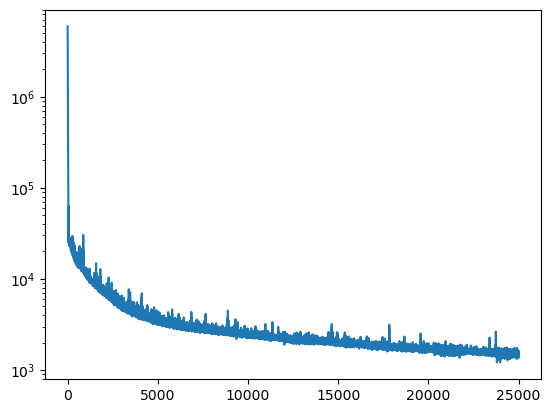

In [136]:
fig, axs = plt.subplots()
axs.plot(plntree_weak_losses)
axs.set_yscale('log')

In [151]:
X_plntree_weak, Z_plntree_weak, O_plntree_weak = plntree_weak.sample(20_000)

Generated batch size: 19980


In [215]:
def embedder_params(embedder_type='GRU', embedding_size=16, n_embedding_layers=2, n_embedding_neurons=32, n_after_layers=2):
    params = {
        'embedder_type': embedder_type,
        'embedding_size': embedding_size,
        'n_embedding_layers': n_embedding_layers,
        'n_embedding_neurons': n_embedding_neurons,
        'n_after_layers': n_after_layers,
        'preprocessing': [preprocessing]
    }
    name = f'Emb{embedder_type}-{n_embedding_layers}x{n_embedding_neurons}to{embedding_size}-{n_after_layers}'
    return name, params

emb_name, variational_approx_params = embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=2, 
        n_embedding_neurons=64, 
        n_after_layers=2
    )

try:
    plntree_res, plntree_res_losses = load_pkl(prefix, f'residual_backward_{preprocessing}_{1}-{1}-{emb_name}')
except:
    plntree_res, plntree_res_losses = learn_plntree(1, 'residual_backward', variational_approx_params)
    save_pkl((plntree_res, plntree_res_losses), prefix, f'residual_backward_{preprocessing}_{1}-{emb_name}')

Loading file ./experiments/saves/metagenomics_diseases_residual_backward_proportion_1-1-EmbGRU-2x64to32-2.pkl


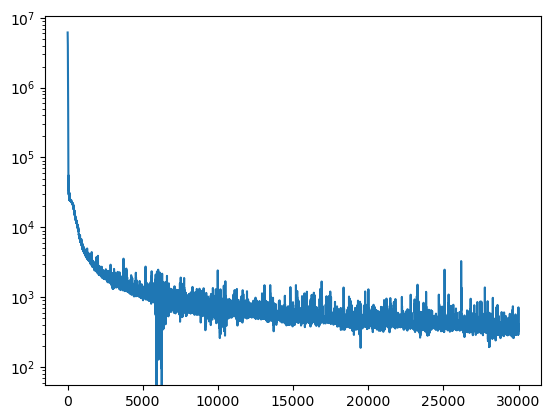

In [216]:
fig, axs = plt.subplots()
axs.plot(plntree_res_losses)
axs.set_yscale('log')

In [217]:
X_plntree_res, Z_plntree_res, O_plntree_res = plntree_res.sample(20_000, seed=seed)

In [62]:
def embedder_params(embedder_type='GRU', embedding_size=16, n_embedding_layers=2, n_embedding_neurons=32, n_after_layers=2):
    params = {
        'embedder_type': embedder_type,
        'embedding_size': embedding_size,
        'n_embedding_layers': n_embedding_layers,
        'n_embedding_neurons': n_embedding_neurons,
        'n_after_layers': n_after_layers,
        'preprocessing': ['proportion']
    }
    name = f'Emb{embedder_type}-{n_embedding_layers}x{n_embedding_neurons}to{embedding_size}-{n_after_layers}'
    return name, params

emb_name, variational_approx_params = embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=3, 
        n_embedding_neurons=64, 
        n_after_layers=3
    )
try:
    plntree_amortized, plntree_amortized_losses = load_pkl(prefix, f'amortized_backward_proportion_{1}-{emb_name}')
except:
    plntree_amortized, plntree_amortized_losses = learn_plntree(1, 'amortized_backward', variational_approx_params)
    save_pkl((plntree_amortized, plntree_amortized_losses), prefix, f'amortized_backward_proportion_{1}-{emb_name}')

Loading file ./experiments/saves/metagenomics_diseases_amortized_backward_proportion_1-EmbGRU-3x64to60-3.pkl
[*] Epoch: 100 Average loss: 1086374.7608
[*] Epoch: 200 Average loss: 69886.4056
[*] Epoch: 300 Average loss: 39242.6503
[*] Epoch: 400 Average loss: 32902.8071
[*] Epoch: 500 Average loss: 25100.3711
[*] Epoch: 600 Average loss: 24499.4008
[*] Epoch: 700 Average loss: 22860.5053
[*] Epoch: 800 Average loss: 21561.4722
[*] Epoch: 900 Average loss: 18853.2435
[*] Epoch: 1000 Average loss: 16140.8734
[*] Epoch: 1100 Average loss: 15238.1223
[*] Epoch: 1200 Average loss: 14616.7849
[*] Epoch: 1300 Average loss: 13571.3408
[*] Epoch: 1400 Average loss: 12523.9754
[*] Epoch: 1500 Average loss: 11518.5193
[*] Epoch: 1600 Average loss: 11677.2204
[*] Epoch: 1700 Average loss: 11072.5482
[*] Epoch: 1800 Average loss: 11223.9299
[*] Epoch: 1900 Average loss: 10732.7162
[*] Epoch: 2000 Average loss: 10354.0953
[*] Epoch: 2100 Average loss: 10090.0145
[*] Epoch: 2200 Average loss: 10214.4

[*] Epoch: 20100 Average loss: 2024.4142
[*] Epoch: 20200 Average loss: 1700.9603
[*] Epoch: 20300 Average loss: 1682.7901
[*] Epoch: 20400 Average loss: 1702.4230
[*] Epoch: 20500 Average loss: 1761.6188
[*] Epoch: 20600 Average loss: 1652.9134
[*] Epoch: 20700 Average loss: 1577.9092
[*] Epoch: 20800 Average loss: 1604.3897
[*] Epoch: 20900 Average loss: 1577.5505
[*] Epoch: 21000 Average loss: 2420.6941
[*] Epoch: 21100 Average loss: 1941.3483
[*] Epoch: 21200 Average loss: 1923.8048
[*] Epoch: 21300 Average loss: 1626.7106
[*] Epoch: 21400 Average loss: 1763.7154
[*] Epoch: 21500 Average loss: 1587.0976
[*] Epoch: 21600 Average loss: 1569.1837
[*] Epoch: 21700 Average loss: 1528.7994
[*] Epoch: 21800 Average loss: 1726.6025
[*] Epoch: 21900 Average loss: 1748.9293
[*] Epoch: 22000 Average loss: 2012.0566
[*] Epoch: 22100 Average loss: 1665.5494
[*] Epoch: 22200 Average loss: 1498.9879
[*] Epoch: 22300 Average loss: 1453.5863
[*] Epoch: 22400 Average loss: 1517.6981
[*] Epoch: 22500

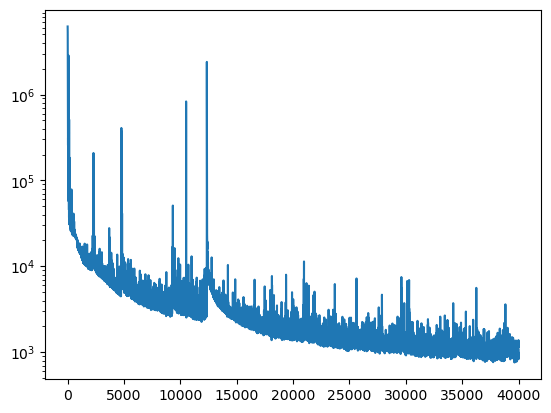

In [63]:
fig, axs = plt.subplots()
axs.plot(plntree_amortized_losses)
axs.set_yscale('log')

In [64]:
X_plntree_amortized, Z_plntree_amortized, O_plntree_amortized = plntree_amortized.sample(20_000)

In [174]:
def embedder_params(embedder_type='GRU', embedding_size=16, n_embedding_layers=2, n_embedding_neurons=32, n_after_layers=2):
    params = {
        'embedder_type': embedder_type,
        'embedding_size': embedding_size,
        'n_embedding_layers': n_embedding_layers,
        'n_embedding_neurons': n_embedding_neurons,
        'n_after_layers': n_after_layers,
        'preprocessing': ['proportion']
    }
    name = f'Emb{embedder_type}-{n_embedding_layers}x{n_embedding_neurons}to{embedding_size}-{n_after_layers}'
    return name, params

embedder_params_list = [
    embedder_params(
        embedder_type='GRU', 
        embedding_size=16, 
        n_embedding_layers=2, 
        n_embedding_neurons=32, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=2, 
        n_embedding_neurons=32, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=3, 
        n_embedding_neurons=32, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=2, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=3, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=3, 
        n_embedding_neurons=64, 
        n_after_layers=3
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=2, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=3, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=3, 
        n_embedding_neurons=64, 
        n_after_layers=3
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=3, 
        n_embedding_neurons=120, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=3, 
        n_embedding_neurons=120, 
        n_after_layers=3
    ),
]

latent_prior_sizes = [1, 2]

variational_approx_params_dict = {}
for n_latent_layers in latent_prior_sizes:
    for name, embedder_params in embedder_params_list:
        variational_approx_params_dict[f'{n_latent_layers}-{name}'] = (n_latent_layers, embedder_params)

In [200]:
def load_res_backwards():
    backwards = {}
    i = 0
    for emb_name, (n_latent_layers, variational_approx_params) in variational_approx_params_dict.items():
        i += 1
        key = f'{n_latent_layers}-{emb_name}'
        try:
            backward, backward_losses = load_pkl(prefix, f'residual_backward_{preprocessing}_{n_latent_layers}-{emb_name}')
        except:
            print('Learning PLN-Tree (residual backward), n latents', n_latent_layers, ' ', i, '/', len(variational_approx_params_dict.items()))
            print(variational_approx_params)
            backward, backward_losses = learn_plntree(n_latent_layers, 'residual_backward', variational_approx_params)
            save_pkl((backward, backward_losses), prefix, f'residual_backward_{preprocessing}_{n_latent_layers}-{emb_name}')
        backwards[key] = [backward, backward_losses]
    return backwards
backwards = load_res_backwards()

Loading file ./experiments/saves/metagenomics_diseases_residual_backward_proportion_1-1-EmbGRU-2x32to16-2.pkl
Loading file ./experiments/saves/metagenomics_diseases_residual_backward_proportion_1-1-EmbGRU-2x32to32-2.pkl
Loading file ./experiments/saves/metagenomics_diseases_residual_backward_proportion_1-1-EmbGRU-3x32to32-2.pkl
Loading file ./experiments/saves/metagenomics_diseases_residual_backward_proportion_1-1-EmbGRU-2x64to32-2.pkl
Loading file ./experiments/saves/metagenomics_diseases_residual_backward_proportion_1-1-EmbGRU-3x64to32-2.pkl
Loading file ./experiments/saves/metagenomics_diseases_residual_backward_proportion_1-1-EmbGRU-3x64to32-3.pkl
Loading file ./experiments/saves/metagenomics_diseases_residual_backward_proportion_1-1-EmbGRU-2x64to60-2.pkl
Loading file ./experiments/saves/metagenomics_diseases_residual_backward_proportion_1-1-EmbGRU-3x64to60-2.pkl
Loading file ./experiments/saves/metagenomics_diseases_residual_backward_proportion_1-1-EmbGRU-3x64to60-3.pkl
Loading fi

In [173]:
def load_amortized_backwards():
    backwards = {}
    i = 0
    for k, (n_latent_layers, variational_approx_params) in variational_approx_params_dict.items():
        key = f'{n_latent_layers}-{k}'
        try:
            backward, backward_losses = load_pkl(prefix, f'backward_nlatent-{n_latent_layers}-nvar-{k}')
        except:
            i += 1
            print('Learning PLN-Tree (backward), n latents', n_latent_layers, ' ', i, '/', len(variational_approx_params_dict.items()))
            print(variational_approx_params)
            backward, backward_losses = learn_plntree(n_latent_layers, 'amortized_backward', variational_approx_params)
            save_pkl((backward, backward_losses), prefix, f'{k}')
        backwards[key] = [backward, backward_losses]
    return backwards

Learning PLN-Tree (backward), n latents 1   1 / 22
{'embedder_type': 'GRU', 'embedding_size': 16, 'n_embedding_layers': 2, 'n_embedding_neurons': 32, 'n_after_layers': 2, 'preprocessing': ['proportion']}



KeyboardInterrupt



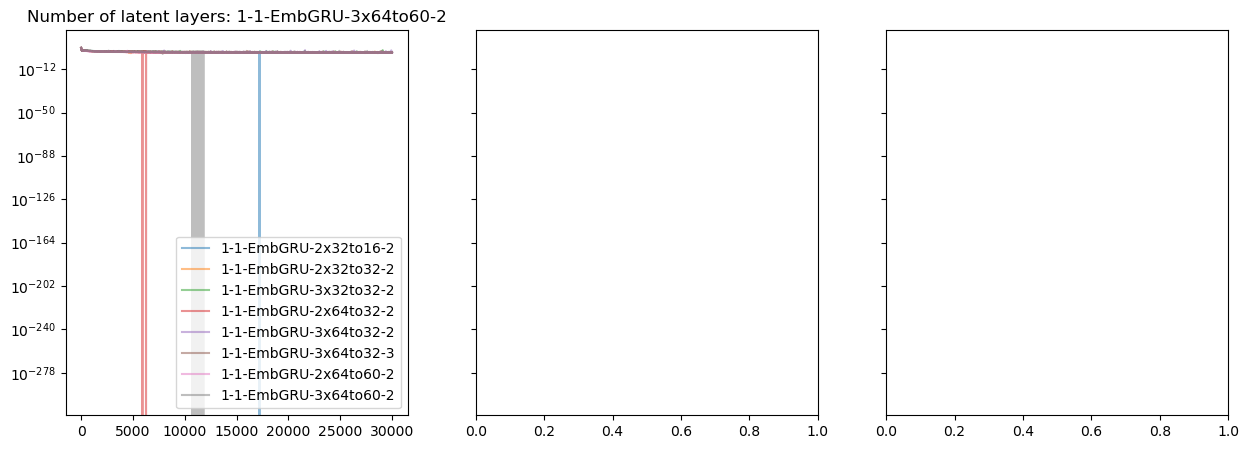

In [202]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for key, (estimator, losses) in backwards.items():
    i = int(key.split('-')[0]) - 1
    axs[i].set_title(f'Number of latent layers: {key}')
    axs[i].plot(losses, label=f'{key}', alpha=0.5)
    axs[i].set_yscale('log')
    axs[i].legend()

In [203]:
backwards_samples = {}
for key, (estimator, losses) in backwards.items():
    X_estimator, Z_estimator, O_estimator = estimator.sample(n_samples, seed=seed)
    backwards_samples[key] = X_estimator

In [204]:
X_list = [X_base] + [X_estimator for key, X_estimator in backwards_samples.items()]
groups = ['Data'] + [f'{i} PLN-Tree ' + str(key) for i, (key, X_estimator) in enumerate(backwards_samples.items())]
groups_colors = [viridis(0.4 + 0.6 * (i+1)/len(backwards_samples)) for i, key in enumerate(backwards_samples.keys())]
colors = [viridis(0.3)] + groups_colors

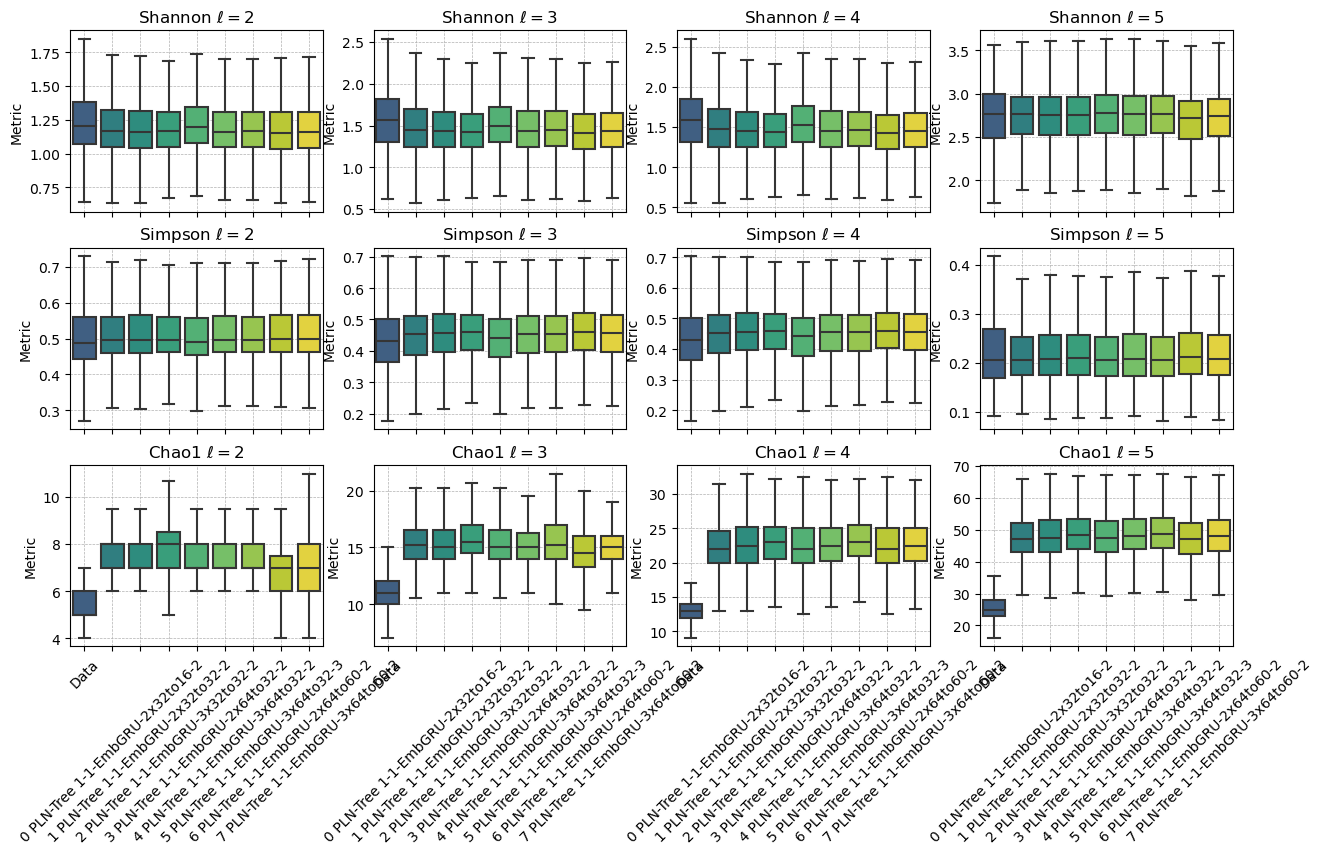

In [205]:
plot_alpha_diversity(
    X_list,
    taxonomy,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

In [206]:
print('Wasserstein Distance')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=wasserstein_distance, offset_layer=selected_layers[0], order=True
)

Wasserstein Distance


In [207]:
print('KL-Divergence')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=kl_divergence, offset_layer=selected_layers[0], order=True
)

KL-Divergence


In [208]:
print('Total Variation')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=total_variation, offset_layer=selected_layers[0], order=True
)

Total Variation


In [209]:
print('Kolmogorov-Smirnov')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=kolmogorov_smirnov, offset_layer=selected_layers[0], order=True
)

Kolmogorov-Smirnov


#### Selected model training

In [210]:
plntree, plntree_losses = backwards['1-1-EmbGRU-3x64to60-3']

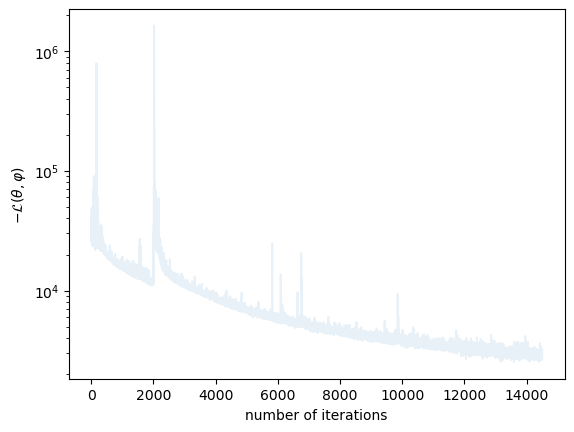

In [58]:
fig, axs = plt.subplots()
axs.plot(plntree_losses)
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
axs.set_yscale('log')
savefig(f"metagenomics_plntree_ELBO_{len(estimators)}")

In [59]:
n_samples = 20_000 

X_plntree, Z_plntree, O_plntree = plntree.sample(n_samples, seed=seed)

## Benchmark

### Generative Benchmark

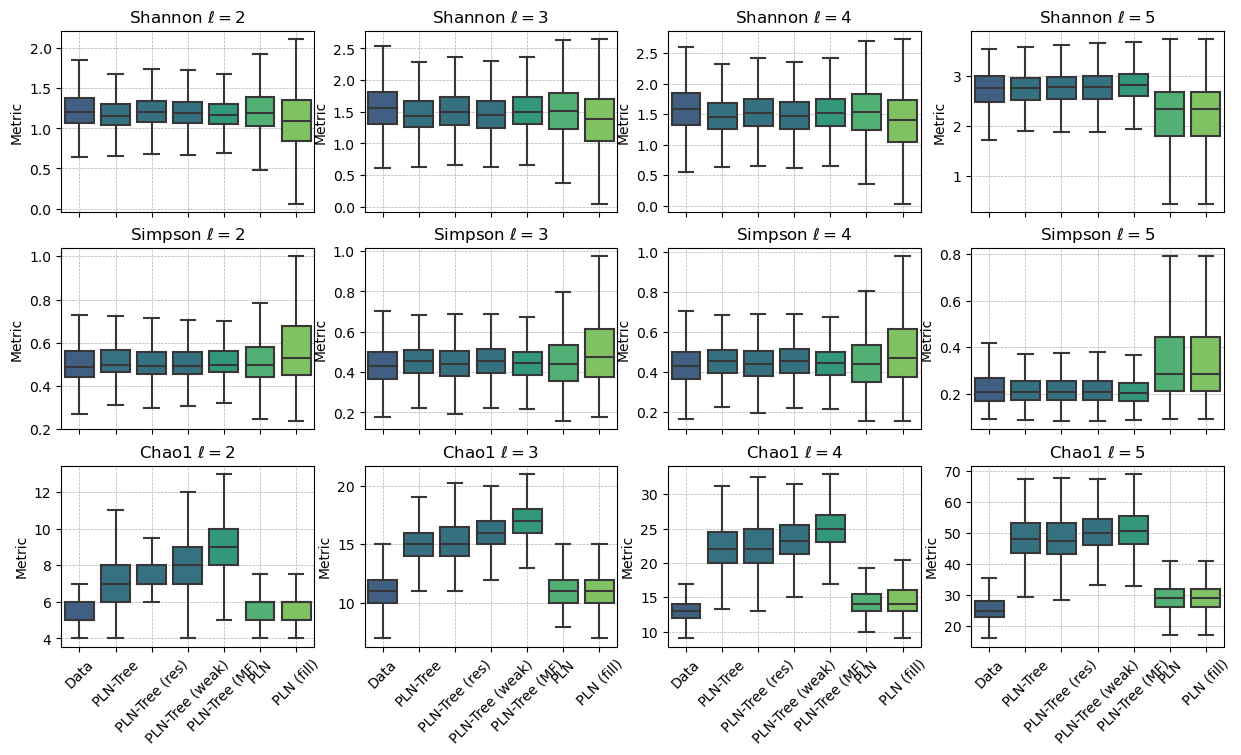

In [218]:
X_list = (X_base, X_plntree_amortized, X_plntree_res, X_plntree_weak, X_meanfield, X_pln, X_pln_fill)
groups = ['Data', 'PLN-Tree', 'PLN-Tree (res)', 'PLN-Tree (weak)', 'PLN-Tree (MF)', 'PLN', 'PLN (fill)']
colors = [viridis(0.3), viridis(0.4), viridis(0.4), viridis(0.4), viridis(0.6), viridis(0.7), viridis(0.8)]

plot_alpha_diversity(
    X_list,
    taxonomy,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot'
)

In [219]:
print('Wasserstein Distance')
repeated_metric_compute(
    taxonomy, X_base, X_list[1:], groups[1:], 
    n_split=20, distance=wasserstein_distance, offset_layer=selected_layers[0], order=True
)

Wasserstein Distance


In [220]:
print('Kolmogorov Smirnov')
repeated_metric_compute(
    taxonomy, X_base, X_list[1:], groups[1:], 
    n_split=20, distance=kolmogorov_smirnov, offset_layer=selected_layers[0], order=True
)

Kolmogorov Smirnov


In [221]:
print('Total variation')
repeated_metric_compute(
    taxonomy, X_base, X_list[1:], groups[1:], 
    n_split=20, distance=total_variation, offset_layer=selected_layers[0], order=True
)

Total variation


In [222]:
print('KL Divergence')
repeated_metric_compute(
    taxonomy, X_base, X_list[1:], groups[1:], 
    n_split=20, distance=kl_divergence, offset_layer=selected_layers[0], order=True
)

KL Divergence


In [224]:
X_plntree = X_plntree_res

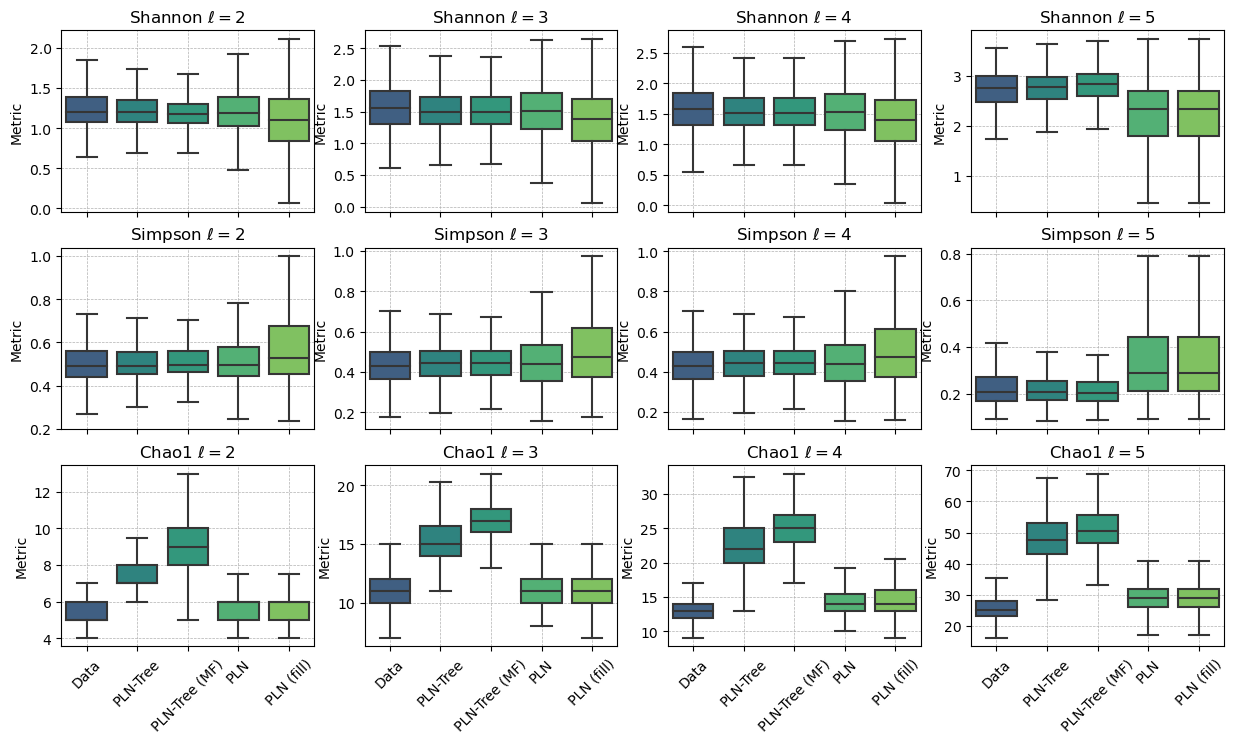

In [225]:
X_list = (X_base, X_plntree, X_meanfield, X_pln, X_pln_fill)
groups = ['Data', 'PLN-Tree', 'PLN-Tree (MF)', 'PLN', 'PLN (fill)']
colors = [viridis(0.3), viridis(0.5), viridis(0.6), viridis(0.7), viridis(0.8)]

plot_alpha_diversity(
    X_list,
    taxonomy,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot'
)

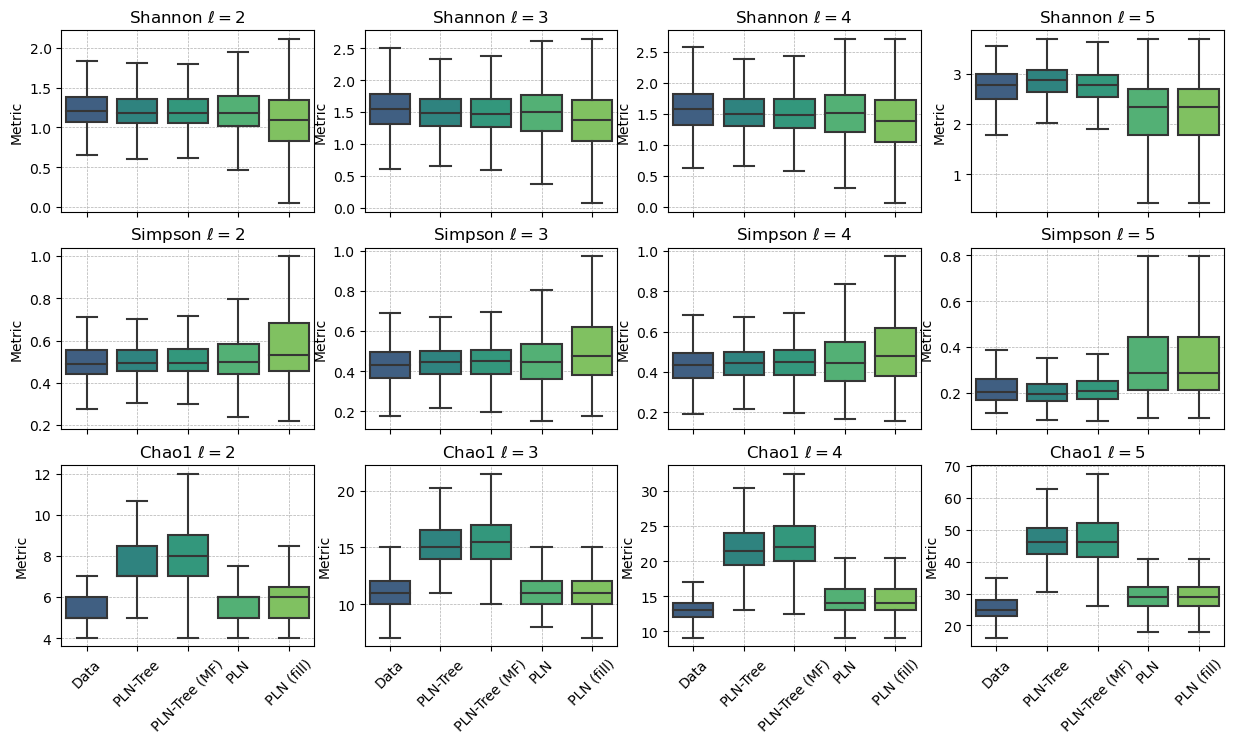

In [61]:
X_list = (X_base, X_plntree, X_meanfield, X_pln, X_pln_fill)
groups = ['Data', 'PLN-Tree', 'PLN-Tree (MF)', 'PLN', 'PLN (fill)']
colors = [viridis(0.3), viridis(0.5), viridis(0.6), viridis(0.7), viridis(0.8)]

plot_alpha_diversity(
    X_list,
    taxonomy,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
    saveName=f'application_generations_{len(estimators)}'
)

In [52]:
X_plntree = X_meanfield

In [226]:
print('Wasserstein Distance')
repeated_metric_compute(
    taxonomy, X_base, [X_plntree, X_meanfield, X_pln_fill, X_pln], ['PLN-Tree', 'MF', 'PLN (fill)', 'PLN'], 
    n_split=20, distance=wasserstein_distance, offset_layer=selected_layers[0]
)

Wasserstein Distance


In [227]:
print('KL divergence')
repeated_metric_compute(
    taxonomy, X_base, [X_plntree, X_meanfield, X_pln_fill, X_pln], ['PLN-Tree', 'MF', 'PLN (fill)', 'PLN'], 
    n_split=20, distance=kl_divergence, offset_layer=selected_layers[0]
)

KL divergence


In [228]:
print('Kolmogorov-Smirnov')
repeated_metric_compute(
    taxonomy, X_base, [X_plntree, X_meanfield, X_pln_fill, X_pln], ['PLN-Tree', 'MF', 'PLN (fill)', 'PLN'], 
    n_split=20, distance=kolmogorov_smirnov, offset_layer=selected_layers[0]
)

Kolmogorov-Smirnov


In [229]:
print('Total variation')
repeated_metric_compute(
    taxonomy, X_base, [X_plntree, X_meanfield, X_pln_fill, X_pln], ['PLN-Tree', 'MF', 'PLN (fill)', 'PLN'], 
    n_split=20, distance=total_variation, offset_layer=selected_layers[0]
)

Total variation


In [230]:
X_comp = (X_plntree, X_meanfield, X_pln_fill, X_pln)
comp_names = ['PLN-Tree', 'PLN-Tree (MF)', 'PLN (fill)', 'PLN']

print('Distribution of samples distance: Wasserstein')
compute_distribution_distance(X_base, X_comp, 10, comp_names, K, distance=emd)

Distribution of samples distance: Wasserstein


In [231]:
print('Distribution of normalized counts: KL Divergence')
def kl(p_samples, q_samples):
    p_dist = (p_samples / (p_samples.sum(axis=-1, keepdims=True) + 1e-10)).mean(axis=0)
    q_dist = (q_samples / (q_samples.sum(axis=-1, keepdims=True) + 1e-10)).mean(axis=0)
    return entropy(p_dist + 1e-10, q_dist + 1e-10)
compute_distribution_distance(X_base, X_comp, 10, comp_names, K, distance=kl)

Distribution of normalized counts: KL Divergence


In [232]:
print('Distribution of normalized counts: MAE')
def mae_dist(p_samples, q_samples):
    p_dist = (p_samples / p_samples.sum(axis=-1, keepdims=True)).mean(axis=0)
    q_dist = (q_samples / q_samples.sum(axis=-1, keepdims=True)).mean(axis=0)
    return np.mean(np.abs(p_dist - q_dist))
compute_distribution_distance(X_base, X_comp, 10, comp_names, K, distance=mae_dist)

Distribution of normalized counts: MAE


### Encoding Benchmark

Correlation against PLN-Tree:
  * layer = 2: 0.9870436607440128 ± 0.07331080262556594
  * layer = 3: 0.9788219979076506 ± 0.11048695922922606
  * layer = 4: 0.8539986253746317 ± 0.22378941575658035
  * layer = 5: 0.955836614843988 ± 0.09676097709308948
Correlation against PLN-Tree (MF):
  * layer = 2: 0.9634027943046697 ± 0.13175826677314975
  * layer = 3: 0.9571425626499338 ± 0.14843427525491848
  * layer = 4: 0.8349725394317393 ± 0.21736420001565898
  * layer = 5: 0.8577957622316712 ± 0.19421399361583086


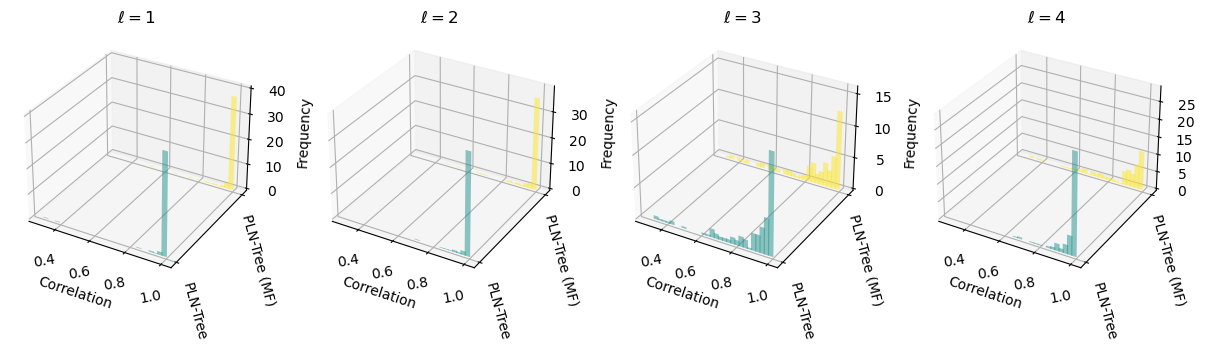

In [233]:
plntree = plntree_res
Z_test_plntree_enc, O_test_plntree_enc = plntree.encode(X_test, seed=seed)
X_test_plntree_enc = plntree.decode(Z_test_plntree_enc, O_test_plntree_enc, seed=seed)
Z_test_meanfield_enc, O_test_meanfield_enc = meanfield.encode(X_test, seed=seed)
X_test_meanfield_enc = meanfield.decode(Z_test_meanfield_enc, O_test_meanfield_enc, seed=seed)

X_comp = (X_test_plntree_enc, X_test_meanfield_enc)
groups = ['PLN-Tree', 'PLN-Tree (MF)']
for group, X_c in zip(groups, X_comp):
    print(f'Correlation against {group}:')
    correlations = correlation(X_test, X_c, meanfield)
    for layer, corr in enumerate(correlations):
        print(f'  * layer = {layer+selected_layers[0]}:', corr[~torch.isnan(corr)].mean().item(), '±', corr[~torch.isnan(corr)].std().item())
correlation_3d_plot(X_test, X_comp, groups, meanfield, saveName='')

In [234]:
for group, X_c in zip(groups, X_comp):
    m = mae_tree(to_proportion(X_test, K), to_proportion(X_c, K), K)
    print(f'MAE against {group}:', m.mean(), f'(± {m.std()})')

MAE against PLN-Tree: tensor(0.0078) (± nan)
MAE against PLN-Tree (MF): tensor(0.0141) (± nan)


Correlation against PLN-Tree:
  * layer = 2: 0.9830009466643385 ± 0.0393380408121321
  * layer = 3: 0.9793289641358308 ± 0.0466717651647033
  * layer = 4: 0.8076456291294608 ± 0.22990865697548019
  * layer = 5: 0.9569094349194898 ± 0.06563664015400826
Correlation against PLN-Tree (MF):
  * layer = 2: 0.9988755237984079 ± 0.0021899441669944496
  * layer = 3: 0.9985560072347753 ± 0.0026696137237060755
  * layer = 4: 0.9646301324087349 ± 0.08484823339016248
  * layer = 5: 0.9956714353362515 ± 0.013874435081053692
Correlation against PLN:
  * layer = 2: 0.9999928497899911 ± 1.0096970413655194e-05
  * layer = 3: 0.9999916776544973 ± 1.1318967969102163e-05
  * layer = 4: 0.9995571709720188 ± 0.001238973915005942
  * layer = 5: 0.9999771371407827 ± 2.2198395415393635e-05
Correlation against PLN (fill):
  * layer = 2: 0.9999927762487393 ± 9.53468268538741e-06
  * layer = 3: 0.9999916079179724 ± 1.079315041864724e-05
  * layer = 4: 0.999459364263645 ± 0.003260196304379378
  * layer = 5: 0.99997

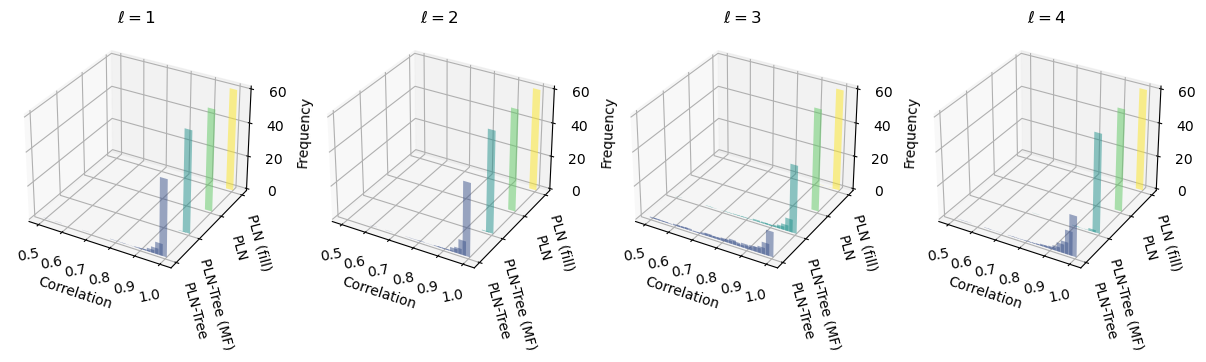

In [75]:
X_comp = (X_plntree_enc, X_meanfield_enc, X_pln_enc, X_pln_enc_fill)
groups = ['PLN-Tree', 'PLN-Tree (MF)', 'PLN', 'PLN (fill)']
for group, X_c in zip(groups, X_comp):
    print(f'Correlation against {group}:')
    correlations = correlation(X_base, X_c, meanfield)
    for layer, corr in enumerate(correlations):
        print(f'  * layer = {layer+selected_layers[0]}:', corr[~torch.isnan(corr)].mean().item(), '±', corr[~torch.isnan(corr)].std().item())
correlation_3d_plot(X_base, X_comp, groups, meanfield, saveName='')

In [76]:
for group, X_c in zip(groups, X_comp):
    m = mae_tree(to_proportion(X_base, K), to_proportion(X_c, K), K)
    print(f'MAE against {group}:', m.mean(), f'(± {m.std()})')

MAE against PLN-Tree: tensor(0.0125) (± nan)
MAE against PLN-Tree (MF): tensor(0.0035) (± nan)
MAE against PLN: tensor(0.0003) (± nan)
MAE against PLN (fill): tensor(0.0003) (± nan)
